### In this script, we will examine and visualise the data, mainly focussing on the distributions of the features to ensure the values are reasonable. 
### We will also take care of imputation (for missing values)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from tabulate import tabulate
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge

# Load the final merged dataframe
df_merged = pd.read_csv('4) final_merged_data.csv', parse_dates=['timestamp'])

In [2]:
# Create a dataframe with one row per household for static characteristics
df_households = df_merged.groupby('household_id').first().reset_index()

# Create a dataframe with one row per unique timestamp for timestamp-dependent variables
timestamp_vars = ['tariff', 'solarradiation', 'windspeed', 'temp', 'precip', 'humidity']
df_timestamps = df_merged.groupby('timestamp')[timestamp_vars].first().reset_index()

# Categorise variables (including count variables)
numerical_vars = ['consumption', 'household_size', 'male_occupants', 'female_occupants', 
                  'count_children', 'count_adult', 'count_rooms', 'count_bedrooms'] + \
                 ['count_' + bulb_type + '_bulbs' for bulb_type in ['low_efficiency', 'high_efficiency']] + \
                 ['total_refrigeration_units', 'count_fridges_and_freezers', 'count_fluorescent_tubes'] + \
                 ['count_' + appliance for appliance in ['cooking_appliances', 'laundry_appliances', 'kitchen_appliances',
                'heating_water_appliances', 'entertainment_devices', 'computing_devices', 'energy_saving_devices']] + \
                 ['count_tv', 'tv_energy_score', 'smart_meter_interaction_score']

weather_vars = ['solarradiation', 'windspeed', 'temp', 'precip', 'humidity']

categorical_vars = ['work_from_home', 'interest_in_renewable_energy', 'interest_in_microgeneration', 
                    'climate_change_concern', 'lifestyle_environment',
                    'smart_meter_bill_understanding', 'smart_meter_consumption_understanding'] + \
                   [col for col in df_merged.columns if col.endswith('_timer_use')]

timestamp_categorical_vars = ['tariff']

binary_vars = ['electric_central_heating', 'uses_electric_heater'] + \
              [col for col in df_merged.columns if col.startswith('heating_')] + \
              [col for col in df_merged.columns if col.endswith('_fixed_schedule')] + \
              [col for col in df_merged.columns if col.startswith('ownership_')] + \
              [col for col in df_merged.columns if col.startswith('housing_')] + \
              [col for col in df_merged.columns if col.endswith('_ownership')]

# Define count variables
count_vars = [
    'household_size', 'male_occupants', 'female_occupants', 'count_children', 'count_adult',
    'count_rooms', 'count_bedrooms', 'count_high_efficiency_bulbs', 'count_low_efficiency_bulbs', 
    'count_fluorescent_tubes', 'count_fridges_and_freezers', 
    'count_tv', 'count_cooking_appliances', 'count_laundry_appliances', 
    'count_kitchen_appliances', 'count_heating_water_appliances', 'count_entertainment_devices', 
    'count_computing_devices', 'count_energy_saving_devices'
]

### Let's examine the dataset first

In [3]:
# Function to examine the dataset further
def examine_data(df_households, df_timestamps, df_merged, numerical_vars, categorical_vars, binary_vars, timestamp_categorical_vars, weather_vars):
    print("Examining the dataset")
    
    # Check for missing values in df_households
    missing_values_households = df_households.isnull().sum()
    missing_percentages_households = 100 * missing_values_households / len(df_households)
    missing_table_households = pd.concat([missing_values_households, missing_percentages_households], axis=1, keys=['Missing Values', 'Percentage'])
    missing_table_households = missing_table_households[missing_table_households['Missing Values'] > 0].sort_values('Missing Values', ascending=False)
    
    print("\nMissing Values in Household Data:")
    print(missing_table_households)
    
    # Check for missing values in df_timestamps
    missing_values_timestamps = df_timestamps.isnull().sum()
    missing_percentages_timestamps = 100 * missing_values_timestamps / len(df_timestamps)
    missing_table_timestamps = pd.concat([missing_values_timestamps, missing_percentages_timestamps], axis=1, keys=['Missing Values', 'Percentage'])
    missing_table_timestamps = missing_table_timestamps[missing_table_timestamps['Missing Values'] > 0].sort_values('Missing Values', ascending=False)
    
    print("\nMissing Values in Timestamp Data:")
    print(missing_table_timestamps)
    
    # Check unique values for categorical variables
    print("\nUnique Values in Categorical Variables:")
    for col in categorical_vars:
        if col in df_households.columns:
            unique_count = df_households[col].nunique()
            print(f"{col}: {unique_count} unique values")
            if unique_count < 10:
                print(df_households[col].value_counts(dropna=False))
            print() 
    
    # Check unique values for timestamp categorical variables
    print("\nUnique Values in Timestamp Categorical Variables:")
    for col in timestamp_categorical_vars:
        unique_count = df_timestamps[col].nunique() 
        print(f"{col}: {unique_count} unique values")
        if unique_count < 10:
            print(df_timestamps[col].value_counts(dropna=False)) 
        print() 
    
    # Check unique values for binary variables
    print("\nUnique Values in Binary Variables:")
    for col in binary_vars:
        unique_count = df_households[col].nunique()
        print(f"{col}: {unique_count} unique values")
        print(df_households[col].value_counts(dropna=False))
        print()
    
    # Basic statistics for numerical variables
    print("\nBasic Statistics for Numerical Variables:")
    for var in numerical_vars:
        if var in df_households.columns:
            print(f"\n{var} (Household data):")
            print(df_households[var].describe())
        elif var in df_timestamps.columns:
            print(f"\n{var} (Timestamp data):")
            print(df_timestamps[var].describe())
        elif var == 'consumption':
            print(f"\n{var} (Merged data):")
            print(df_merged[var].describe())

# Examine the data
examine_data(df_households, df_timestamps, df_merged, numerical_vars, categorical_vars, binary_vars, timestamp_categorical_vars, weather_vars)

Examining the dataset

Missing Values in Household Data:
                                              Missing Values  Percentage
insulation_floor_insulation                              315   51.809211
insulation_wall_insulation                               271   44.572368
insulation_hot_water_tank_insulation_lagging             183   30.098684
insulation_roof_or_loft_insulation                       157   25.822368
kettle_fixed_schedule                                    114   18.750000
ironing_fixed_schedule                                   106   17.434211
washer-dryer_combined_ownership                          103   16.940789
washer-dryer_combined_timer_use                          103   16.940789
tumble_dryer_timer_use                                    78   12.828947
tumble_dryer_ownership                                    78   12.828947
washing_machine_timer_use                                 71   11.677632
washing_machine_ownership                                 71   11.6

### Let's drop the insulation features as they have a high missing percentage of values missing
#### Note: Keeping the insulation values and imputing them skewed the distributions greatly and also did not improve model performance later.

In [4]:
df_households.drop(columns=[col for col in df_households.columns if col.startswith('insulation')], inplace=True)
df_merged.drop(columns=[col for col in df_merged.columns if col.startswith('insulation')], inplace=True)

### Data Visualisation (Pre-imputation)
#### Note: Consumption plots are towards the end of the notebook.

In [5]:
# Function to plot numerical variables
def plot_numerical(df_households, df_timestamps, df_merged, vars):
    for var in vars:
        if var == 'consumption':
            continue # Since we have already performed imputation on consumption values, we will just plot them at the end
        elif var in df_households.columns:
            # Handling for household-level numerical variables
            # Create side-by-side boxplot and histogram
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            sns.boxplot(x=df_households[var], ax=ax1)
            ax1.set_title(f'Boxplot of {var}')
            ax1.set_xlabel(var)
            sns.histplot(df_households[var], kde=True, ax=ax2)
            ax2.set_title(f'Histogram of {var}')
            ax2.set_xlabel(var)
            ax2.set_ylabel('Count')
            plt.tight_layout()
            plt.show()
        
            # Print summary statistics
            print(f"\nSummary statistics for {var}:")
            print(df_households[var].describe())
        
            # Calculate and print outlier information
            Q1 = df_households[var].quantile(0.25)
            Q3 = df_households[var].quantile(0.75)
            IQR = Q3 - Q1
            outliers = df_households[(df_households[var] < (Q1 - 1.5 * IQR)) | (df_households[var] > (Q3 + 1.5 * IQR))]
            print(f"Number of outliers: {len(outliers)}")
            print(f"Percentage of outliers: {len(outliers) / len(df_households) * 100:.2f}%")

        elif var in df_timestamps.columns:
            # Handling for timestamp-dependent numerical variables
            
            # Create side-by-side boxplot and histogram
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            sns.boxplot(x=df_timestamps[var], ax=ax1)
            ax1.set_title(f'Boxplot of {var}')
            ax1.set_xlabel(var)
            sns.histplot(df_timestamps[var], kde=True, ax=ax2)
            ax2.set_title(f'Histogram of {var}')
            ax2.set_xlabel(var)
            ax2.set_ylabel('Count')
            plt.tight_layout()
            plt.show()
        
            # Print summary statistics
            print(f"\nSummary statistics for {var}:")
            print(df_timestamps[var].describe())
        
            # Calculate and print outlier information
            Q1 = df_timestamps[var].quantile(0.25)
            Q3 = df_timestamps[var].quantile(0.75)
            IQR = Q3 - Q1
            outliers = df_timestamps[(df_timestamps[var] < (Q1 - 1.5 * IQR)) | (df_timestamps[var] > (Q3 + 1.5 * IQR))]
            print(f"Number of outliers: {len(outliers)}")
            print(f"Percentage of outliers: {len(outliers) / len(df_timestamps) * 100:.2f}%")

# Function to plot categorical variables
def plot_categorical(df_households, vars):
    # Define mappings for categorical variables to their string representations
    mappings = {
        'work_from_home': {0: 'Never', 1: 'Occasionally', 2: 'About half the time', 3: 'Most/all weekdays'},
        'interest_in_renewable_energy': {0: 'Not at all interested', 1: 'Not very interested', 
                                         2: "don't know/haven't thought about it", 3: 'Fairly interested', 4: 'Very interested'},
        'interest_in_microgeneration': {0: 'Not at all interested', 1: 'Not very interested', 
                                        2: "don't know/haven't thought about it", 3: 'Fairly interested', 4: 'Very interested'},
        'climate_change_concern': {0: 'Not at all concerned', 1: 'Not very concerned', 
                                   2: "don't know/No opinion", 3: 'Fairly concerned', 4: 'Very concerned'},
        'lifestyle_environment': {0: 'Happy with what I do', 1: 'Like to do a bit more', 2: 'Like to do a lot more'},
        'smart_meter_bill_understanding': {0: 'Not at all helpful', 1: 'Not very helpful', 
                                           2: 'Have not thought about it/Don\'t know', 3: 'Fairly helpful', 4: 'Very helpful'},
        'smart_meter_consumption_understanding': {0: 'Not at all helpful', 1: 'Not very helpful', 
                                                  2: 'Have not thought about it/Don\'t know', 3: 'Fairly helpful', 4: 'Very helpful'}
    }
    
    # Add mappings for timer use variables
    for col in df_households.columns:
        if col.endswith('_timer_use'):
            mappings[col] = {0: "Don't have appliance/No timer/never use", 
                             1: "Sometimes use timer", 
                             2: "Often use timer"}

    for var in vars:
        if var in ['ownership_type', 'housing_type']:
            # Special handling for grouped binary variables
            if var == 'ownership_type':
                plot_grouped_binary(df_households, 'ownership_', 'Distribution of Ownership Types')
            else:  # housing_type
                plot_grouped_binary(df_households, 'housing_', 'Distribution of Housing Types')
        elif var in df_households.columns:
            # Plotting for other categorical variables
            plt.figure(figsize=(12, 6))
            
            if var in mappings:
                # Use mappings if available
                categories = list(mappings[var].values())
                data = df_households[var].map(mappings[var])
                data = pd.Categorical(data, categories=categories, ordered=True)
                data = data.value_counts().sort_index()
            else:
                # Otherwise, use raw data
                data = df_households[var].value_counts().sort_index()
            
            data.plot(kind='bar')
            plt.title(f'Distribution of {var}')
            plt.xlabel(var)
            plt.ylabel('Count of Households')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
            
            # Print frequency table
            print(f"\nFrequency table for {var}:")
            print(data / len(df_households))

# Function to plot timestamp categorical variables
def plot_timestamp_categorical(df_timestamps, vars):
    # Define mappings for timestamp categorical variables
    mappings = {
        'tariff': {0.0399: 'Low', 0.1176: 'Normal', 0.672: 'High'},
    }
    
    for var in vars:
        plt.figure(figsize=(12, 6))
        
        if var in mappings:
            # Use mappings if available
            data = df_timestamps[var].map(mappings[var]).value_counts().sort_index()
        else:
            # Otherwise, use raw data
            data = df_timestamps[var].value_counts().sort_index()
        
        data.plot(kind='bar')
        plt.title(f'Distribution of {var}')
        plt.xlabel(var)
        plt.ylabel('Count of Timestamps')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Print frequency table
        print(f"\nFrequency table for {var}:")
        print(data / len(df_timestamps))

# Function to plot binary variables
def plot_binary(df_households, vars):
    colors = {0: 'blue', 1: 'green'}
    for var in vars:
        if var.startswith('ownership_') or var.startswith('housing_'):
            continue  # These are handled separately in plot_grouped_binary
        
        # Create pie chart for binary variable
        plt.figure(figsize=(8, 5))
        data = df_households[var].value_counts()
        data.plot(kind='pie', autopct='%1.1f%%', colors=[colors.get(val, 'gray') for val in data.index])
        plt.title(f'Distribution of {var}')
        plt.ylabel('')
        plt.show()
        
        # Print frequency table
        print(f"\nFrequency table for {var}:")
        print(df_households[var].value_counts(normalize=True))

# Function to plot grouped binary variables (for ownership and housing features)
def plot_grouped_binary(df_households, prefix, title):
    # Identify columns that start with the given prefix
    cols = [col for col in df_households.columns if col.startswith(prefix)]
    data = df_households[cols].sum()
    
    # Create pie chart
    plt.figure(figsize=(12, 8))
    wedges, texts, autotexts = plt.pie(data, autopct=lambda pct: f'{pct:.1f}%' if pct > 0.5 else '', 
                                       textprops=dict(color="w"), startangle=90)
    plt.title(title)
    plt.axis('equal')
    
    # Add legend
    plt.legend(wedges, [col.replace(prefix, '').capitalize() for col in cols], 
               title="Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    
    plt.tight_layout()
    plt.show()

    # Print frequency table
    print(f"\nFrequency table for {title}:")
    print(data / len(df_households))

# Function to plot weather variables
def plot_weather(df_timestamps, weather_vars):
    for var in weather_vars:
        # Plot time series of weather variable
        plt.figure(figsize=(15, 5))
        plt.plot(df_timestamps['timestamp'], df_timestamps[var])
        plt.title(f'{var} Over Time')
        plt.xlabel('Date')
        plt.ylabel(var)
        plt.grid(True)
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Print summary statistics
        print(f"\nSummary statistics for {var}:")
        print(df_timestamps[var].describe())

        # Calculate and display outlier information
        Q1 = df_timestamps[var].quantile(0.25)
        Q3 = df_timestamps[var].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df_timestamps[(df_timestamps[var] < (Q1 - 1.5 * IQR)) | (df_timestamps[var] > (Q3 + 1.5 * IQR))]
        print(f"Number of outliers: {len(outliers)}")
        print(f"Percentage of outliers: {len(outliers) / len(df_timestamps) * 100:.2f}%")

        # Plot histogram of weather variable
        plt.figure(figsize=(10, 5))
        sns.histplot(df_timestamps[var], kde=True)
        plt.title(f'Distribution of {var}')
        plt.xlabel(var)
        plt.ylabel('Count')
        plt.show()

        # Plot boxplot of weather variable
        plt.figure(figsize=(10, 5))
        sns.boxplot(x=df_timestamps[var])
        plt.title(f'Boxplot of {var}')
        plt.xlabel(var)
        plt.show()


### The following section creates univariate plots for each feature. Though tedious, this process was necessary for checking the data quality and ensuring the distributions of values before and after imputation were aligned for each feature.

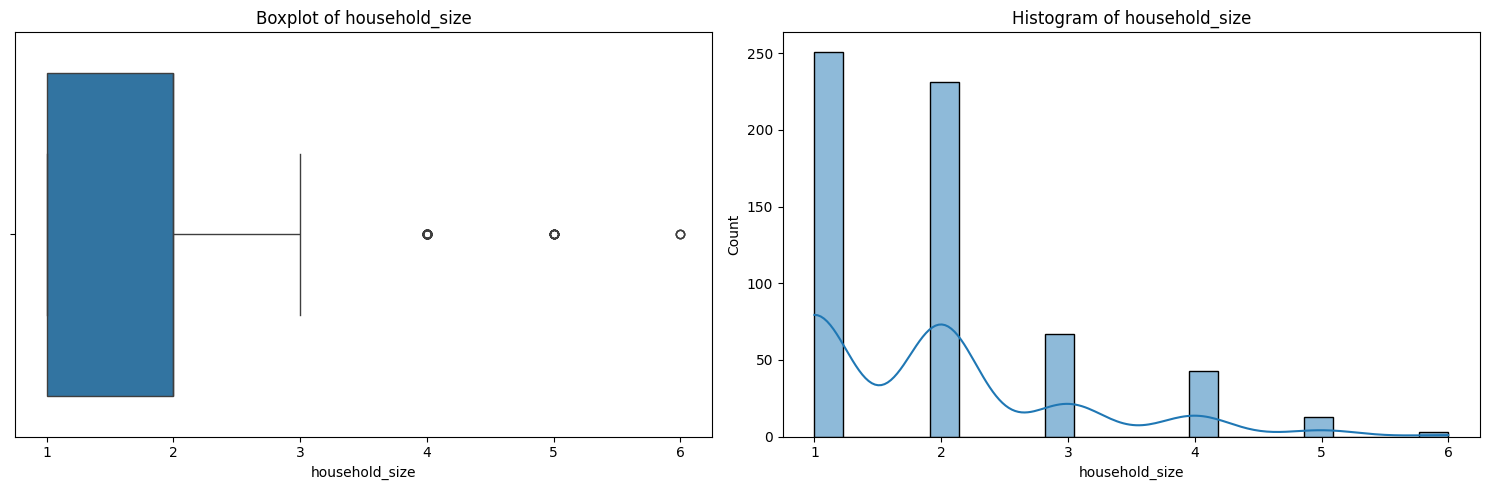


Summary statistics for household_size:
count    608.000000
mean       1.922697
std        1.035901
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        6.000000
Name: household_size, dtype: float64
Number of outliers: 59
Percentage of outliers: 9.70%


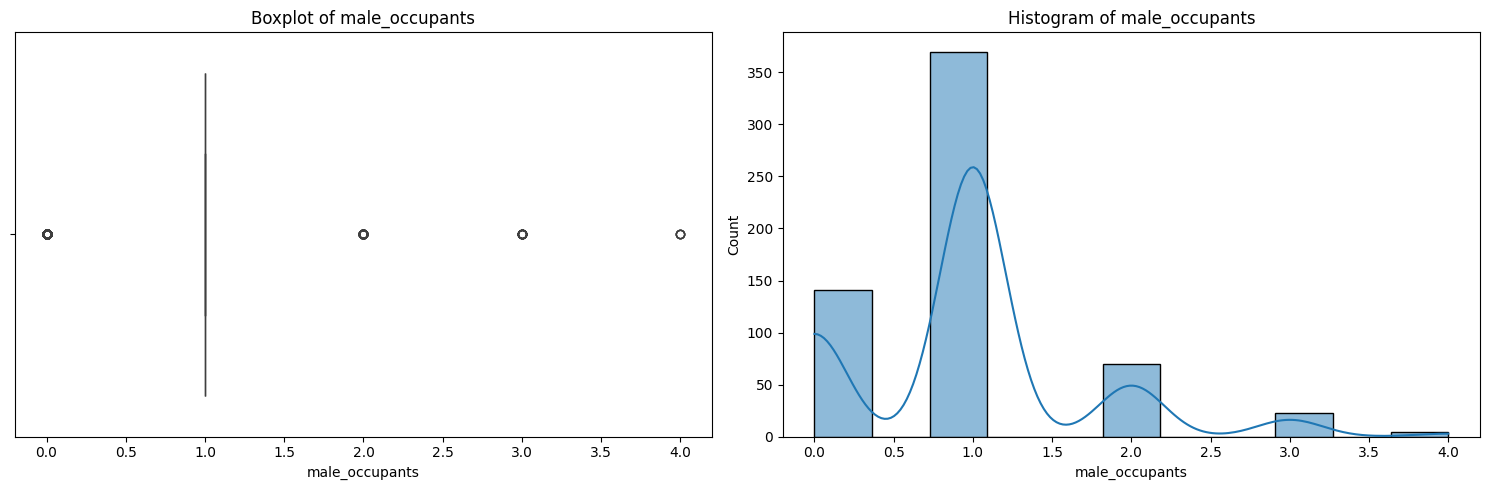


Summary statistics for male_occupants:
count    608.000000
mean       0.978618
std        0.747012
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        4.000000
Name: male_occupants, dtype: float64
Number of outliers: 238
Percentage of outliers: 39.14%


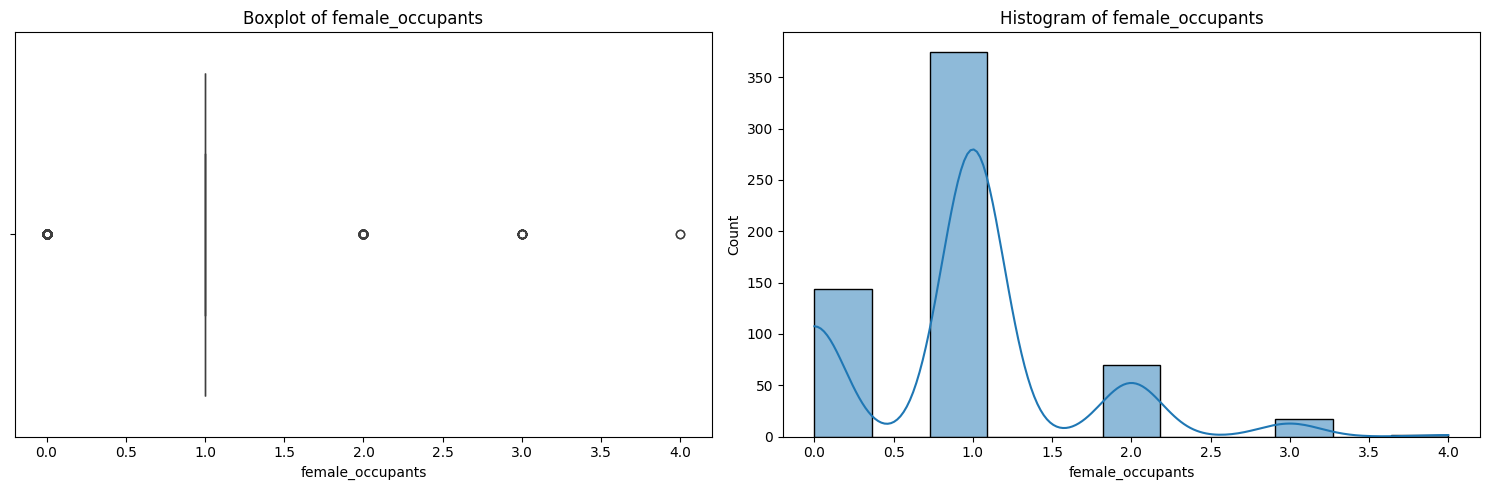


Summary statistics for female_occupants:
count    608.000000
mean       0.944079
std        0.700786
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        4.000000
Name: female_occupants, dtype: float64
Number of outliers: 233
Percentage of outliers: 38.32%


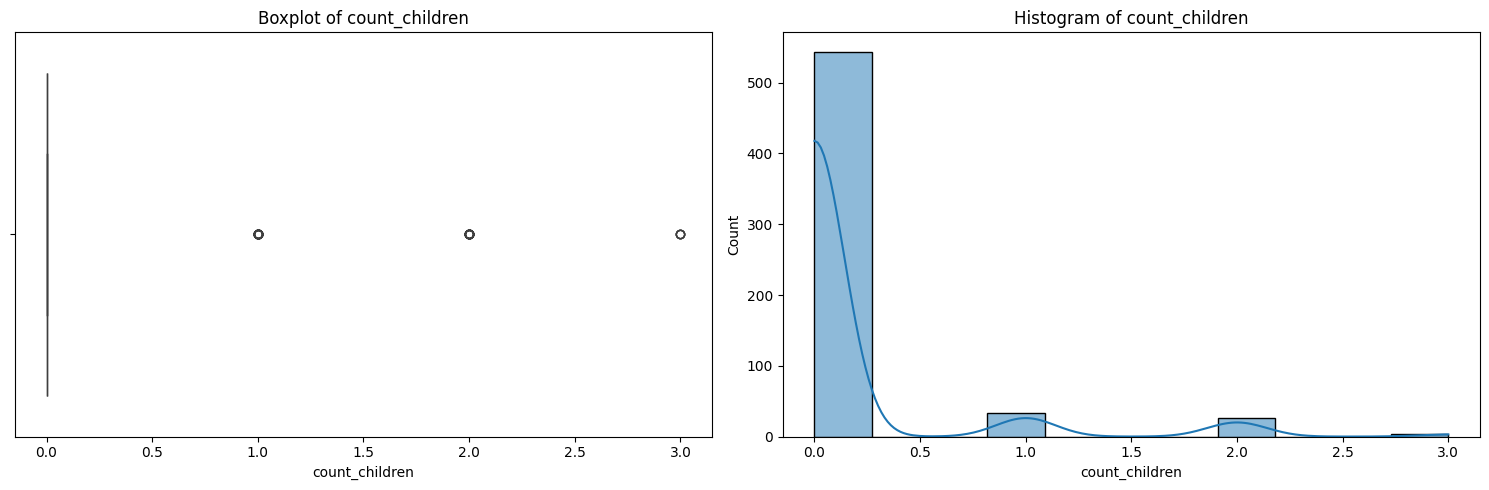


Summary statistics for count_children:
count    608.000000
mean       0.161184
std        0.510522
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: count_children, dtype: float64
Number of outliers: 64
Percentage of outliers: 10.53%


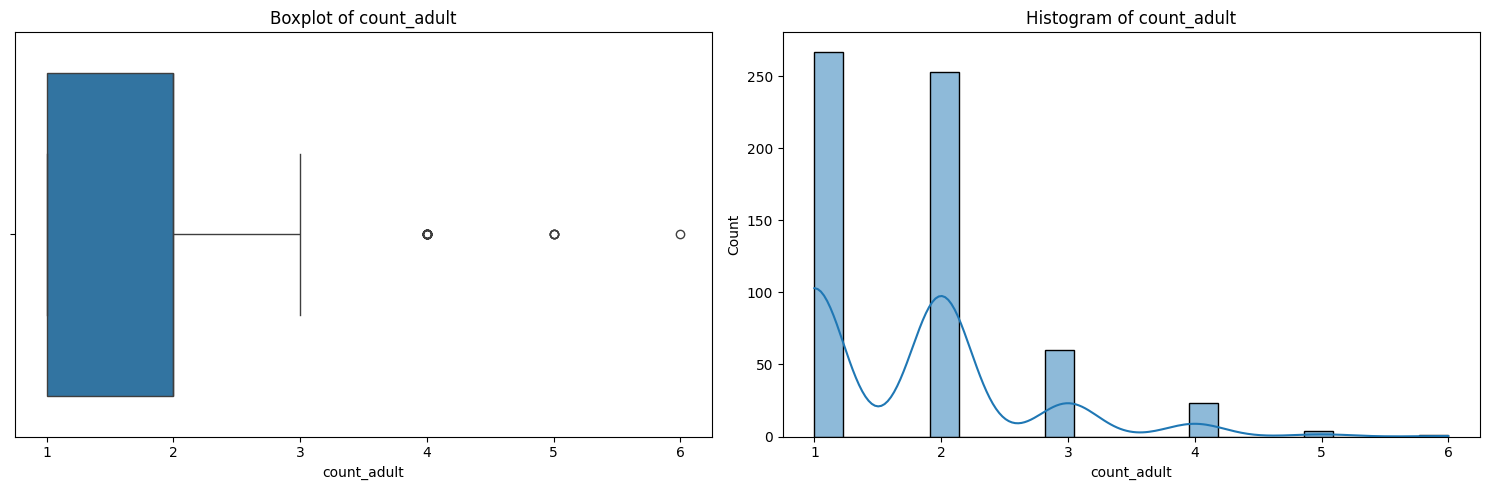


Summary statistics for count_adult:
count    608.000000
mean       1.761513
std        0.847925
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        6.000000
Name: count_adult, dtype: float64
Number of outliers: 28
Percentage of outliers: 4.61%


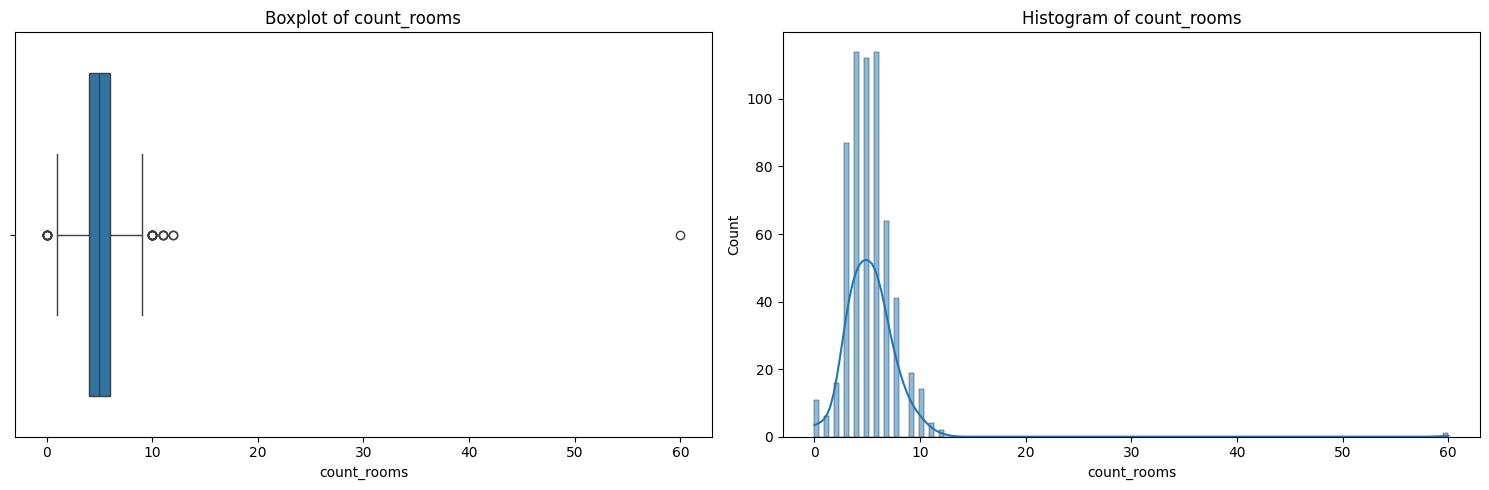


Summary statistics for count_rooms:
count    605.000000
mean       5.312397
std        3.038919
min        0.000000
25%        4.000000
50%        5.000000
75%        6.000000
max       60.000000
Name: count_rooms, dtype: float64
Number of outliers: 32
Percentage of outliers: 5.26%


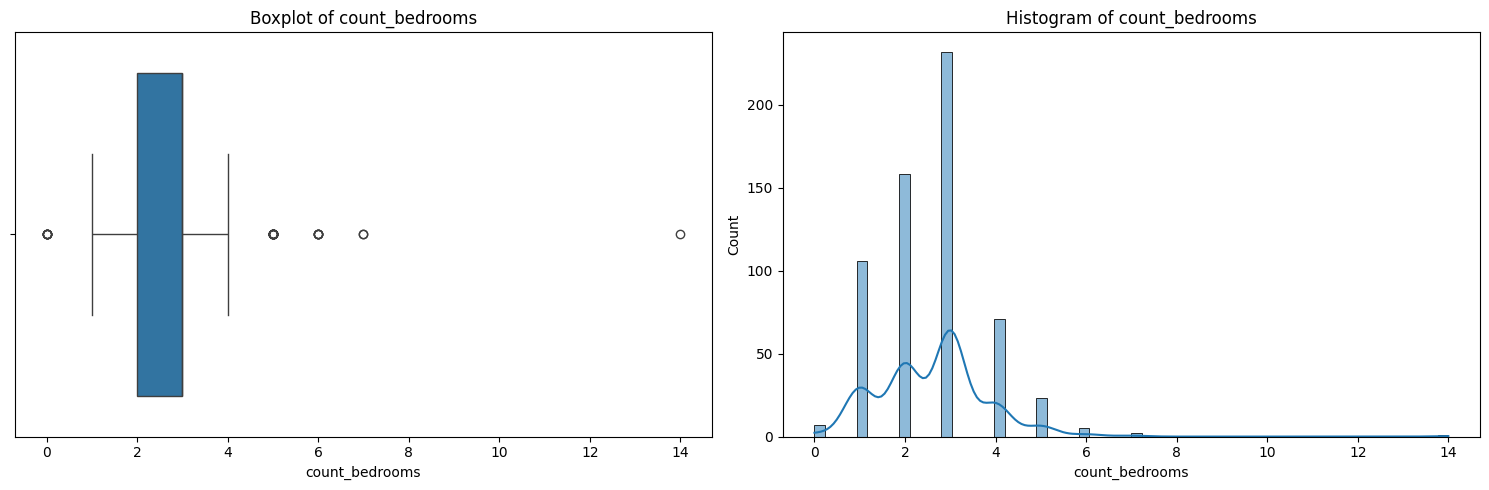


Summary statistics for count_bedrooms:
count    605.000000
mean       2.603306
std        1.227980
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max       14.000000
Name: count_bedrooms, dtype: float64
Number of outliers: 38
Percentage of outliers: 6.25%


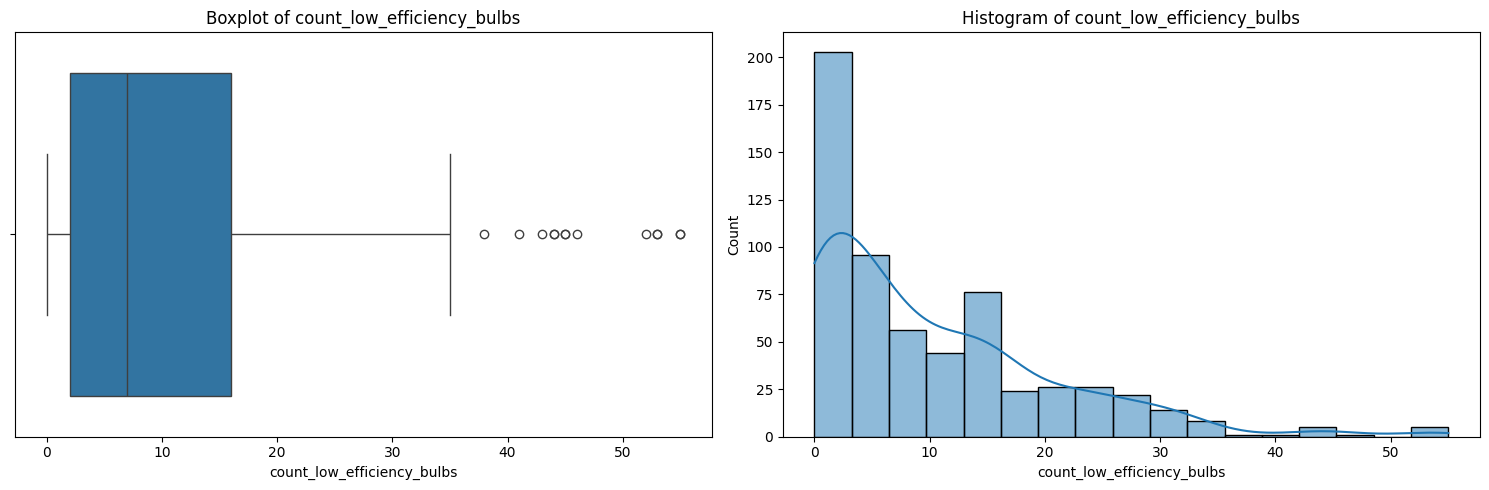


Summary statistics for count_low_efficiency_bulbs:
count    608.000000
mean      10.228618
std       10.494623
min        0.000000
25%        2.000000
50%        7.000000
75%       16.000000
max       55.000000
Name: count_low_efficiency_bulbs, dtype: float64
Number of outliers: 13
Percentage of outliers: 2.14%


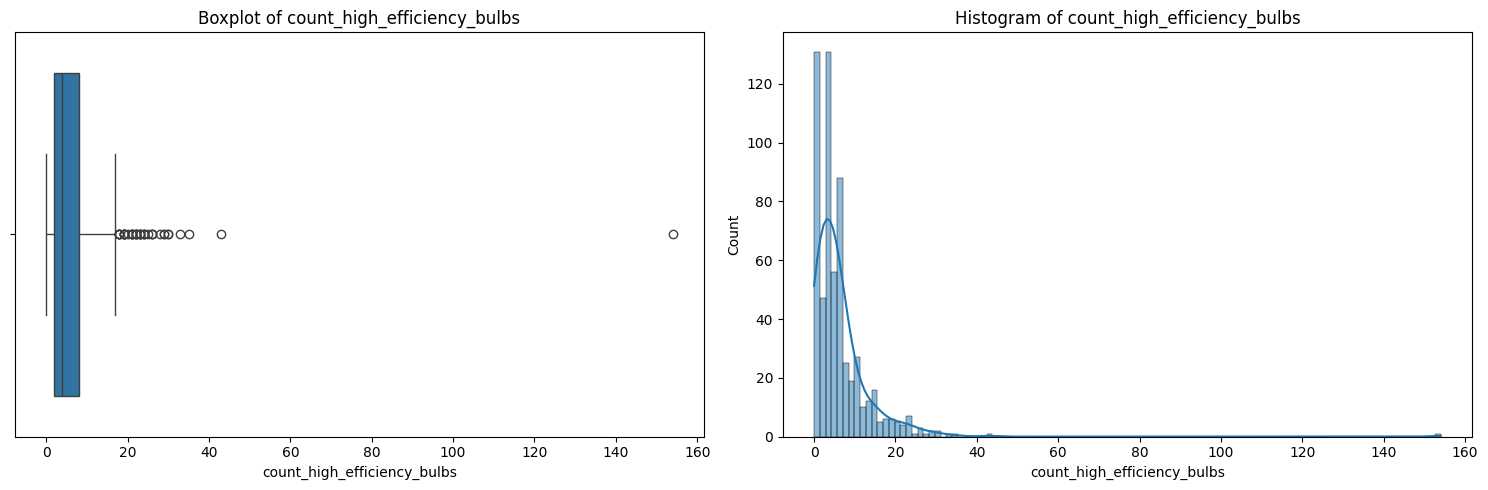


Summary statistics for count_high_efficiency_bulbs:
count    608.000000
mean       6.202303
std        8.591989
min        0.000000
25%        2.000000
50%        4.000000
75%        8.000000
max      154.000000
Name: count_high_efficiency_bulbs, dtype: float64
Number of outliers: 40
Percentage of outliers: 6.58%


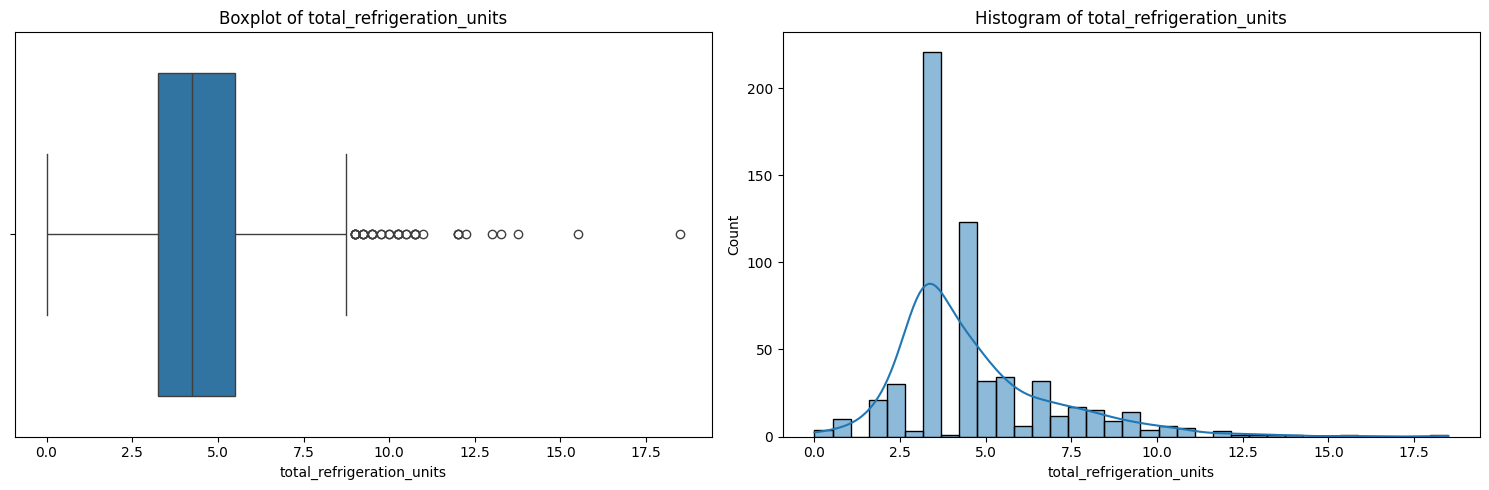


Summary statistics for total_refrigeration_units:
count    608.000000
mean       4.642681
std        2.308144
min        0.000000
25%        3.250000
50%        4.250000
75%        5.500000
max       18.500000
Name: total_refrigeration_units, dtype: float64
Number of outliers: 38
Percentage of outliers: 6.25%


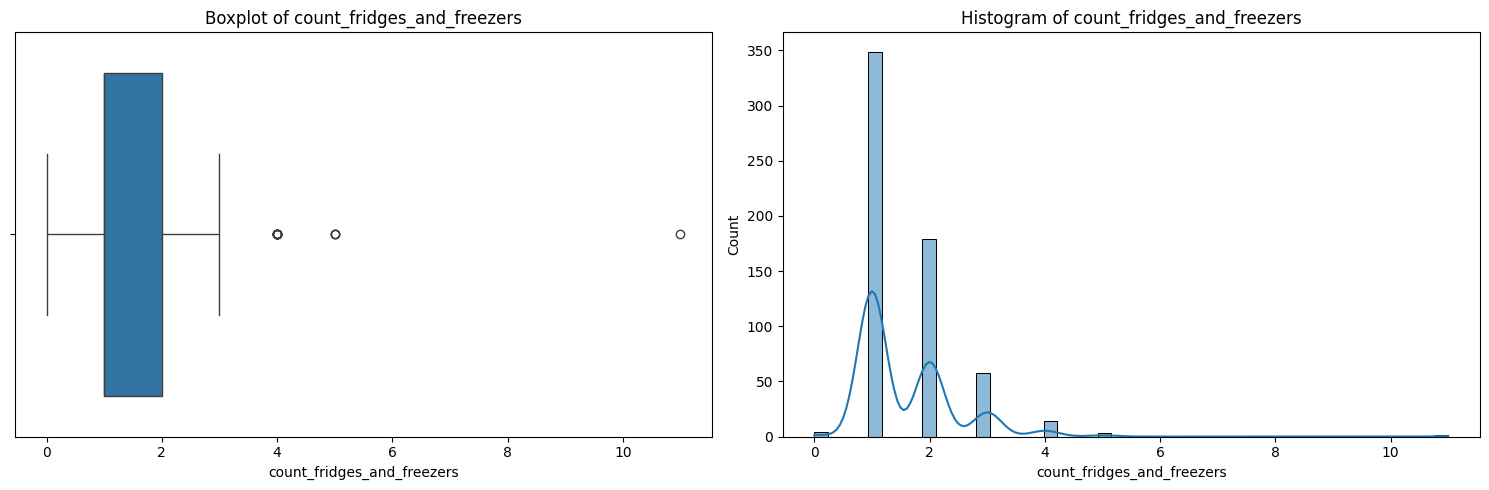


Summary statistics for count_fridges_and_freezers:
count    608.000000
mean       1.583882
std        0.890849
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       11.000000
Name: count_fridges_and_freezers, dtype: float64
Number of outliers: 18
Percentage of outliers: 2.96%


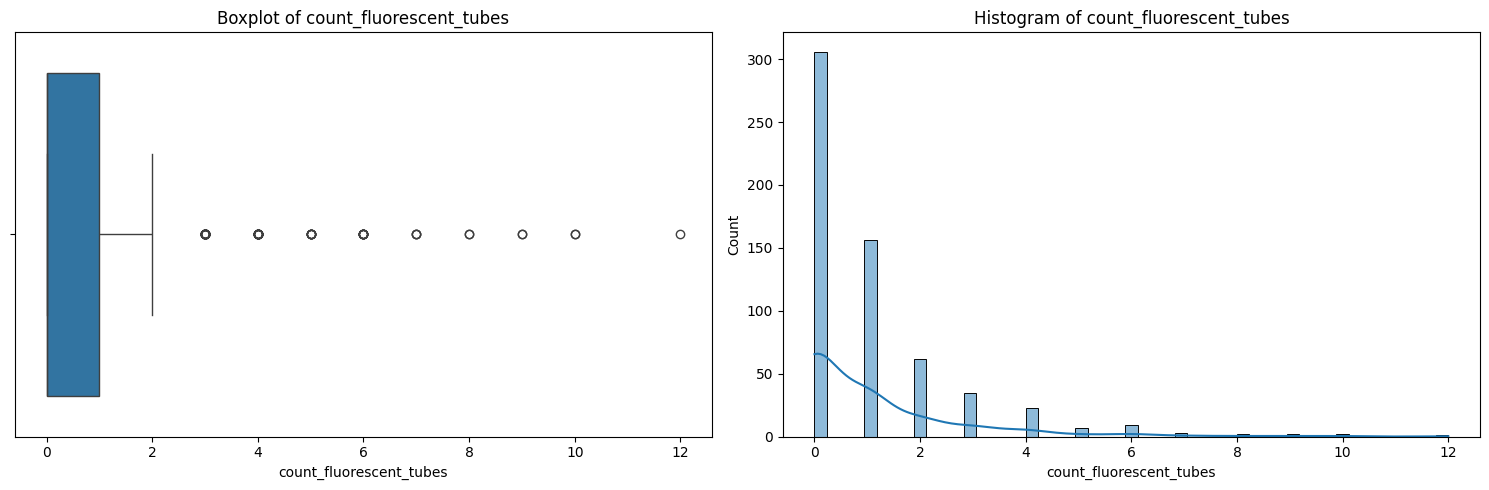


Summary statistics for count_fluorescent_tubes:
count    608.000000
mean       1.074013
std        1.656533
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       12.000000
Name: count_fluorescent_tubes, dtype: float64
Number of outliers: 84
Percentage of outliers: 13.82%


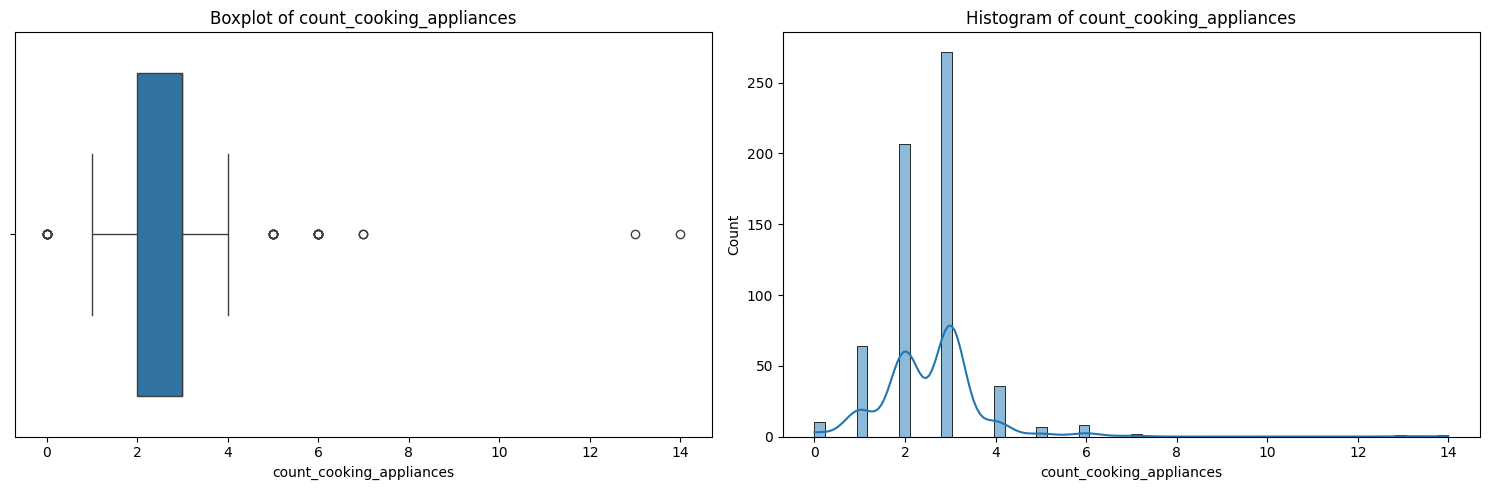


Summary statistics for count_cooking_appliances:
count    608.000000
mean       2.569079
std        1.168715
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max       14.000000
Name: count_cooking_appliances, dtype: float64
Number of outliers: 29
Percentage of outliers: 4.77%


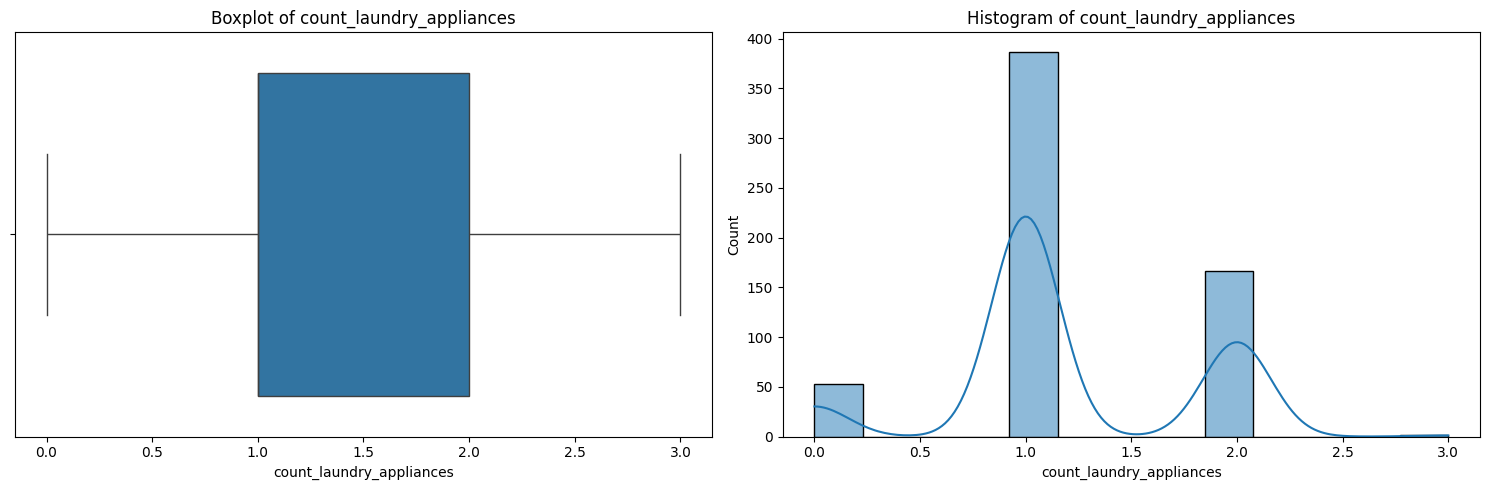


Summary statistics for count_laundry_appliances:
count    608.000000
mean       1.192434
std        0.580412
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: count_laundry_appliances, dtype: float64
Number of outliers: 0
Percentage of outliers: 0.00%


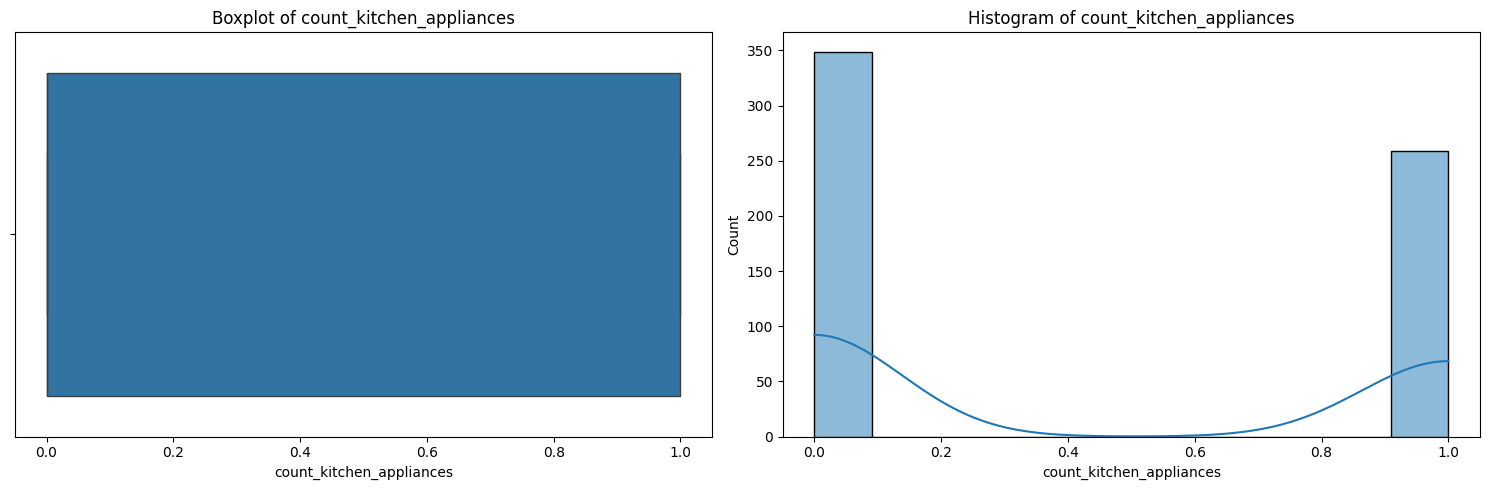


Summary statistics for count_kitchen_appliances:
count    608.000000
mean       0.425987
std        0.494899
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: count_kitchen_appliances, dtype: float64
Number of outliers: 0
Percentage of outliers: 0.00%


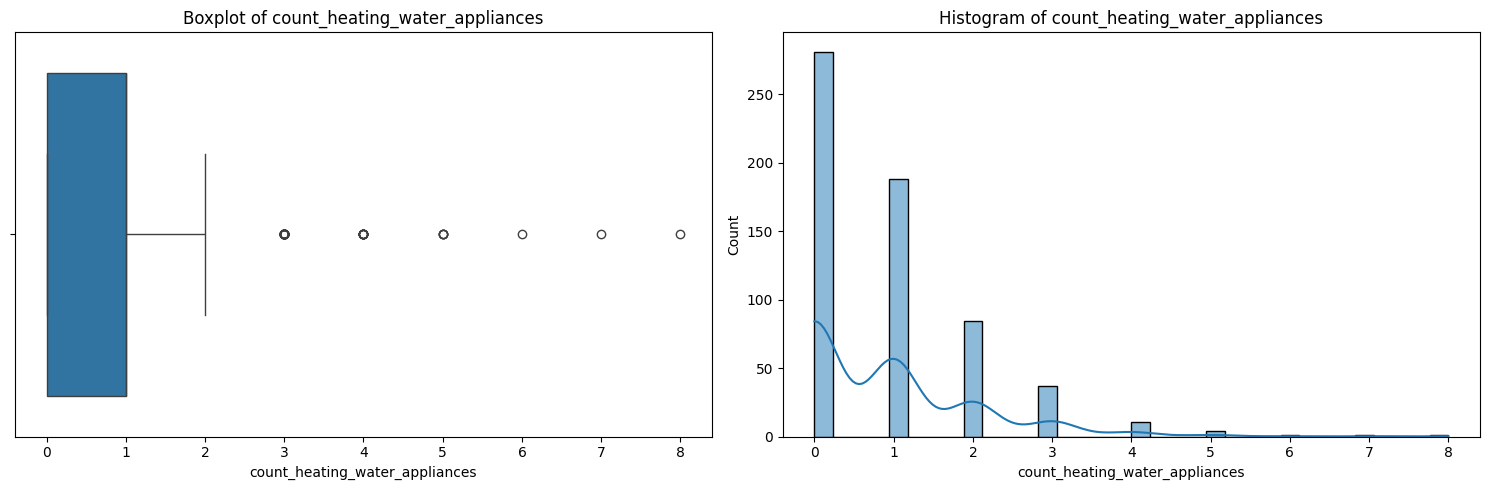


Summary statistics for count_heating_water_appliances:
count    608.000000
mean       0.907895
std        1.134194
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        8.000000
Name: count_heating_water_appliances, dtype: float64
Number of outliers: 55
Percentage of outliers: 9.05%


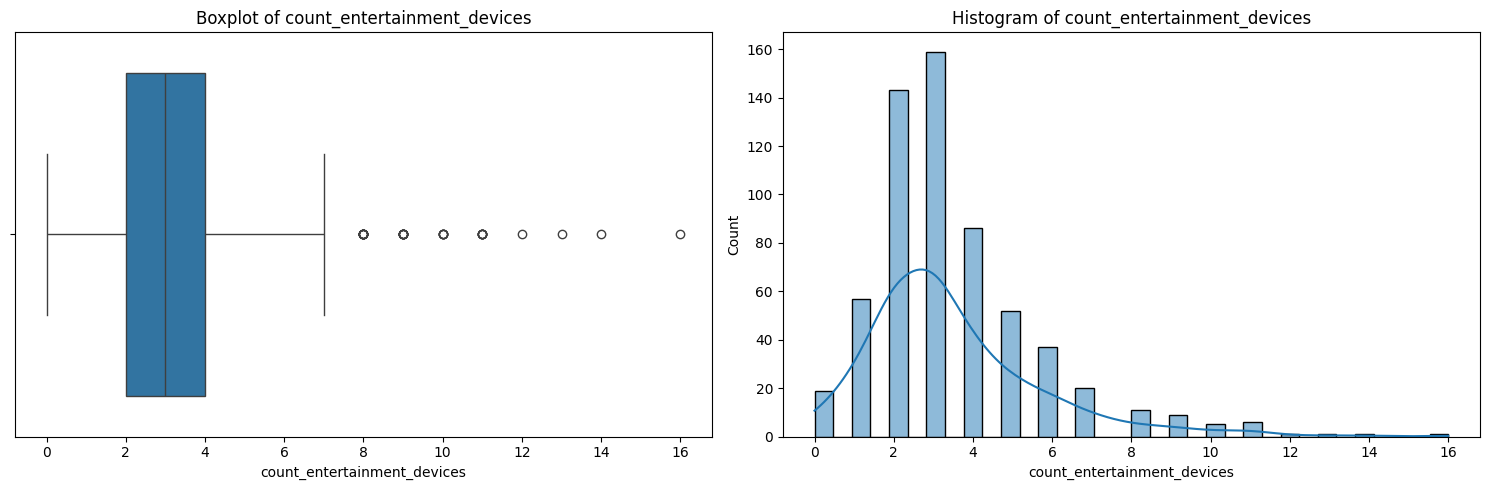


Summary statistics for count_entertainment_devices:
count    608.000000
mean       3.496711
std        2.237170
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       16.000000
Name: count_entertainment_devices, dtype: float64
Number of outliers: 35
Percentage of outliers: 5.76%


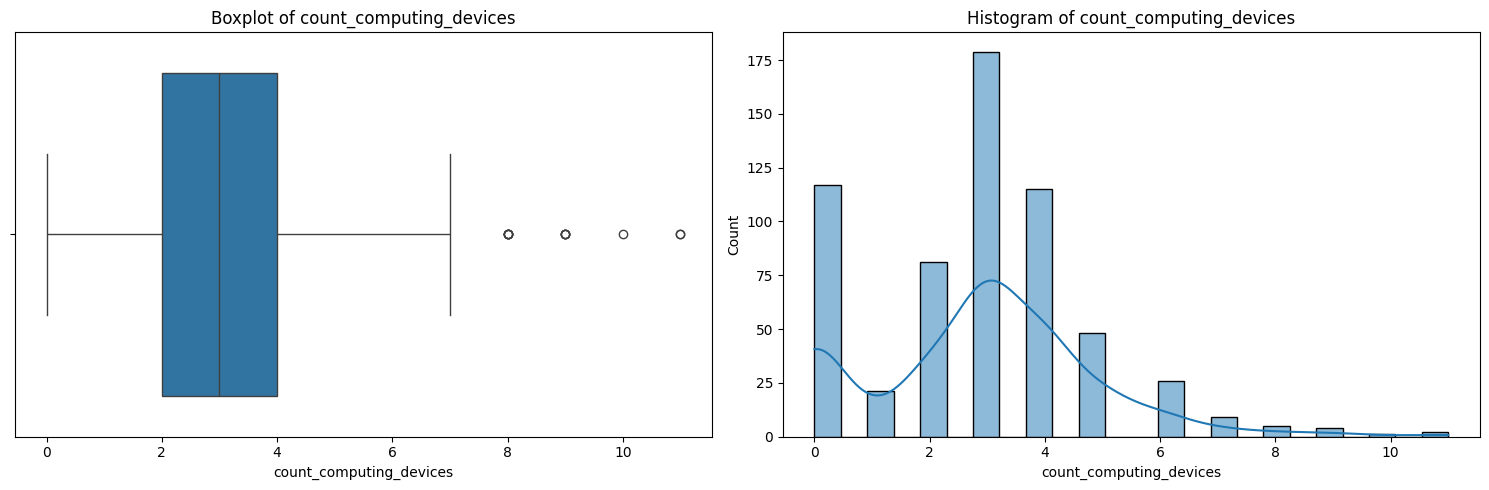


Summary statistics for count_computing_devices:
count    608.000000
mean       2.873355
std        1.963106
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       11.000000
Name: count_computing_devices, dtype: float64
Number of outliers: 12
Percentage of outliers: 1.97%


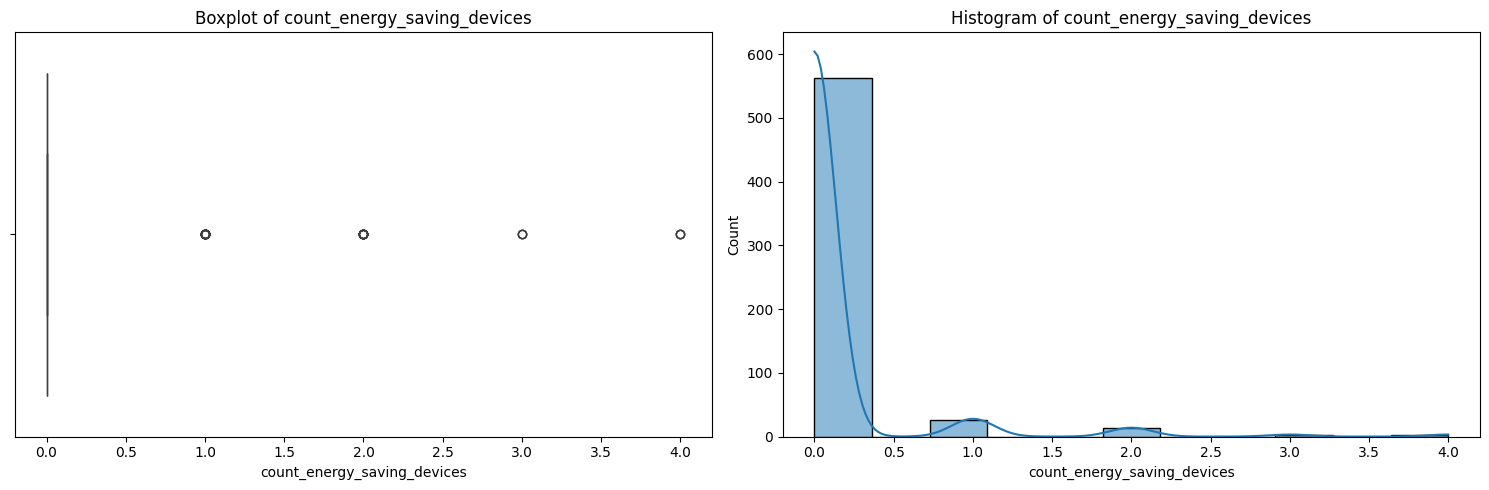


Summary statistics for count_energy_saving_devices:
count    608.000000
mean       0.120066
std        0.487463
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        4.000000
Name: count_energy_saving_devices, dtype: float64
Number of outliers: 45
Percentage of outliers: 7.40%


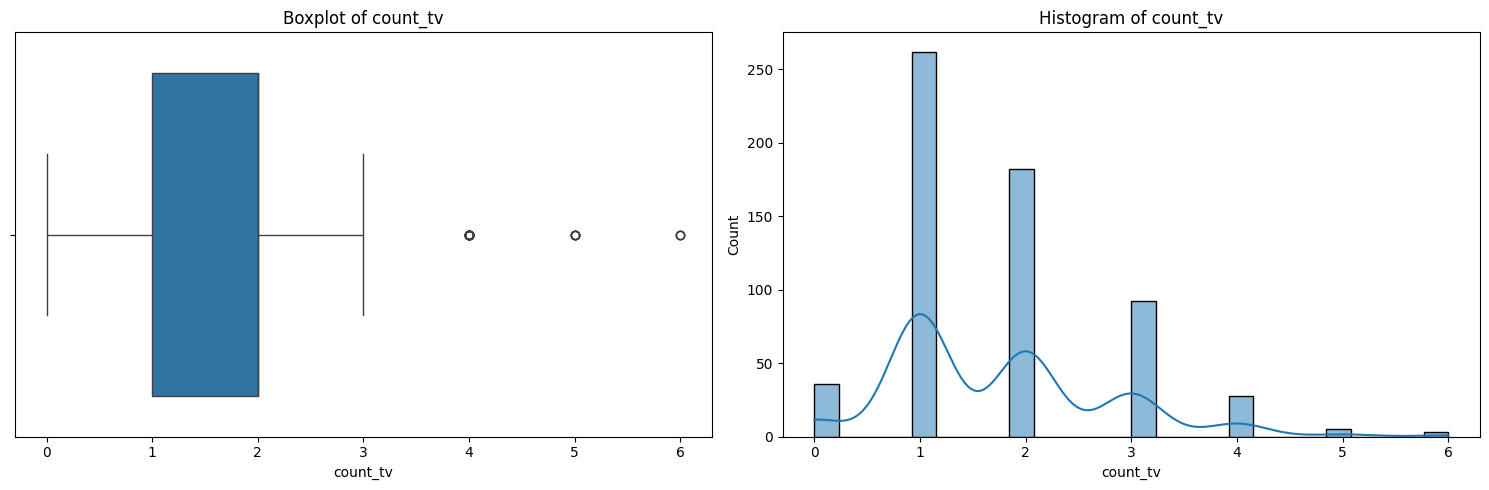


Summary statistics for count_tv:
count    608.000000
mean       1.738487
std        1.043864
min        0.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        6.000000
Name: count_tv, dtype: float64
Number of outliers: 36
Percentage of outliers: 5.92%


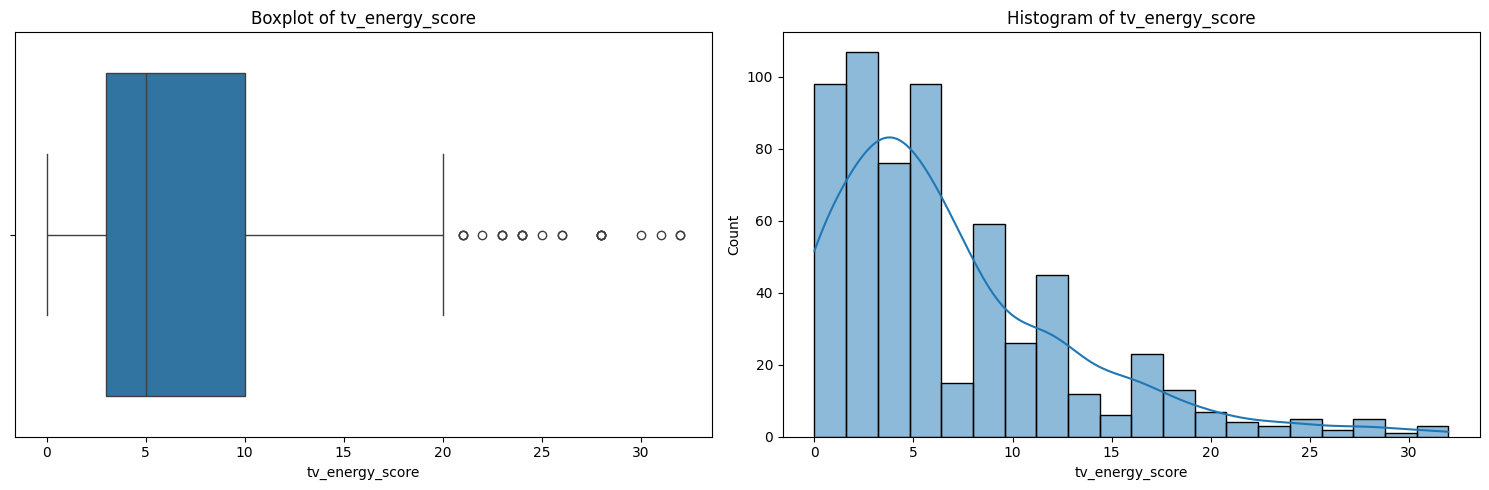


Summary statistics for tv_energy_score:
count    608.000000
mean       6.806743
std        6.165021
min        0.000000
25%        3.000000
50%        5.000000
75%       10.000000
max       32.000000
Name: tv_energy_score, dtype: float64
Number of outliers: 23
Percentage of outliers: 3.78%


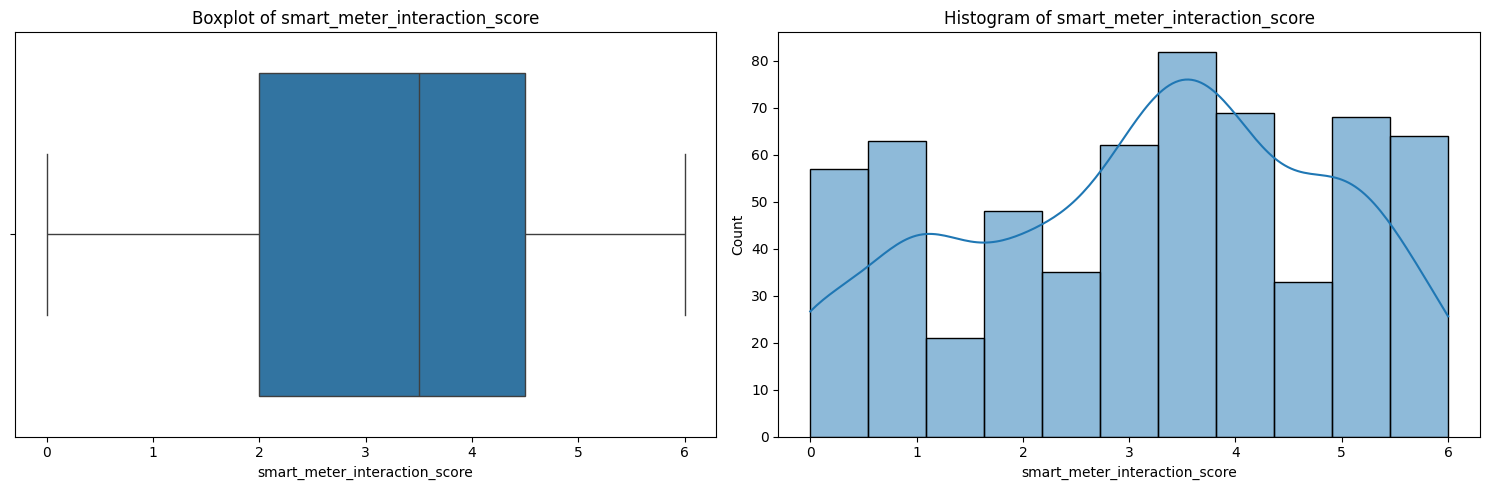


Summary statistics for smart_meter_interaction_score:
count    602.000000
mean       3.136213
std        1.696297
min        0.000000
25%        2.000000
50%        3.500000
75%        4.500000
max        6.000000
Name: smart_meter_interaction_score, dtype: float64
Number of outliers: 0
Percentage of outliers: 0.00%


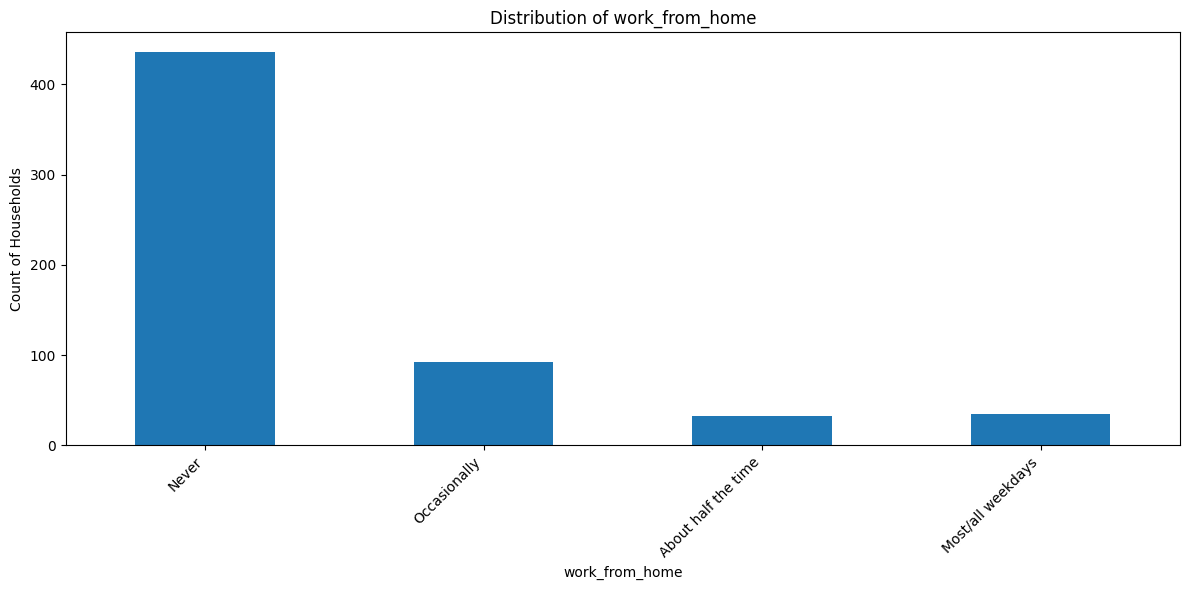


Frequency table for work_from_home:
Never                  0.717105
Occasionally           0.151316
About half the time    0.054276
Most/all weekdays      0.057566
Name: count, dtype: float64


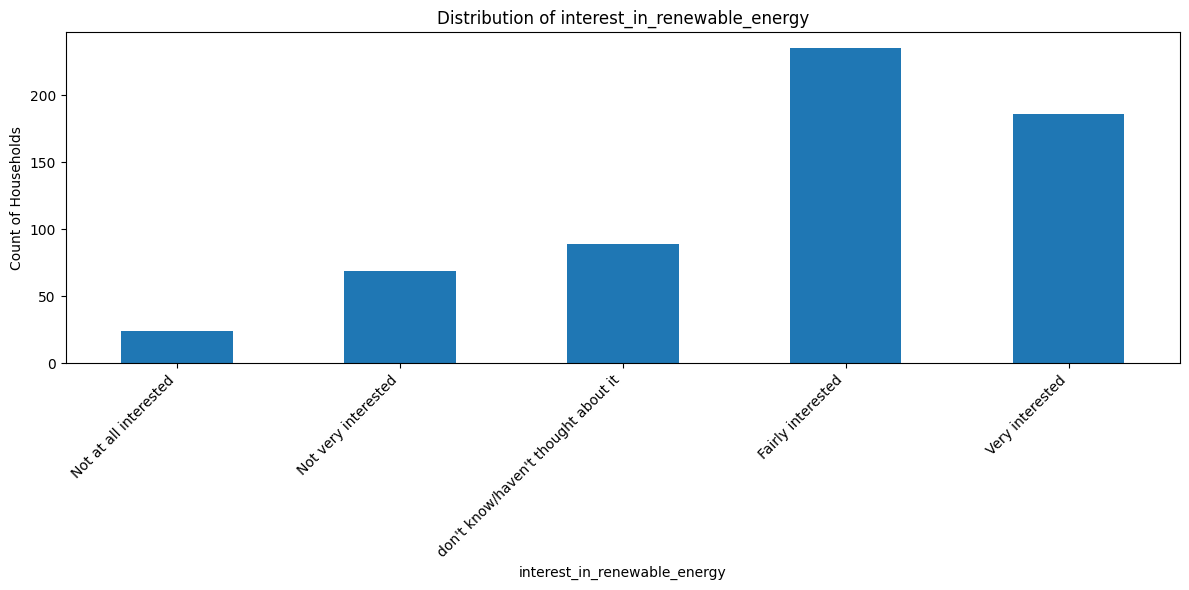


Frequency table for interest_in_renewable_energy:
Not at all interested                  0.039474
Not very interested                    0.113487
don't know/haven't thought about it    0.146382
Fairly interested                      0.386513
Very interested                        0.305921
Name: count, dtype: float64


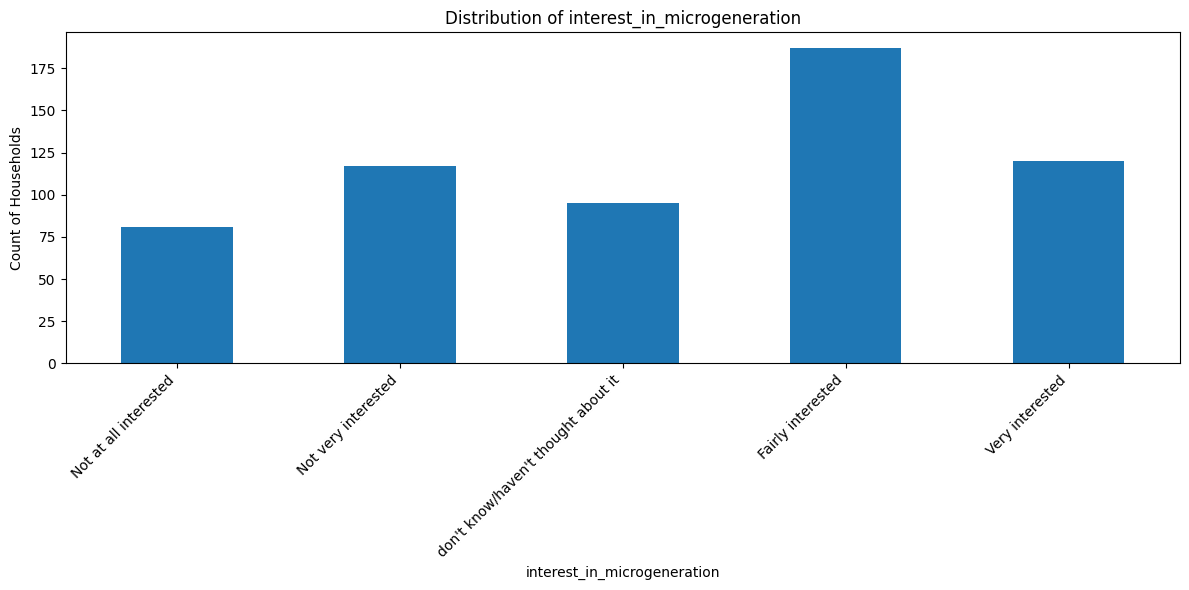


Frequency table for interest_in_microgeneration:
Not at all interested                  0.133224
Not very interested                    0.192434
don't know/haven't thought about it    0.156250
Fairly interested                      0.307566
Very interested                        0.197368
Name: count, dtype: float64


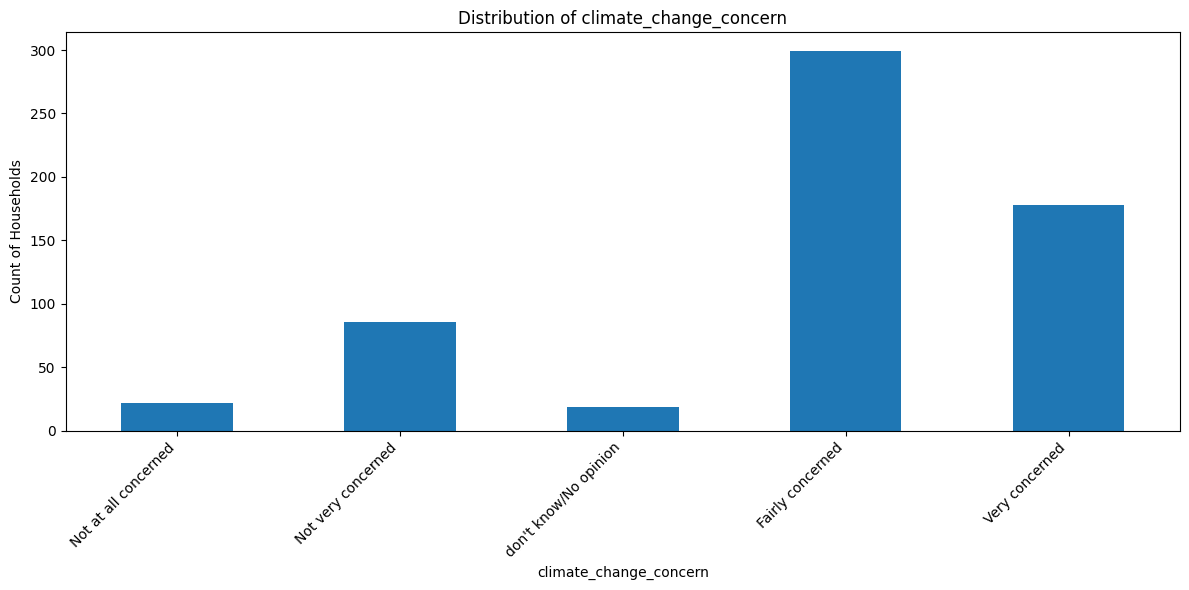


Frequency table for climate_change_concern:
Not at all concerned     0.036184
Not very concerned       0.141447
don't know/No opinion    0.031250
Fairly concerned         0.491776
Very concerned           0.292763
Name: count, dtype: float64


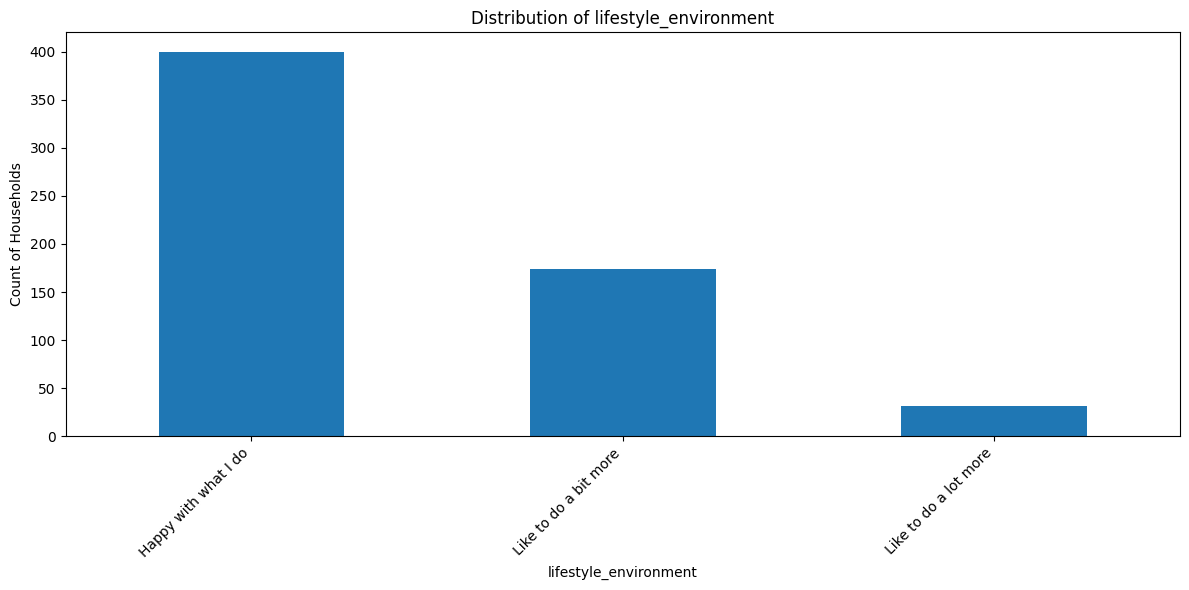


Frequency table for lifestyle_environment:
Happy with what I do     0.657895
Like to do a bit more    0.286184
Like to do a lot more    0.050987
Name: count, dtype: float64


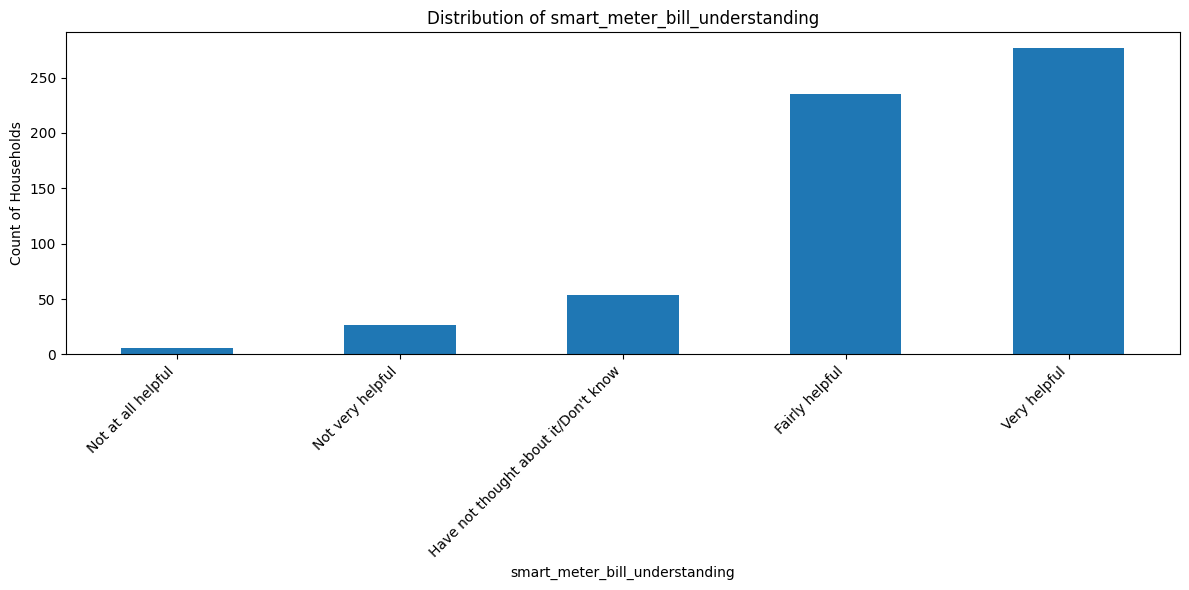


Frequency table for smart_meter_bill_understanding:
Not at all helpful                      0.009868
Not very helpful                        0.044408
Have not thought about it/Don't know    0.088816
Fairly helpful                          0.386513
Very helpful                            0.455592
Name: count, dtype: float64


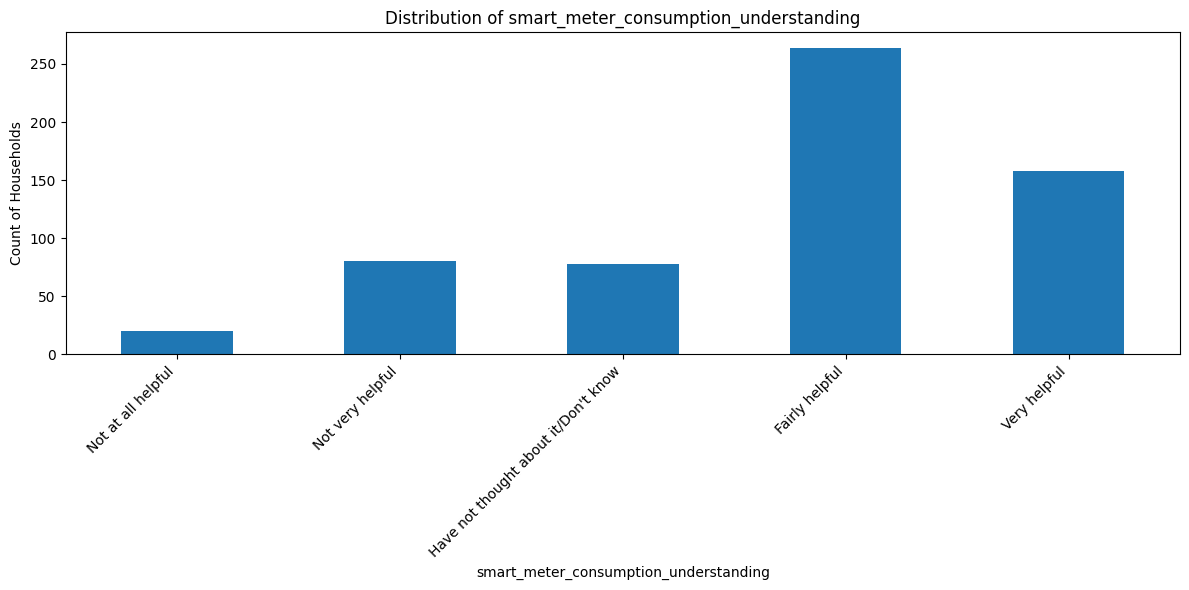


Frequency table for smart_meter_consumption_understanding:
Not at all helpful                      0.032895
Not very helpful                        0.131579
Have not thought about it/Don't know    0.128289
Fairly helpful                          0.434211
Very helpful                            0.259868
Name: count, dtype: float64


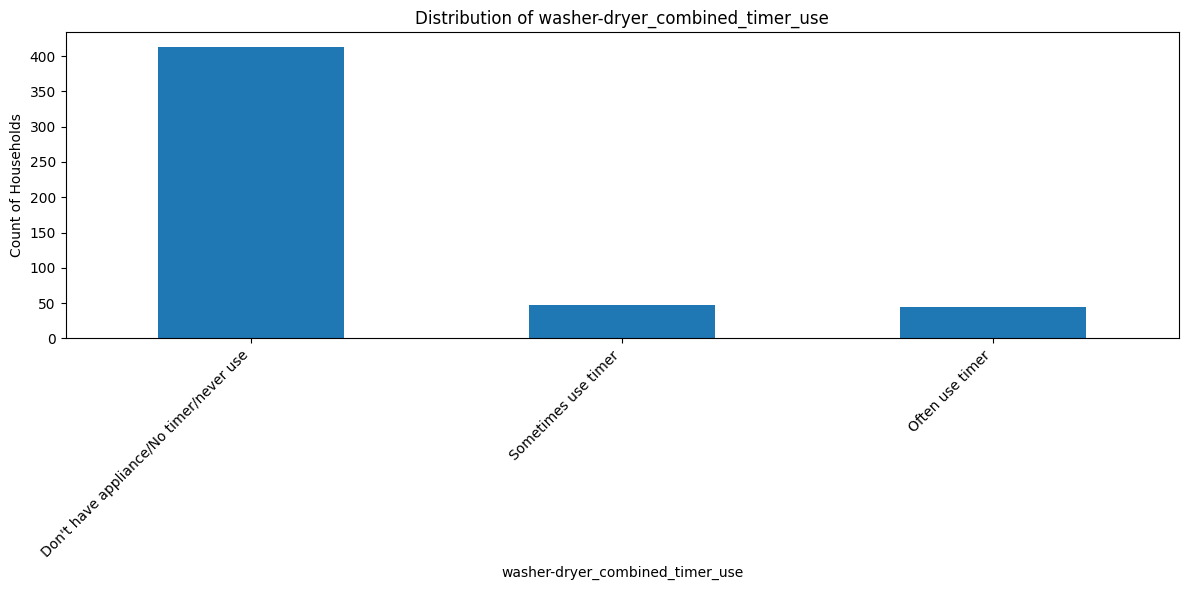


Frequency table for washer-dryer_combined_timer_use:
Don't have appliance/No timer/never use    0.679276
Sometimes use timer                        0.077303
Often use timer                            0.074013
Name: count, dtype: float64


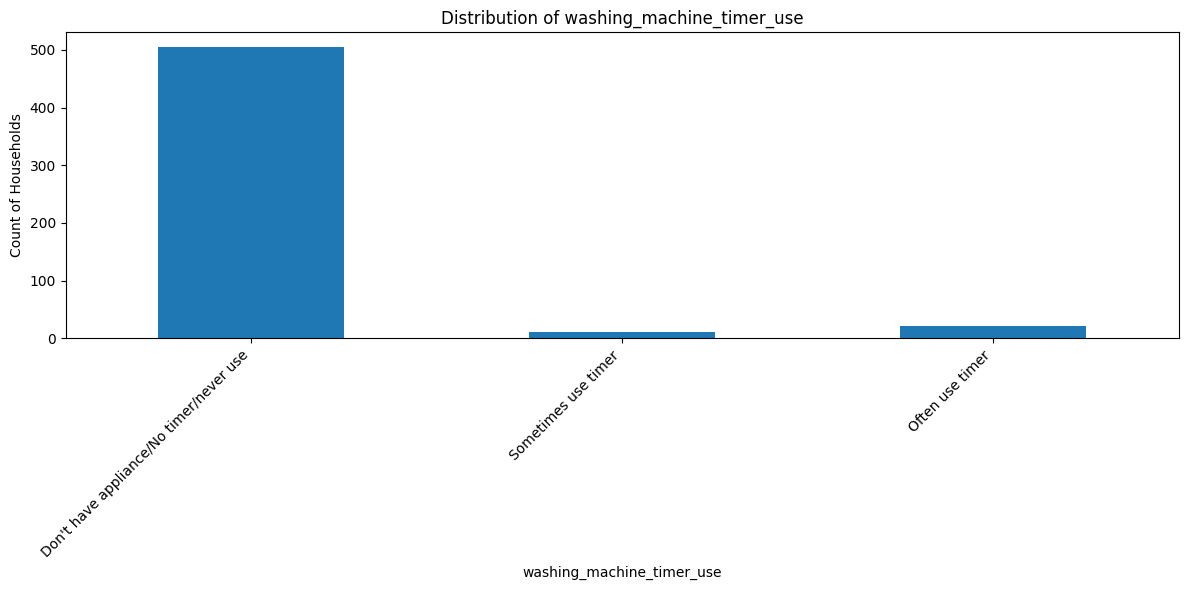


Frequency table for washing_machine_timer_use:
Don't have appliance/No timer/never use    0.830592
Sometimes use timer                        0.018092
Often use timer                            0.034539
Name: count, dtype: float64


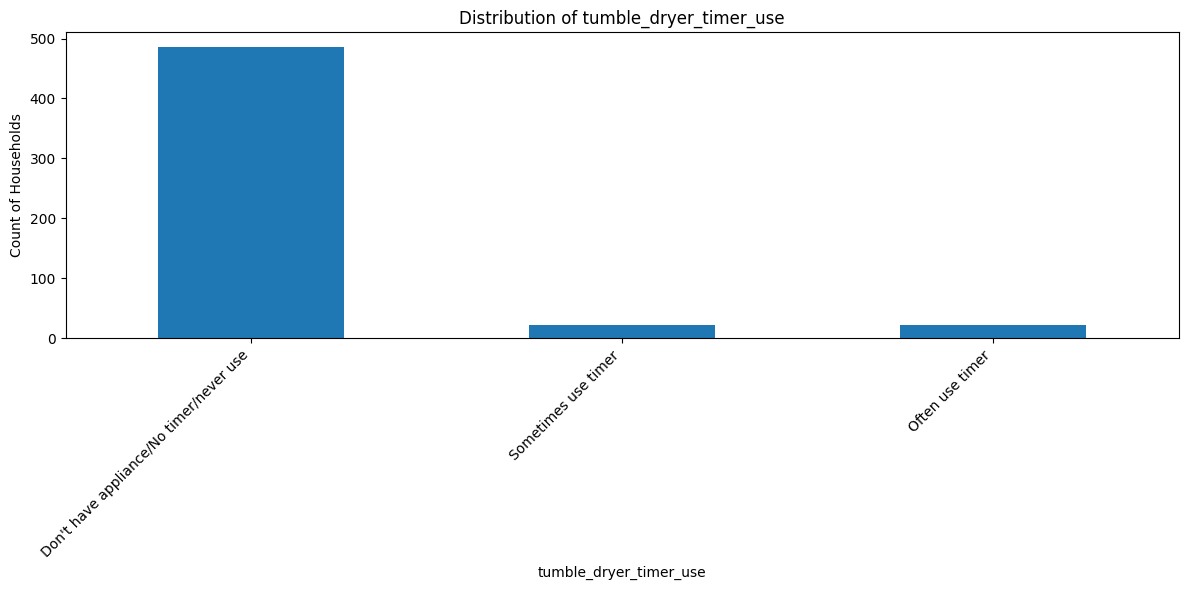


Frequency table for tumble_dryer_timer_use:
Don't have appliance/No timer/never use    0.799342
Sometimes use timer                        0.036184
Often use timer                            0.036184
Name: count, dtype: float64


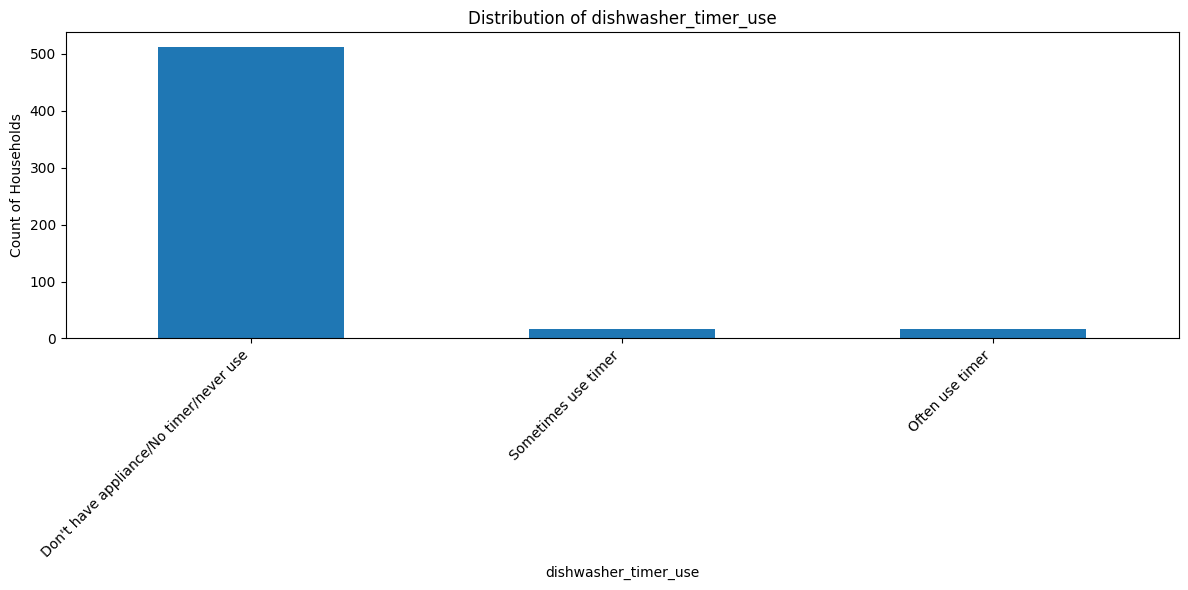


Frequency table for dishwasher_timer_use:
Don't have appliance/No timer/never use    0.842105
Sometimes use timer                        0.026316
Often use timer                            0.027961
Name: count, dtype: float64


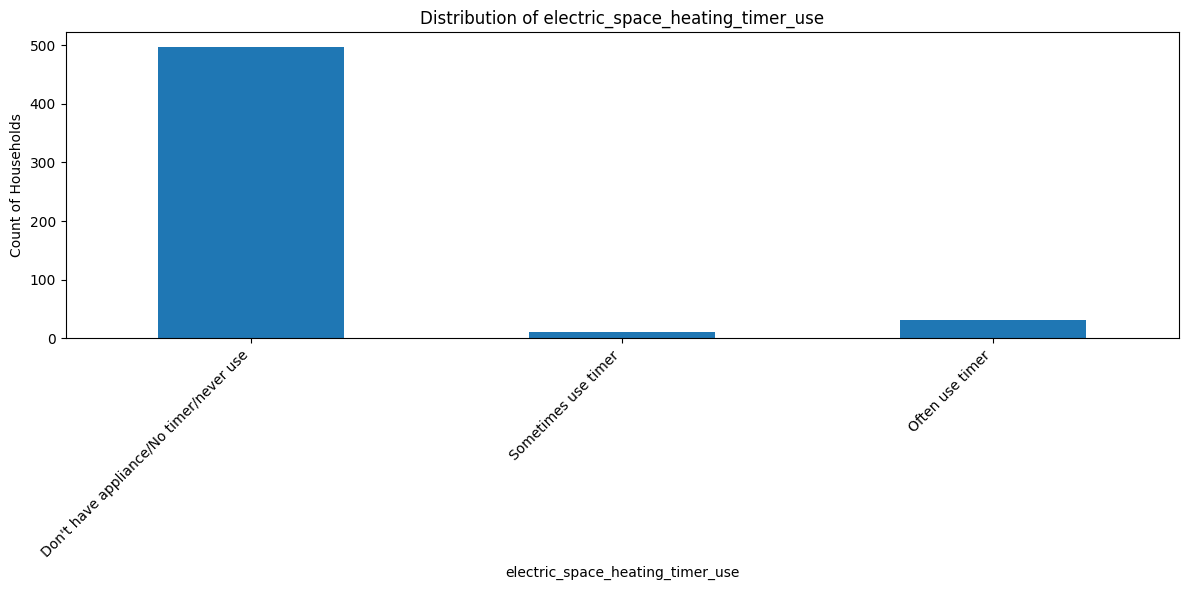


Frequency table for electric_space_heating_timer_use:
Don't have appliance/No timer/never use    0.817434
Sometimes use timer                        0.018092
Often use timer                            0.052632
Name: count, dtype: float64


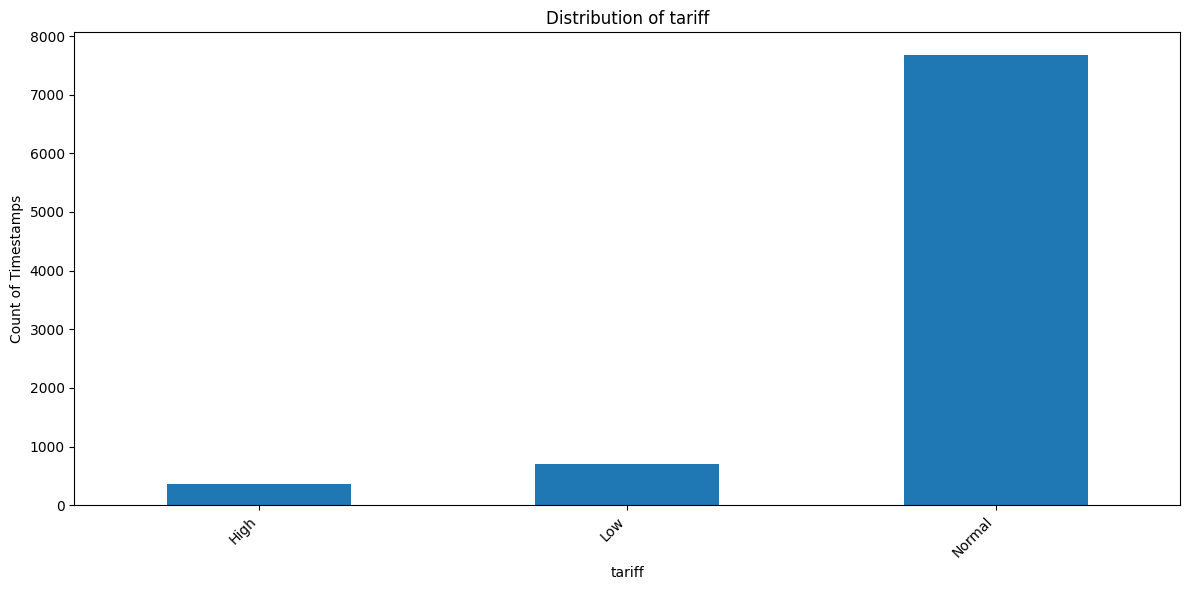


Frequency table for tariff:
tariff
High      0.042242
Low       0.081059
Normal    0.876698
Name: count, dtype: float64


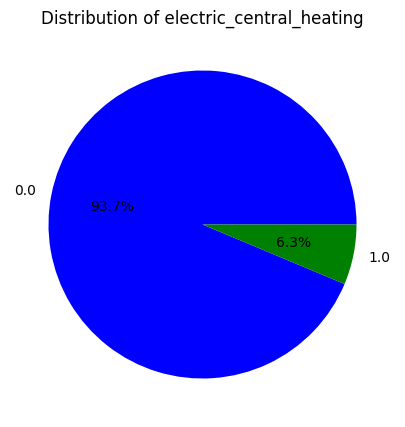


Frequency table for electric_central_heating:
electric_central_heating
0.0    0.93686
1.0    0.06314
Name: proportion, dtype: float64


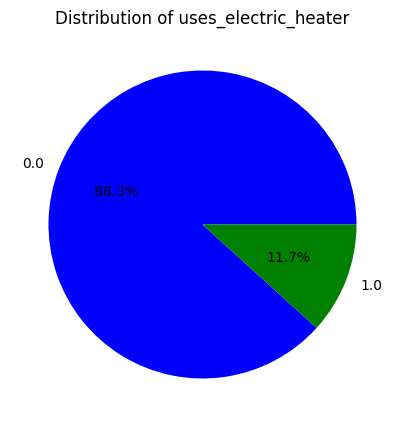


Frequency table for uses_electric_heater:
uses_electric_heater
0.0    0.882759
1.0    0.117241
Name: proportion, dtype: float64


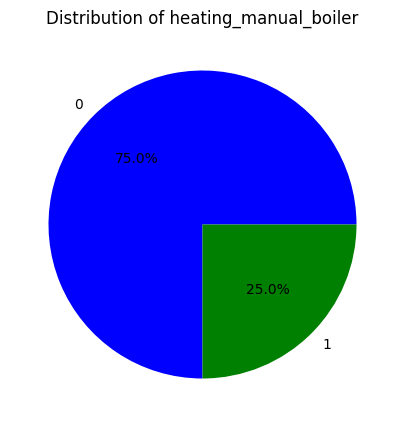


Frequency table for heating_manual_boiler:
heating_manual_boiler
0    0.75
1    0.25
Name: proportion, dtype: float64


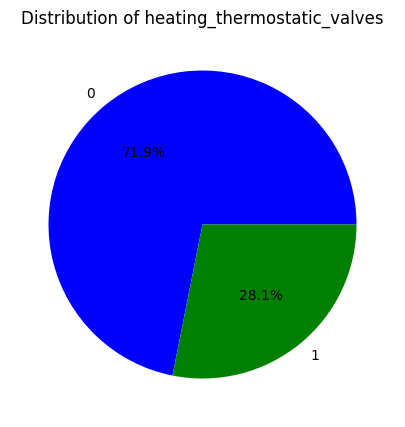


Frequency table for heating_thermostatic_valves:
heating_thermostatic_valves
0    0.71875
1    0.28125
Name: proportion, dtype: float64


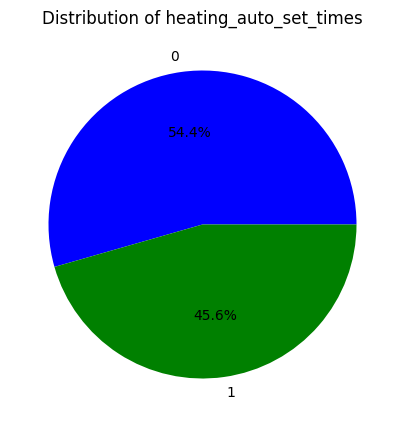


Frequency table for heating_auto_set_times:
heating_auto_set_times
0    0.544408
1    0.455592
Name: proportion, dtype: float64


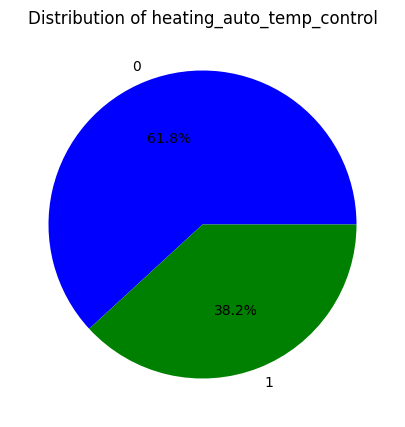


Frequency table for heating_auto_temp_control:
heating_auto_temp_control
0    0.618421
1    0.381579
Name: proportion, dtype: float64


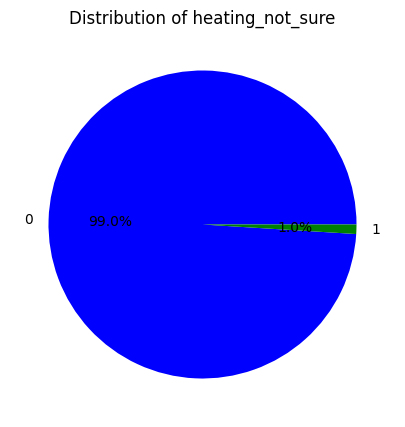


Frequency table for heating_not_sure:
heating_not_sure
0    0.990132
1    0.009868
Name: proportion, dtype: float64


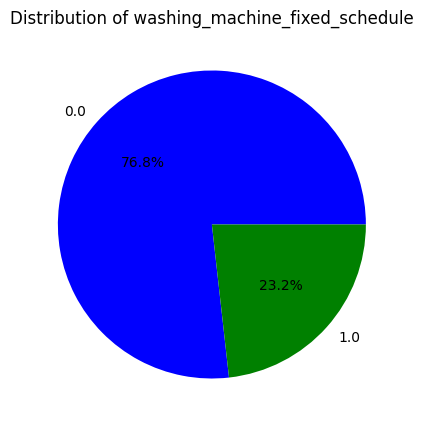


Frequency table for washing_machine_fixed_schedule:
washing_machine_fixed_schedule
0.0    0.767764
1.0    0.232236
Name: proportion, dtype: float64


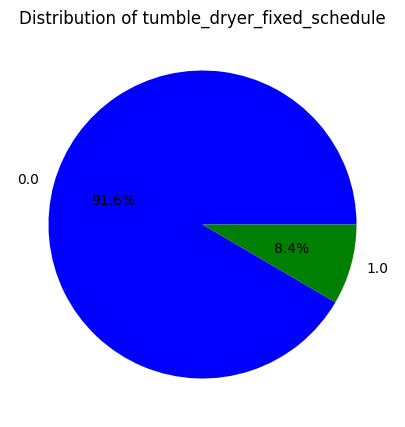


Frequency table for tumble_dryer_fixed_schedule:
tumble_dryer_fixed_schedule
0.0    0.915663
1.0    0.084337
Name: proportion, dtype: float64


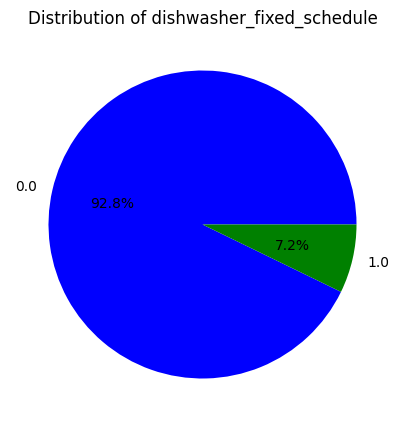


Frequency table for dishwasher_fixed_schedule:
dishwasher_fixed_schedule
0.0    0.927944
1.0    0.072056
Name: proportion, dtype: float64


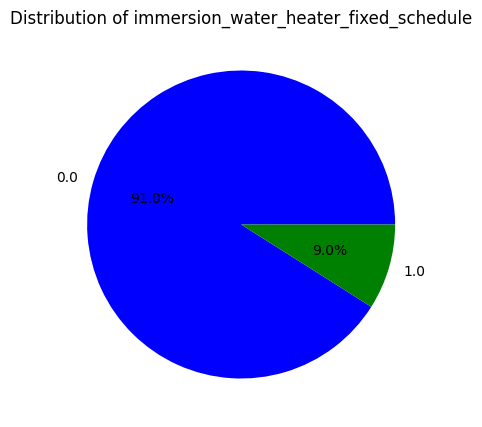


Frequency table for immersion_water_heater_fixed_schedule:
immersion_water_heater_fixed_schedule
0.0    0.910233
1.0    0.089767
Name: proportion, dtype: float64


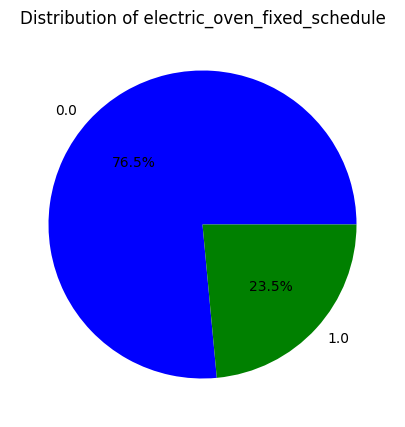


Frequency table for electric_oven_fixed_schedule:
electric_oven_fixed_schedule
0.0    0.764811
1.0    0.235189
Name: proportion, dtype: float64


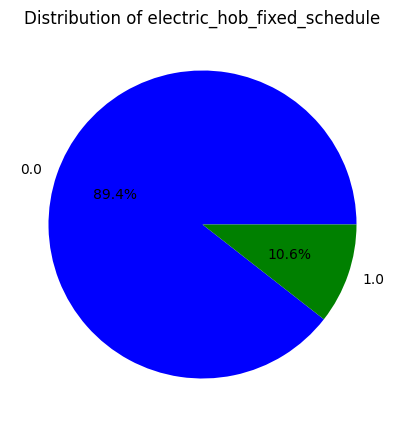


Frequency table for electric_hob_fixed_schedule:
electric_hob_fixed_schedule
0.0    0.894464
1.0    0.105536
Name: proportion, dtype: float64


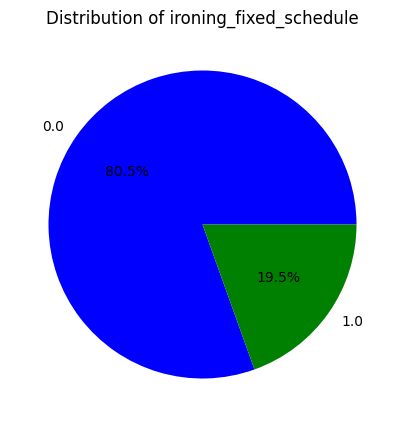


Frequency table for ironing_fixed_schedule:
ironing_fixed_schedule
0.0    0.804781
1.0    0.195219
Name: proportion, dtype: float64


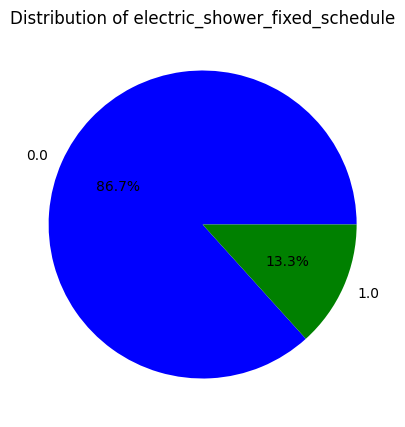


Frequency table for electric_shower_fixed_schedule:
electric_shower_fixed_schedule
0.0    0.8669
1.0    0.1331
Name: proportion, dtype: float64


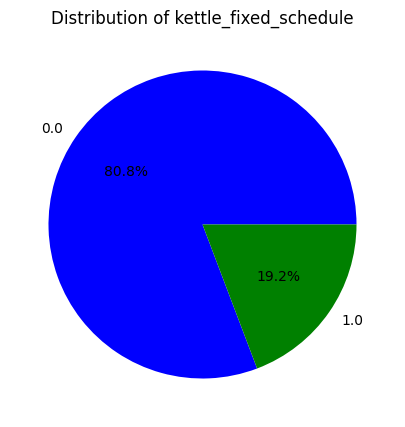


Frequency table for kettle_fixed_schedule:
kettle_fixed_schedule
0.0    0.807692
1.0    0.192308
Name: proportion, dtype: float64


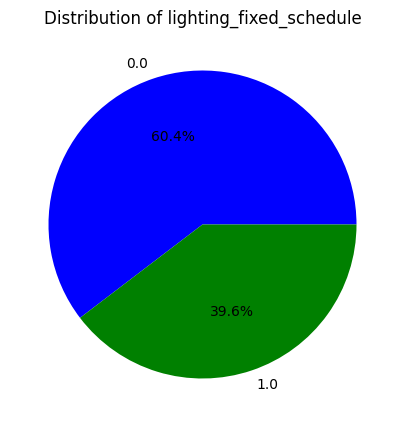


Frequency table for lighting_fixed_schedule:
lighting_fixed_schedule
0.0    0.60367
1.0    0.39633
Name: proportion, dtype: float64


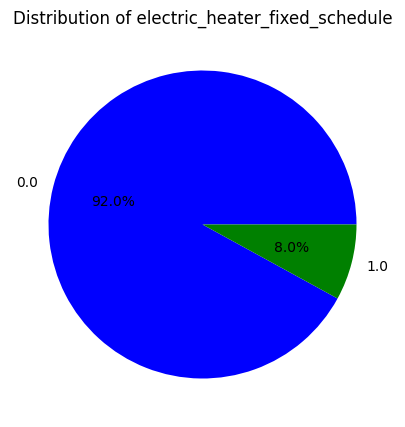


Frequency table for electric_heater_fixed_schedule:
electric_heater_fixed_schedule
0.0    0.920213
1.0    0.079787
Name: proportion, dtype: float64


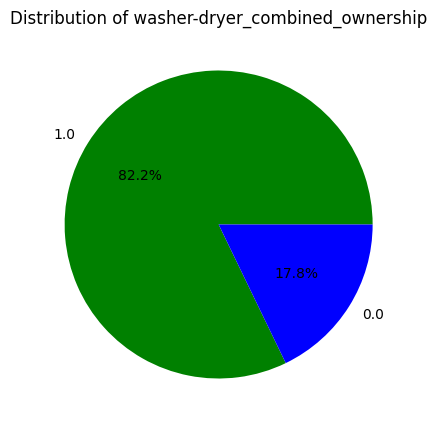


Frequency table for washer-dryer_combined_ownership:
washer-dryer_combined_ownership
1.0    0.821782
0.0    0.178218
Name: proportion, dtype: float64


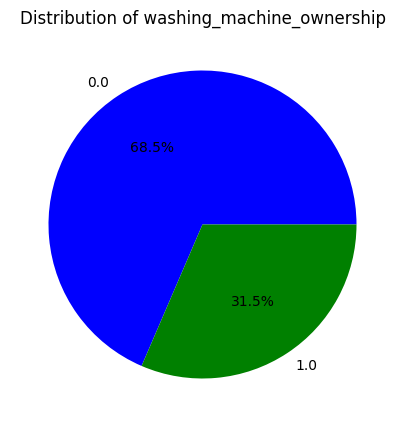


Frequency table for washing_machine_ownership:
washing_machine_ownership
0.0    0.685289
1.0    0.314711
Name: proportion, dtype: float64


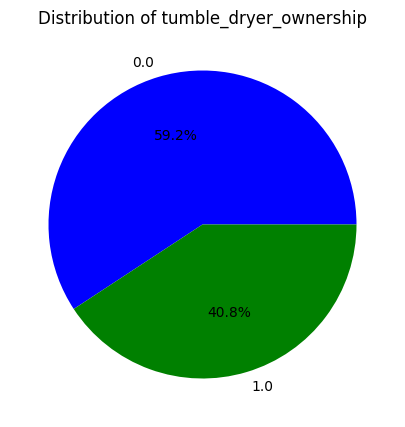


Frequency table for tumble_dryer_ownership:
tumble_dryer_ownership
0.0    0.592453
1.0    0.407547
Name: proportion, dtype: float64


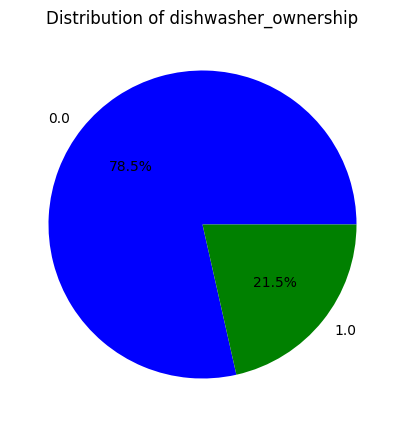


Frequency table for dishwasher_ownership:
dishwasher_ownership
0.0    0.785321
1.0    0.214679
Name: proportion, dtype: float64


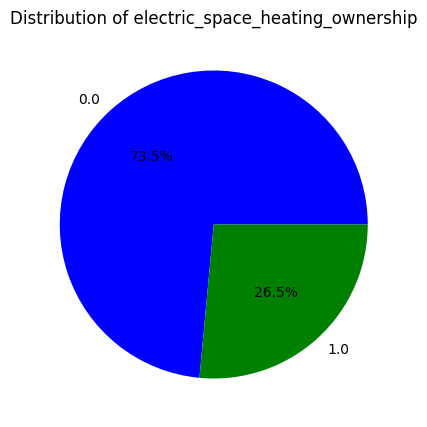


Frequency table for electric_space_heating_ownership:
electric_space_heating_ownership
0.0    0.735185
1.0    0.264815
Name: proportion, dtype: float64


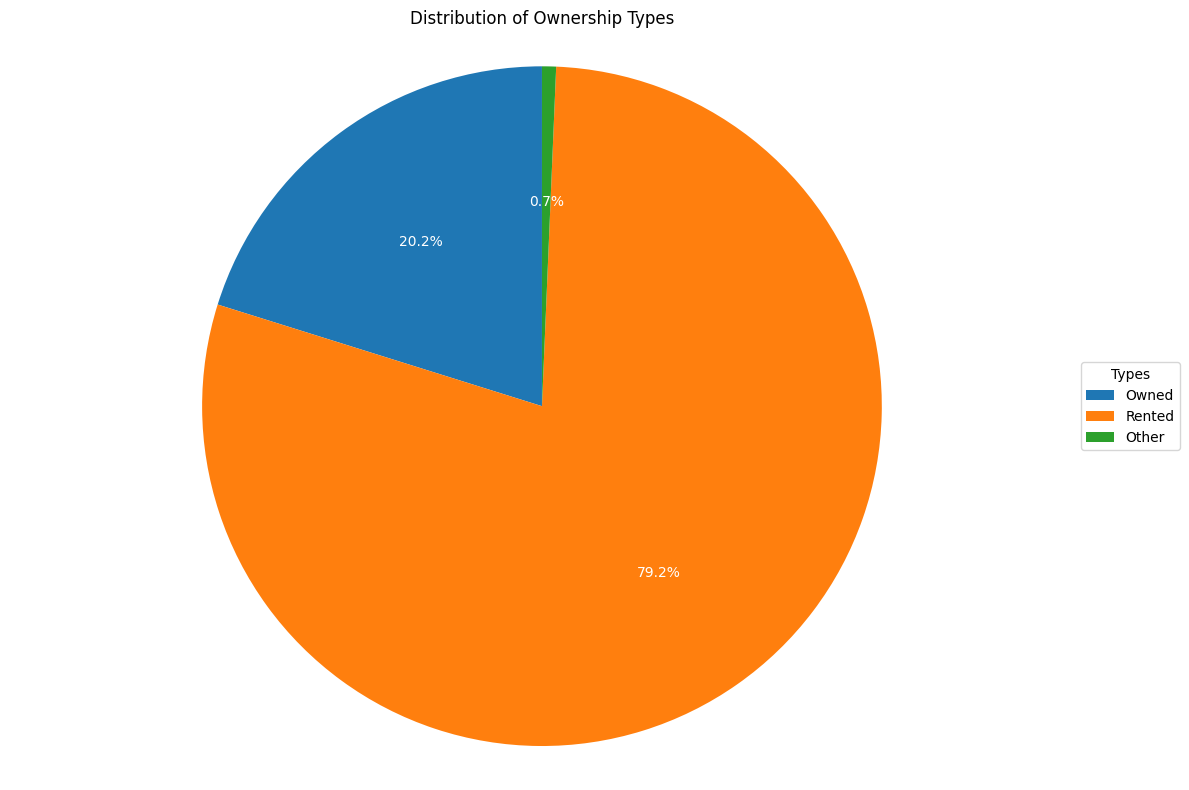


Frequency table for Distribution of Ownership Types:
ownership_owned     0.199013
ownership_rented    0.781250
ownership_other     0.006579
dtype: float64


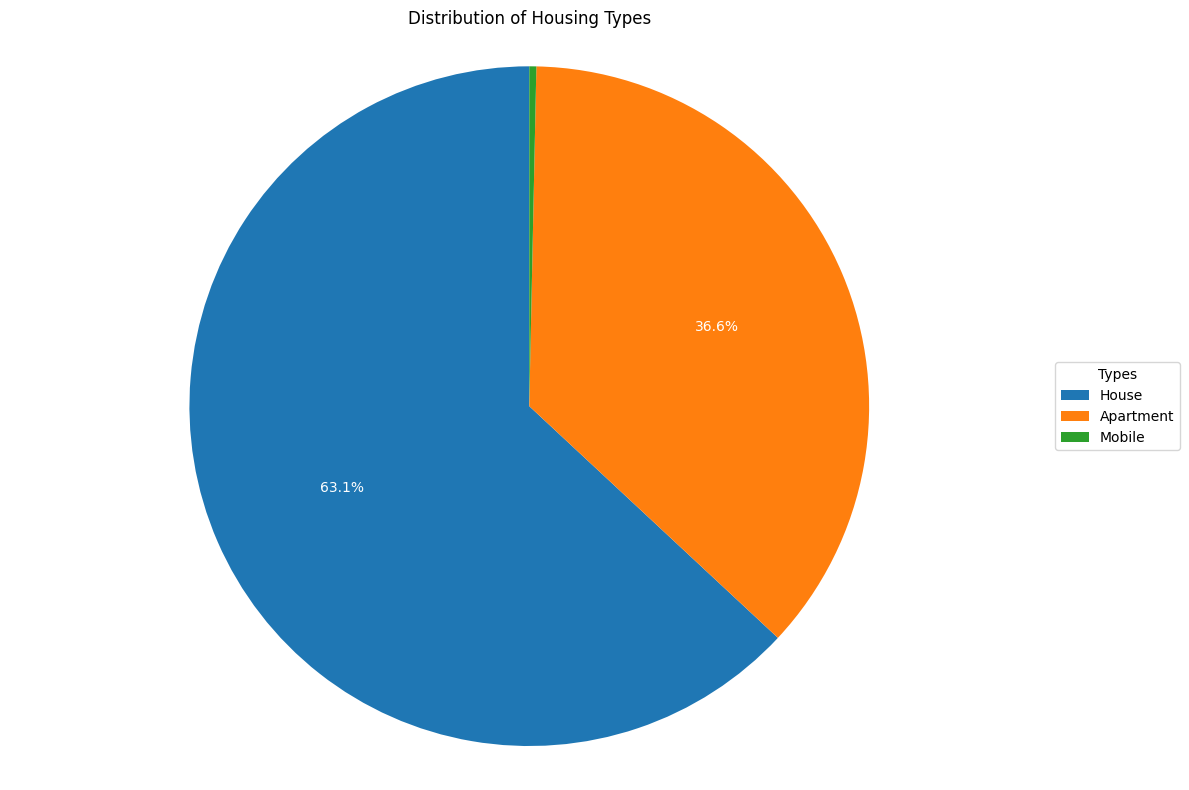


Frequency table for Distribution of Housing Types:
housing_house        0.623355
housing_apartment    0.361842
housing_mobile       0.003289
dtype: float64


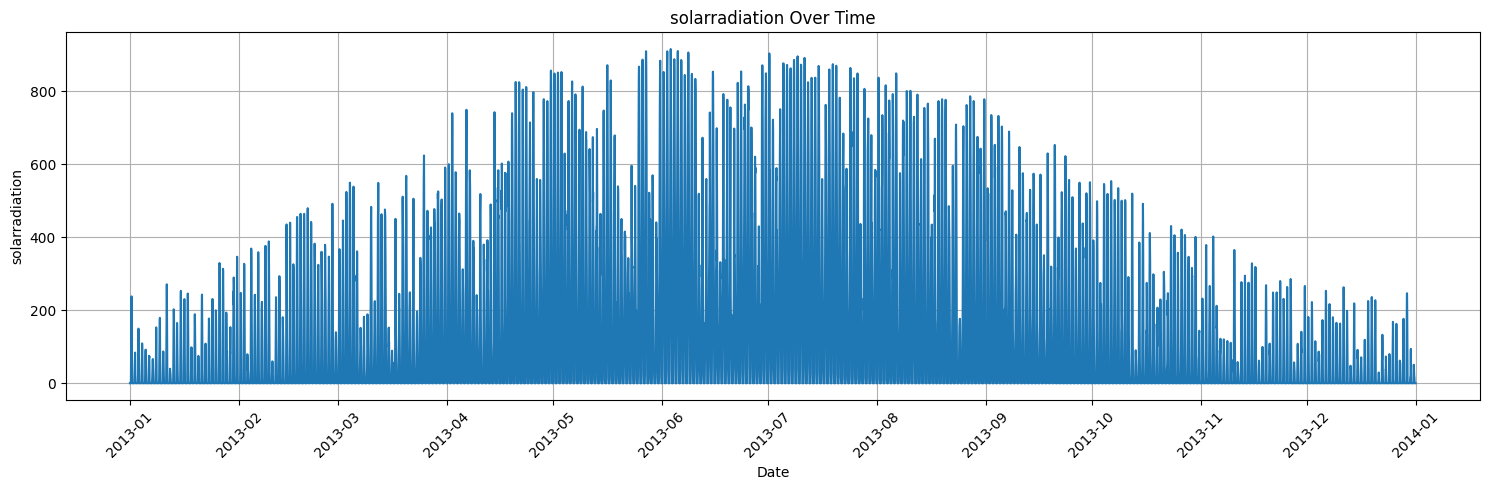


Summary statistics for solarradiation:
count    8759.000000
mean      145.689337
std       224.044008
min         0.000000
25%         0.000000
50%         5.600000
75%       228.100000
max       915.300000
Name: solarradiation, dtype: float64
Number of outliers: 703
Percentage of outliers: 8.03%


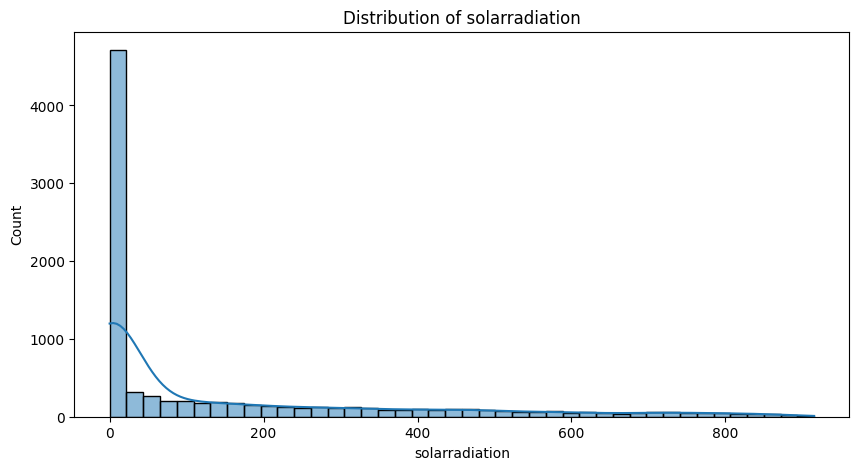

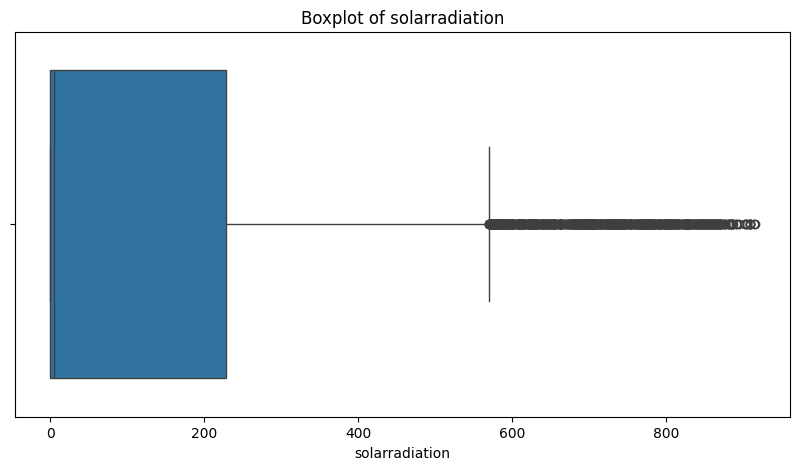

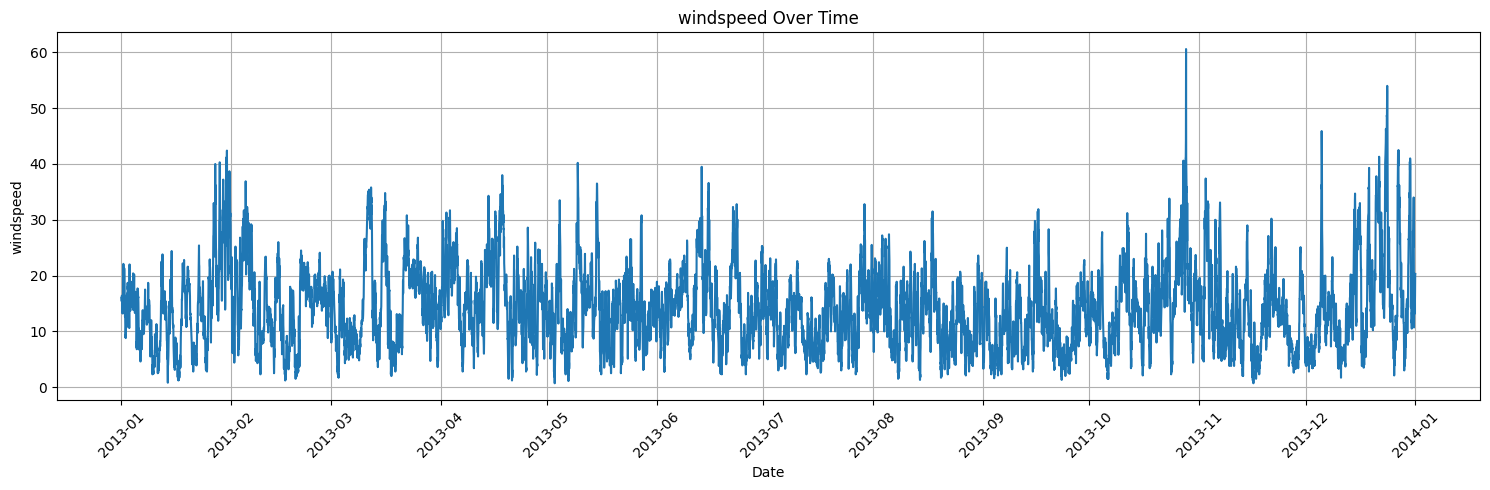


Summary statistics for windspeed:
count    8759.000000
mean       14.219015
std         7.363099
min         0.700000
25%         8.700000
50%        13.400000
75%        18.300000
max        60.600000
Name: windspeed, dtype: float64
Number of outliers: 164
Percentage of outliers: 1.87%


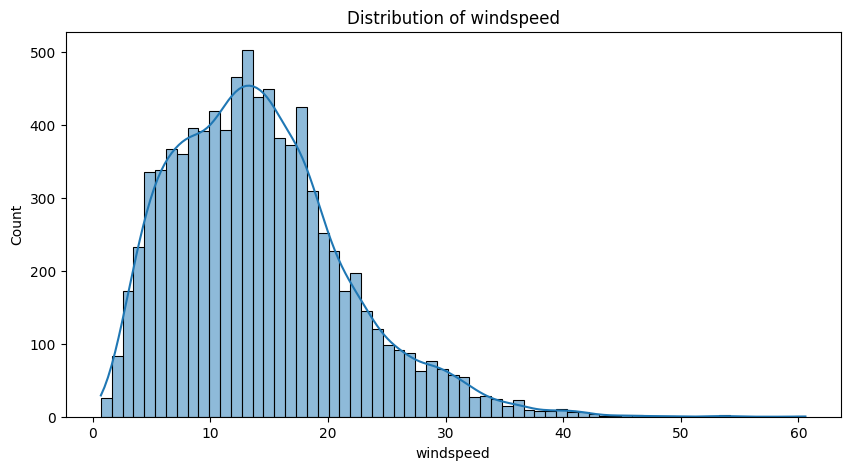

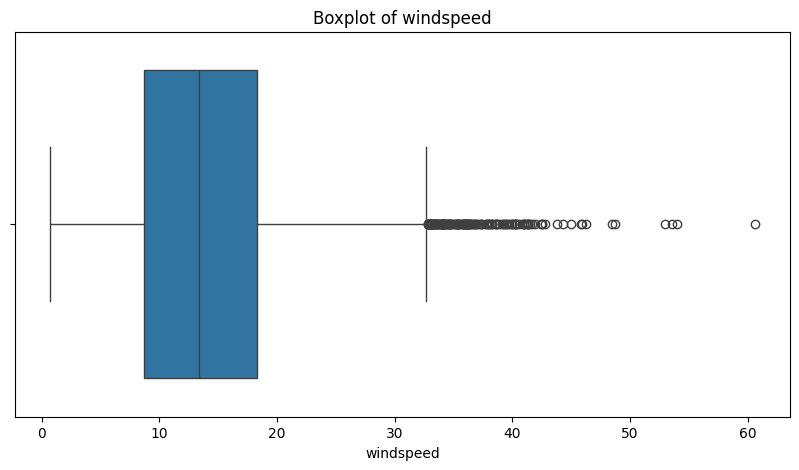

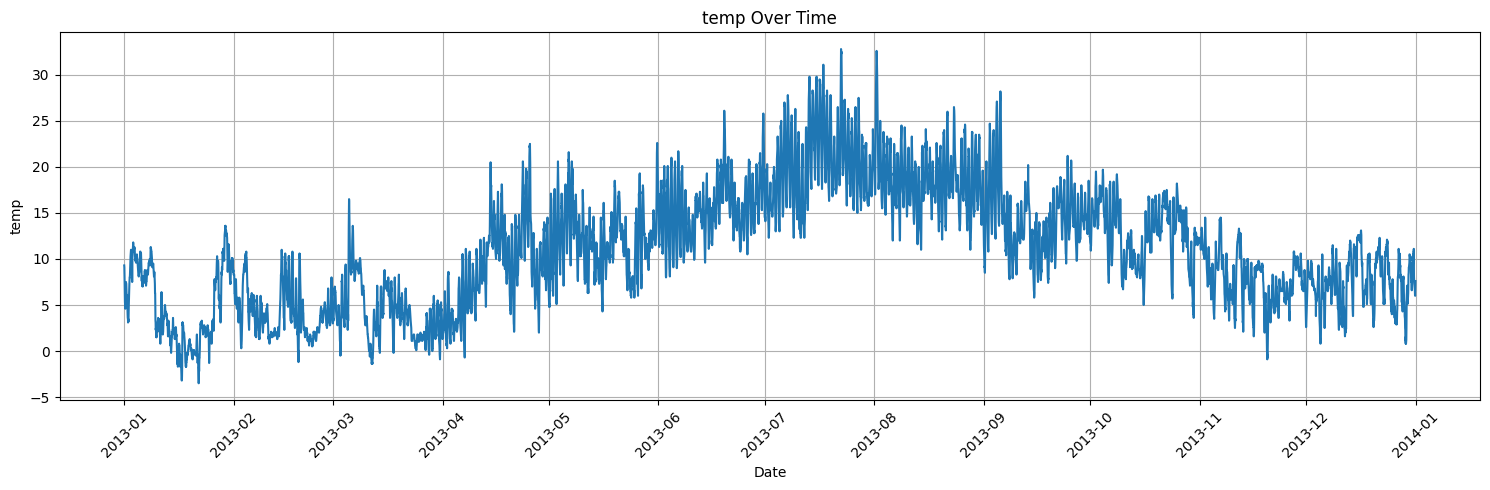


Summary statistics for temp:
count    8759.000000
mean       10.965344
std         6.398952
min        -3.500000
25%         6.100000
50%        10.600000
75%        15.600000
max        32.800000
Name: temp, dtype: float64
Number of outliers: 17
Percentage of outliers: 0.19%


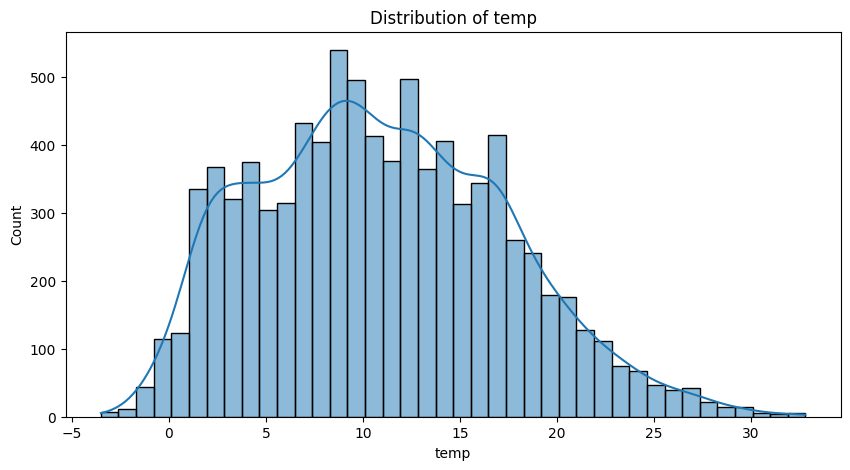

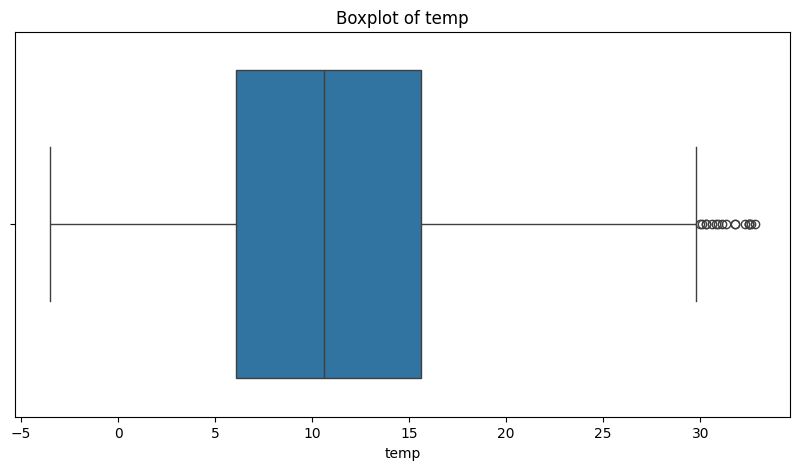

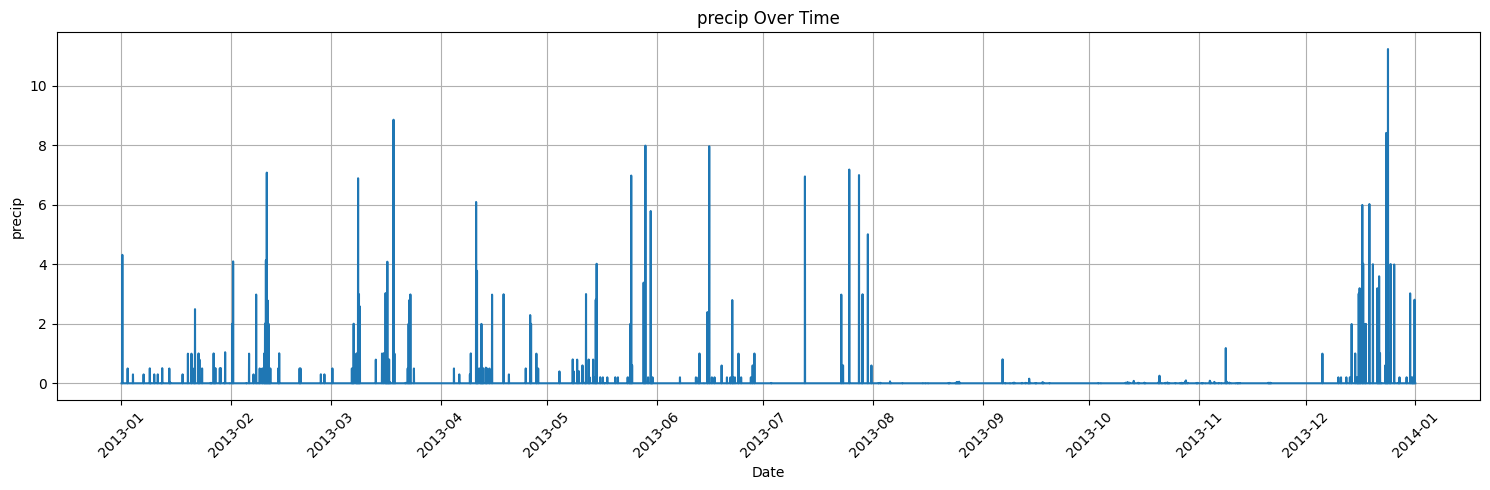


Summary statistics for precip:
count    8759.000000
mean        0.036445
std         0.393491
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        11.235000
Name: precip, dtype: float64
Number of outliers: 452
Percentage of outliers: 5.16%


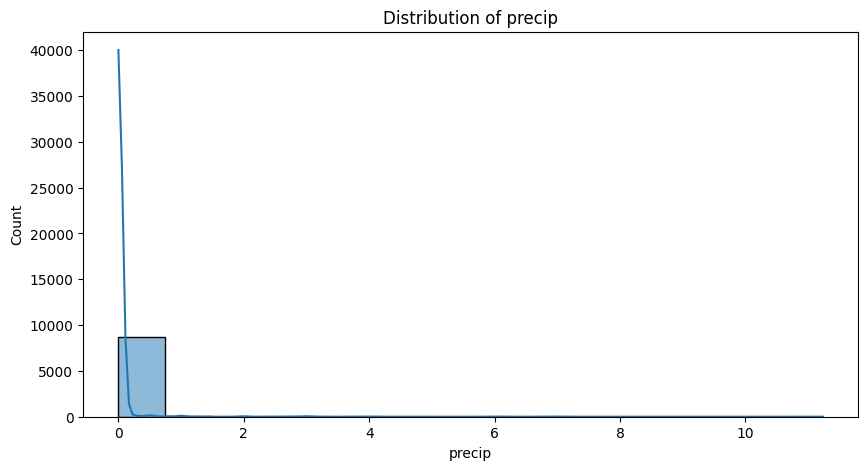

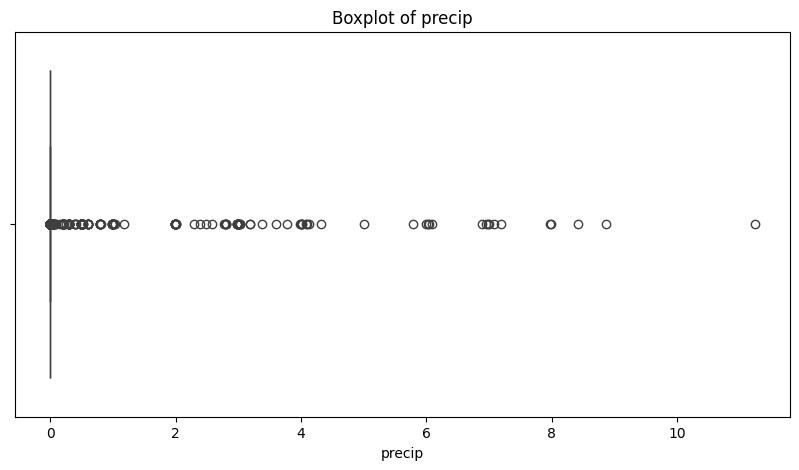

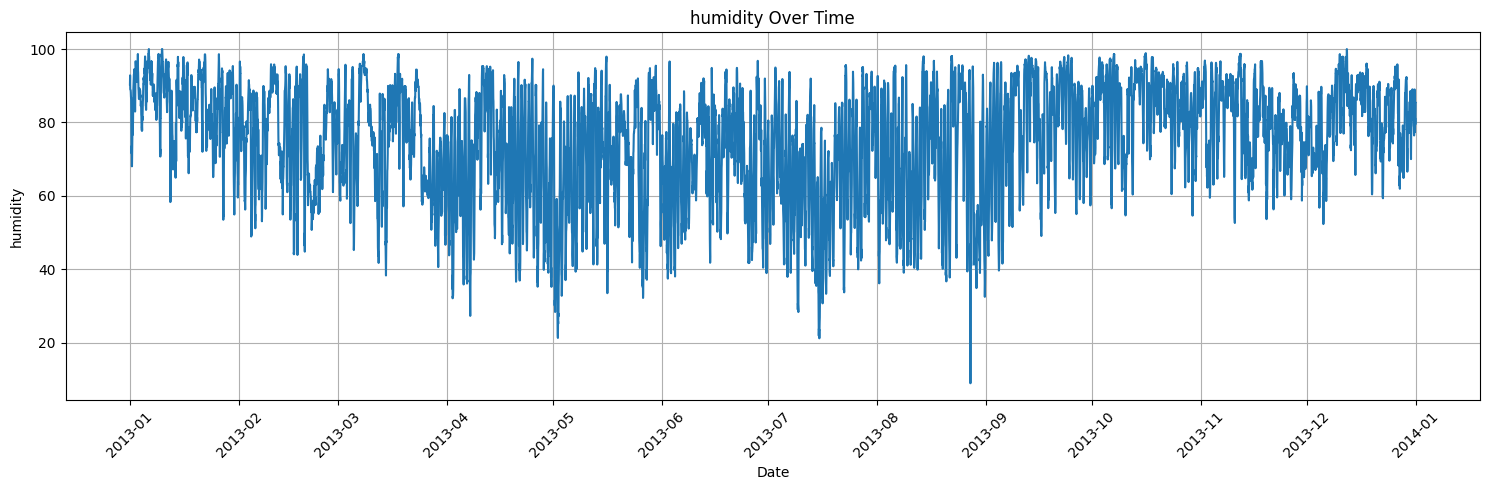


Summary statistics for humidity:
count    8759.000000
mean       75.406681
std        15.198824
min         9.030000
25%        65.690000
50%        78.170000
75%        87.690000
max        99.990000
Name: humidity, dtype: float64
Number of outliers: 38
Percentage of outliers: 0.43%


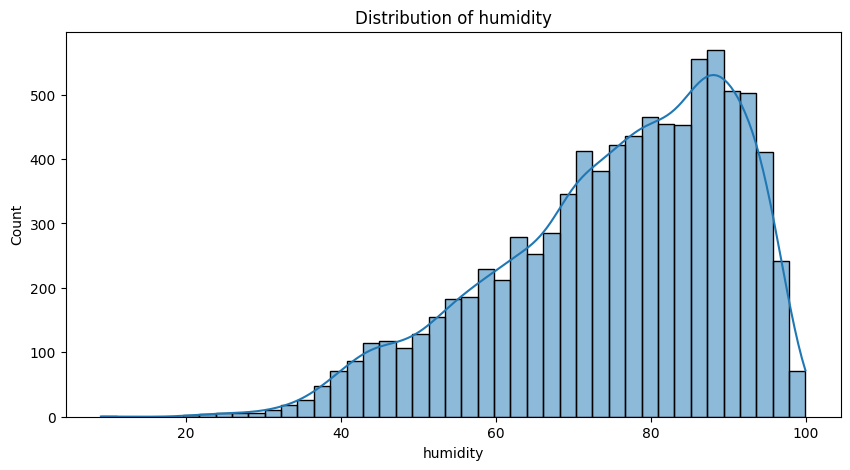

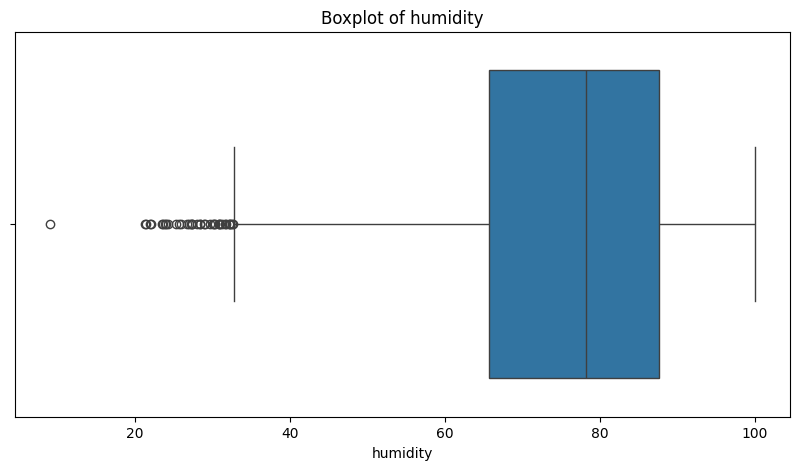

In [6]:
# Plotting
plot_numerical(df_households, df_timestamps, df_merged, numerical_vars)
plot_categorical(df_households, categorical_vars)
plot_timestamp_categorical(df_timestamps, timestamp_categorical_vars)
plot_binary(df_households, binary_vars)
plot_grouped_binary(df_households, 'ownership_', 'Distribution of Ownership Types')
plot_grouped_binary(df_households, 'housing_', 'Distribution of Housing Types')
plot_weather(df_timestamps, weather_vars)

### We will now explore unusual households based on insights from the plots and the summary statistics

In [7]:
def investigate_unusual_households(df_merged, df_households):
    # Calculate average daily consumption per household
    daily_total = df_merged.groupby(['household_id', df_merged['timestamp'].dt.date])['consumption'].sum().reset_index()
    avg_daily_consumption = daily_total.groupby('household_id')['consumption'].mean().reset_index()

    # Calculate average daily peak consumption per household
    daily_peak = df_merged.groupby(['household_id', df_merged['timestamp'].dt.date])['consumption'].max().reset_index()
    avg_daily_peak_consumption = daily_peak.groupby('household_id')['consumption'].mean().reset_index()
    
    # Merge the calculated values into df_households
    df_households = pd.merge(df_households, avg_daily_consumption, on='household_id', suffixes=('', '_avg_daily'))
    df_households = pd.merge(df_households, avg_daily_peak_consumption, on='household_id', suffixes=('', '_avg_peak'))

    unusual_criteria = {
        'High average daily consumption': df_households['consumption_avg_daily'] >= 15,
        'High average daily peak consumption': df_households['consumption_avg_peak'] >= 2,
        'Many rooms': df_households['count_rooms'] >= 10,
        'Many bedrooms': df_households['count_bedrooms'] >= 6,
        'Many high efficiency bulbs': df_households['count_high_efficiency_bulbs'] >= 30,
        'Many low efficiency bulbs': df_households['count_low_efficiency_bulbs'] >= 50,
        'Many fridges and freezers': df_households['count_fridges_and_freezers'] >= 5,
        'Many cooking appliances': df_households['count_cooking_appliances'] > 12,
        'Many entertainment devices': df_households['count_entertainment_devices'] > 15,
        'No rooms': df_households['count_rooms'] == 0,
        'No bedrooms': df_households['count_bedrooms'] == 0,
    }

    base_columns = ['household_id', 'household_size', 'count_rooms', 'count_bedrooms',
                    'count_fridges_and_freezers', 'count_high_efficiency_bulbs', 'count_low_efficiency_bulbs', 
                    'count_cooking_appliances', 'count_entertainment_devices',
                    'consumption_avg_daily', 'consumption_avg_peak']

    for criterion, mask in unusual_criteria.items():
        unusual_households = df_households[mask]
        print(f"\n{criterion}:")
        print(f"Number of unusual households: {len(unusual_households)}")
        
        relevant_feature = criterion.split()[-1].lower()
        if relevant_feature in df_households.columns:
            print(f"\nSummary statistics for {relevant_feature} (all households):")
            print(df_households[relevant_feature].describe())

        if len(unusual_households) > 0:
            print("\nDetailed information for unusual households:")
            print(tabulate(unusual_households[base_columns], headers='keys', tablefmt='pretty', showindex=False))

            # Check for highly unusual inconsistencies
            highly_unusual_inconsistencies = unusual_households[
                ((unusual_households['count_high_efficiency_bulbs'] > 30) & (unusual_households['count_rooms'] < 5)) |
                ((unusual_households['count_fridges_and_freezers'] > 5) & (unusual_households['household_size'] < 3)) |
                ((unusual_households['count_cooking_appliances'] > 12) & (unusual_households['household_size'] < 3)) |
                (unusual_households['count_bedrooms'] > unusual_households['count_rooms']) |
                ((unusual_households['count_high_efficiency_bulbs'] + unusual_households['count_low_efficiency_bulbs']) > 
                (unusual_households['count_rooms'] * 15)) |
                (unusual_households['count_rooms'] == 0) |
                (unusual_households['count_bedrooms'] == 0) |
                (unusual_households['consumption_avg_daily'] > 50) |
                (unusual_households['consumption_avg_peak'] > 10) |
                (unusual_households['count_entertainment_devices'] > unusual_households['household_size'] * 5) |  # Added |
                (unusual_households['count_rooms'] > unusual_households['household_size'] * 10)
            ]

            def get_inconsistency_reason(row):
                reasons = []
                if row['count_high_efficiency_bulbs'] > 30 and row['count_rooms'] < 5:
                    reasons.append('High efficiency bulb count with few rooms')
                if row['count_fridges_and_freezers'] > 5 and row['household_size'] < 3:
                    reasons.append('High fridge/freezer count with small household size')
                if row['count_cooking_appliances'] > 12 and row['household_size'] < 3:
                    reasons.append('High cooking appliances with small household size')
                if row['count_bedrooms'] > row['count_rooms']:
                    reasons.append('More bedrooms than rooms')
                if row['count_rooms'] > 0 and (row['count_high_efficiency_bulbs'] + row['count_low_efficiency_bulbs']) > (row['count_rooms'] * 15):
                    reasons.append('Extremely high bulb count relative to number of rooms')
                if row['count_rooms'] == 0:
                    reasons.append('No rooms')
                if row['count_bedrooms'] == 0:
                    reasons.append('No bedrooms')
                if row['consumption_avg_daily'] > 50:
                    reasons.append('Extremely high average daily consumption')
                if row['consumption_avg_peak'] > 10:
                    reasons.append('Extremely high average daily peak consumption')
                if row['count_entertainment_devices'] > row['household_size'] * 5:
                    reasons.append('Unusually high number of entertainment devices per person')
                if row['count_rooms'] > row['household_size'] * 10:
                    reasons.append('Unusually high number of rooms per person')
                return '; '.join(reasons) if reasons else 'No specific inconsistency'

            highly_unusual_inconsistencies['inconsistency_reason'] = highly_unusual_inconsistencies.apply(get_inconsistency_reason, axis=1)
            
            if not highly_unusual_inconsistencies.empty:
                print("\nPotential highly unusual inconsistencies detected:")
                print(tabulate(highly_unusual_inconsistencies[base_columns + ['inconsistency_reason']], headers='keys', tablefmt='pretty', showindex=False))

# Use the function to investigate unusual households
investigate_unusual_households(df_merged, df_households)


High average daily consumption:
Number of unusual households: 69

Summary statistics for consumption (all households):
count    608.000000
mean       0.347281
std        0.360761
min        0.000000
25%        0.119750
50%        0.236000
75%        0.438500
max        3.095000
Name: consumption, dtype: float64

Detailed information for unusual households:
+--------------+----------------+-------------+----------------+----------------------------+-----------------------------+----------------------------+--------------------------+-----------------------------+-----------------------+----------------------+
| household_id | household_size | count_rooms | count_bedrooms | count_fridges_and_freezers | count_high_efficiency_bulbs | count_low_efficiency_bulbs | count_cooking_appliances | count_entertainment_devices | consumption_avg_daily | consumption_avg_peak |
+--------------+----------------+-------------+----------------+----------------------------+-----------------------------+---

C:\Users\RaiN\AppData\Local\Temp\ipykernel_57776\1722028232.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highly_unusual_inconsistencies['inconsistency_reason'] = highly_unusual_inconsistencies.apply(get_inconsistency_reason, axis=1)
C:\Users\RaiN\AppData\Local\Temp\ipykernel_57776\1722028232.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highly_unusual_inconsistencies['inconsistency_reason'] = highly_unusual_inconsistencies.apply(get_inconsistency_reason, axis=1)
C:\Users\RaiN\AppData\Local\Te

 ### Most households' characteristics look farily reasonable. However, 4 households stand out. 
 ### Let's take a look at the unique highest values for these features of interest to investigate further. Currently, we have:
D1022 with 60 rooms
, D0866 with 5 rooms and 14 bedrooms
, D0558 (household size of 2) with 154 high efficiency bulbs and 32 low efficiency bulbs 
, D0258 (household size of 1) with 11 fridges 

In [8]:
def top_10_unique_values(df, column):
    return df[column].sort_values(ascending=False).drop_duplicates().head(10)

variables = ['count_rooms', 'count_bedrooms', 'count_high_efficiency_bulbs', 'count_low_efficiency_bulbs', 'count_fridges_and_freezers']

for var in variables:
    print(f"\nTop 10 unique highest values for {var}:")
    top_10 = top_10_unique_values(df_households, var)
    for i, value in enumerate(top_10, 1):
        count = df_households[df_households[var] == value].shape[0]
        print(f"{i}. {value} (occurs {count} time{'s' if count > 1 else ''})")



Top 10 unique highest values for count_rooms:
1. 60.0 (occurs 1 time)
2. 12.0 (occurs 2 times)
3. 11.0 (occurs 4 times)
4. 10.0 (occurs 14 times)
5. 9.0 (occurs 19 times)
6. 8.0 (occurs 41 times)
7. 7.0 (occurs 64 times)
8. 6.0 (occurs 114 times)
9. 5.0 (occurs 112 times)
10. 4.0 (occurs 114 times)

Top 10 unique highest values for count_bedrooms:
1. 14.0 (occurs 1 time)
2. 7.0 (occurs 2 times)
3. 6.0 (occurs 5 times)
4. 5.0 (occurs 23 times)
5. 4.0 (occurs 71 times)
6. 3.0 (occurs 232 times)
7. 2.0 (occurs 158 times)
8. 1.0 (occurs 106 times)
9. 0.0 (occurs 7 times)
10. nan (occurs 0 time)

Top 10 unique highest values for count_high_efficiency_bulbs:
1. 154.0 (occurs 1 time)
2. 43.0 (occurs 1 time)
3. 35.0 (occurs 1 time)
4. 33.0 (occurs 1 time)
5. 30.0 (occurs 2 times)
6. 29.0 (occurs 2 times)
7. 28.0 (occurs 1 time)
8. 26.0 (occurs 3 times)
9. 25.0 (occurs 1 time)
10. 24.0 (occurs 3 times)

Top 10 unique highest values for count_low_efficiency_bulbs:
1. 55.0 (occurs 2 times)
2. 53

### The other values in the top 10 do not seem that reasonable for imputation considering the "unusual" households are quite small in size (1 or 2). This likely indicates data entry error. Let's simply remove the leading digit or the trailing zero to fix the error.

In [9]:
# Fix for D1022
# Likely data entry error. Changed 60 rooms to 6 for this residential household.
df_households.loc[df_merged['household_id'] == 'D1022', 'count_rooms'] = 6

# Fix for D0866
# Changed 14 bedrooms to the median as it exceeded the number of rooms (5).
median_bedrooms = df_merged['count_bedrooms'].median()
df_households.loc[df_merged['household_id'] == 'D0866', 'count_bedrooms'] = median_bedrooms

# Fix for D0558
# Likely data entry error. Changed 154 high efficiency bulbs to 54 for this residential household.
df_households.loc[df_merged['household_id'] == 'D0558', 'count_high_efficiency_bulbs'] = 54

# Fix for D0258
# Changed 11 fridges_and_freezers to 1 for a household size of 1.
df_households.loc[df_merged['household_id'] == 'D0258', 'count_fridges_and_freezers'] = 1

### Now let's examine the usually high precipitation values


High Precipitation Events (Precip >= 3):
+---------------------+--------+------+----------+-----------+----------------+
|      timestamp      | precip | temp | humidity | windspeed | solarradiation |
+---------------------+--------+------+----------+-----------+----------------+
| 2013-01-01 06:00:00 | 4.317  | 5.3  |  88.79   |   13.3    |      0.0       |
| 2013-02-01 12:00:00 | 4.097  | 6.3  |  84.07   |   12.2    |     247.4      |
| 2013-02-10 18:00:00 | 4.134  | 2.0  |  91.78   |   23.1    |      0.0       |
| 2013-02-11 00:00:00 | 7.081  | 1.1  |  95.78   |   14.4    |      0.0       |
| 2013-03-08 18:00:00 | 6.891  | 9.8  |  93.51   |    5.3    |      0.0       |
| 2013-03-16 12:00:00 | 3.031  | 6.8  |  84.15   |   23.6    |      62.1      |
| 2013-03-17 00:00:00 | 4.086  | 6.1  |  84.02   |   19.1    |      0.0       |
| 2013-03-18 18:00:00 | 8.859  | 5.1  |  88.18   |    5.7    |      0.0       |
| 2013-04-11 01:00:00 | 6.094  | 7.1  |  94.65   |   19.2    |      0.0       

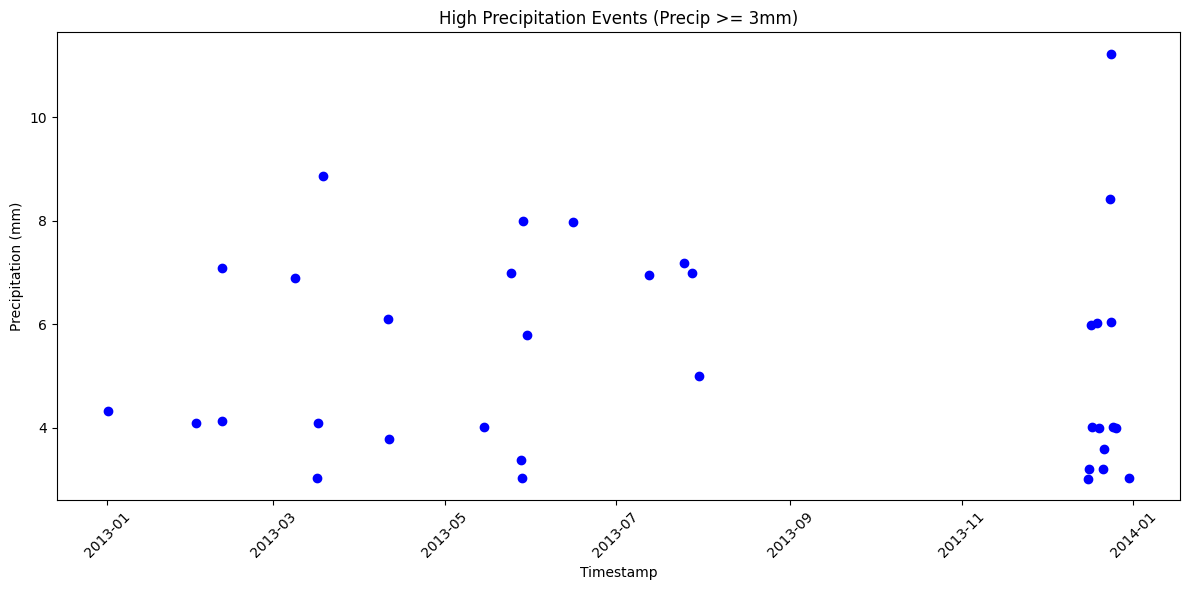

In [10]:
high_precip_events = df_timestamps[df_timestamps['precip'] >= 3]

print("\nHigh Precipitation Events (Precip >= 3):")
print(tabulate(high_precip_events[['timestamp', 'precip', 'temp', 'humidity', 'windspeed', 'solarradiation']], 
                headers='keys', tablefmt='pretty', showindex=False))

# Plot the high precipitation events
plt.figure(figsize=(12, 6))
plt.scatter(high_precip_events['timestamp'], high_precip_events['precip'], color='blue')
plt.title('High Precipitation Events (Precip >= 3mm)')
plt.xlabel('Timestamp')
plt.ylabel('Precipitation (mm)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### The precipitation values look reasonable. The high values coincide with the timing of Cyclone Dirk, which hit the UK in December 2013. 


### We also have 11 households with no rooms or bedrooms. Considering we only have 11, let's just do a quick fix. We will set all zeroes to 1 for count_bedrooms and set all zeroes in the count_rooms to match count_bedrooms.

In [11]:
# Set all zeroes in count_bedrooms to 1
df_households.loc[df_households['count_bedrooms'] == 0, 'count_bedrooms'] = 1

# Set all zeroes in count_rooms to match count_bedrooms
df_households.loc[df_households['count_rooms'] == 0, 'count_rooms'] = df_households['count_bedrooms']


### Imputation- Let's first take care of the static household characteristics. We only need to impute for static characteristics (characteristics that do not differ across timestamps)

In [12]:
# Define the list of static columns, excluding weather variables
static_cols = [col for col in df_households.columns if col not in ['household_id', 'timestamp', 'consumption', 'tariff', 'solarradiation', 'windspeed', 'temp', 'precip', 'humidity']]

# Define the list of columns to scale (numerical and count variables that are also static)
scale_cols = [col for col in (numerical_vars + count_vars) if col in static_cols]

# Get the number of missing values before imputation
missing_values_before_by_column = df_households[static_cols].isnull().sum()
print("Number of missing values before imputation by column:")
print(missing_values_before_by_column)

missing_values_before_total = missing_values_before_by_column.sum()
print(f"Total number of missing values before imputation: {missing_values_before_total}")

# Scale the static numerical and count variables
scaler = StandardScaler()
df_households_scaled = df_households.copy()
df_households_scaled[scale_cols] = scaler.fit_transform(df_households[scale_cols])

# Perform imputation
imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=200, random_state=1)
df_households_imputed_scaled = pd.DataFrame(imputer.fit_transform(df_households_scaled[static_cols]), 
                                            columns=static_cols, 
                                            index=df_households.index)

# Reverse the scaling for static numerical and count variables
df_households_imputed = df_households_imputed_scaled.copy()
df_households_imputed[scale_cols] = scaler.inverse_transform(df_households_imputed_scaled[scale_cols])

# Add back the household_id column
df_households_imputed['household_id'] = df_households['household_id']

# Post-processing for binary and categorical variables
for var in binary_vars + categorical_vars:
    df_households_imputed[var] = np.round(df_households_imputed[var]).astype(int)

# Integer and non-negative constraints for count variables
for var in count_vars:
    df_households_imputed[var] = np.round(df_households_imputed[var]).astype(int)
    df_households_imputed[var] = df_households_imputed[var].clip(lower=0)

# Get the number of missing values after imputation
missing_values_after = df_households_imputed[static_cols].isnull().sum().sum()
print(f"Number of missing values after imputation: {missing_values_after}")

Number of missing values before imputation by column:
washing_machine_fixed_schedule           31
tumble_dryer_fixed_schedule              27
dishwasher_fixed_schedule                39
immersion_water_heater_fixed_schedule    51
electric_oven_fixed_schedule             51
                                         ..
interest_in_microgeneration               8
climate_change_concern                    4
lifestyle_environment                     3
smart_meter_bill_understanding            9
smart_meter_consumption_understanding     8
Length: 63, dtype: int64
Total number of missing values before imputation: 1470
Number of missing values after imputation: 0


### Visualisation of Household Features (Post-imputation)

In [13]:
# Function to plot numerical variables after imputation
def plot_numerical_post_imputation(df, vars):
    for var in vars:
        if var in df.columns and var != 'consumption':
            plt.figure(figsize=(15, 5))
            
            # Create subplot for boxplot
            plt.subplot(1, 2, 1)
            sns.boxplot(x=df[var])
            plt.title(f'Boxplot of {var}')
            plt.xlabel(var)
            
            # Create subplot for histogram
            plt.subplot(1, 2, 2)
            sns.histplot(df[var], kde=True)
            plt.title(f'Histogram of {var}')
            plt.xlabel(var)
            
            plt.tight_layout()
            plt.show()
            
            # Print summary statistics
            print(f"\nSummary statistics for {var}:")
            print(df[var].describe())
            
            # Calculate and print outlier information
            Q1 = df[var].quantile(0.25)
            Q3 = df[var].quantile(0.75)
            IQR = Q3 - Q1
            outliers = df[(df[var] < (Q1 - 1.5 * IQR)) | (df[var] > (Q3 + 1.5 * IQR))]
            print(f"Number of outliers: {len(outliers)}")
            print(f"Percentage of outliers: {len(outliers) / len(df) * 100:.2f}%")
            
            if var in count_vars:
                print(f"\nCount information for {var}:")
                print(f"Minimum count: {df[var].min()}")
                print(f"Maximum count: {df[var].max()}")
                print(f"Mode: {df[var].mode().values[0]}")

Post Imputation


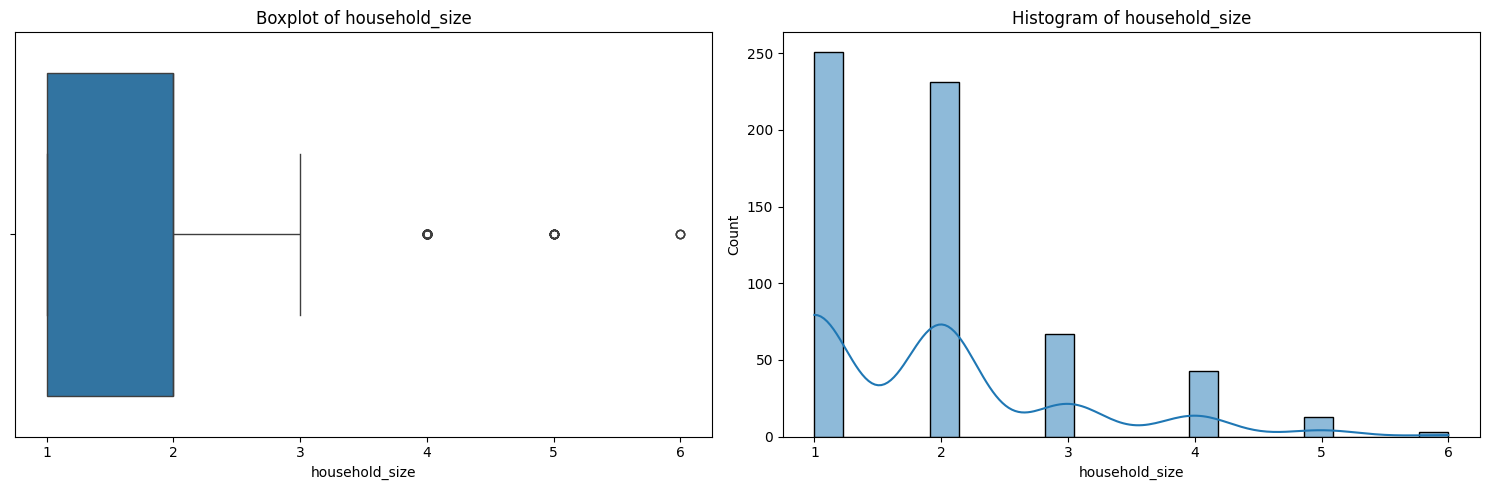


Summary statistics for household_size:
count    608.000000
mean       1.922697
std        1.035901
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        6.000000
Name: household_size, dtype: float64
Number of outliers: 59
Percentage of outliers: 9.70%

Count information for household_size:
Minimum count: 1
Maximum count: 6
Mode: 1


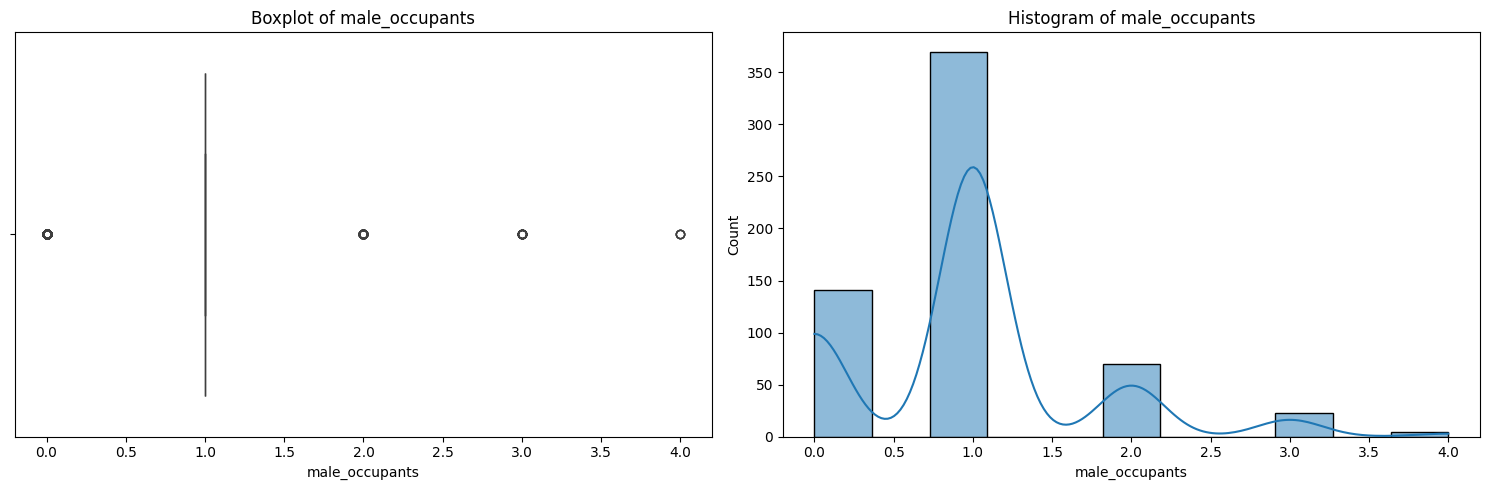


Summary statistics for male_occupants:
count    608.000000
mean       0.978618
std        0.747012
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        4.000000
Name: male_occupants, dtype: float64
Number of outliers: 238
Percentage of outliers: 39.14%

Count information for male_occupants:
Minimum count: 0
Maximum count: 4
Mode: 1


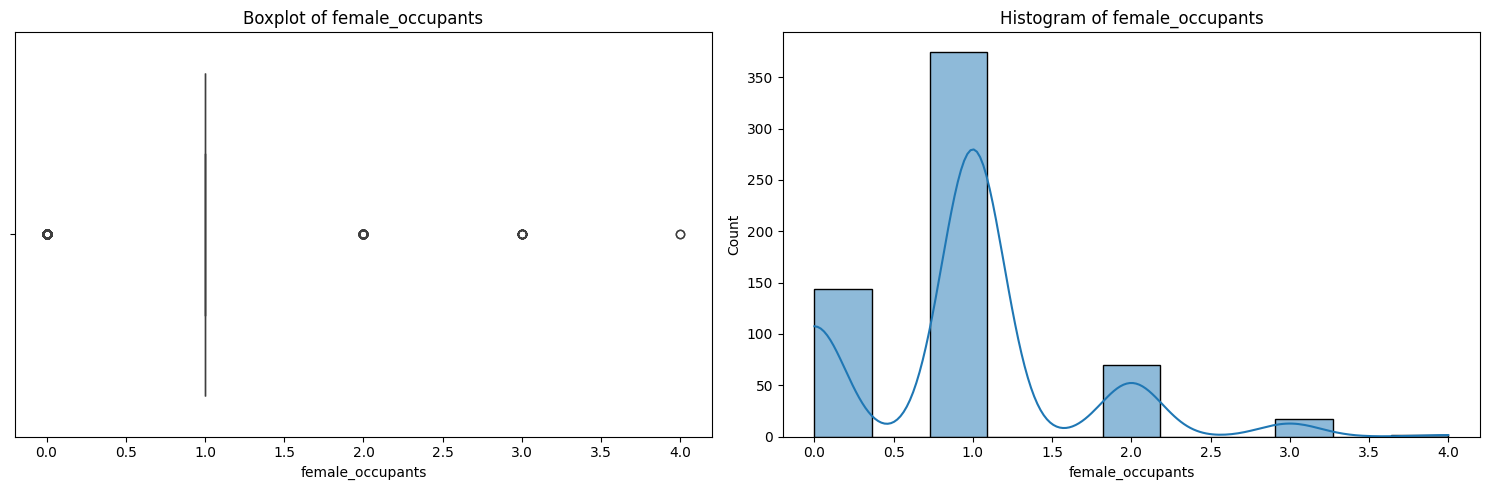


Summary statistics for female_occupants:
count    608.000000
mean       0.944079
std        0.700786
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        4.000000
Name: female_occupants, dtype: float64
Number of outliers: 233
Percentage of outliers: 38.32%

Count information for female_occupants:
Minimum count: 0
Maximum count: 4
Mode: 1


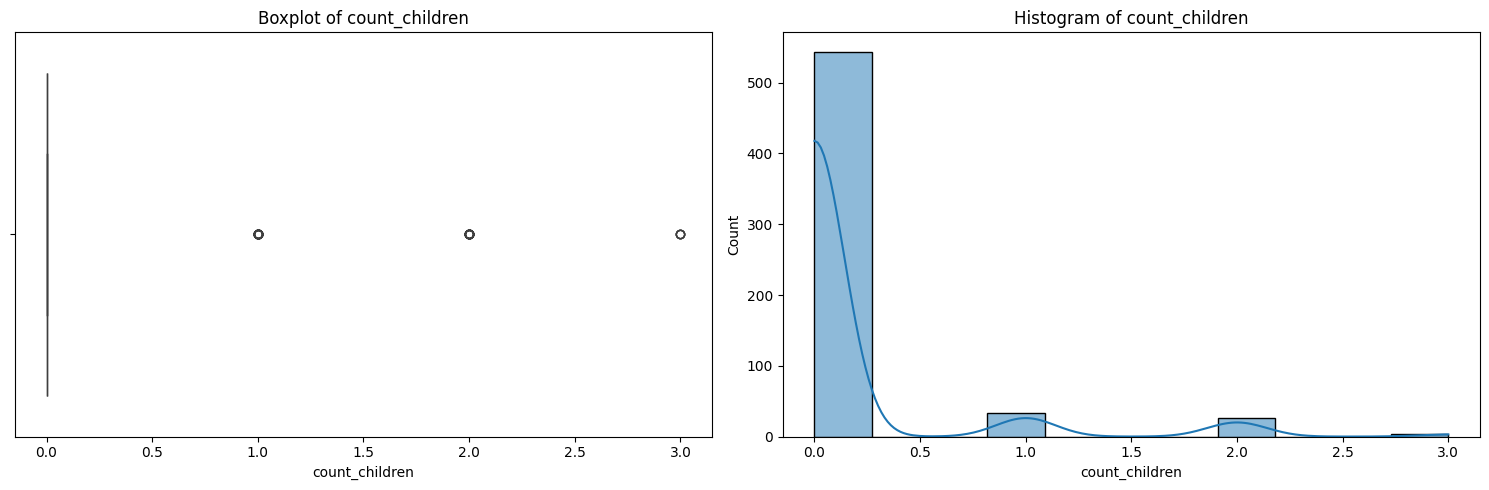


Summary statistics for count_children:
count    608.000000
mean       0.161184
std        0.510522
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: count_children, dtype: float64
Number of outliers: 64
Percentage of outliers: 10.53%

Count information for count_children:
Minimum count: 0
Maximum count: 3
Mode: 0


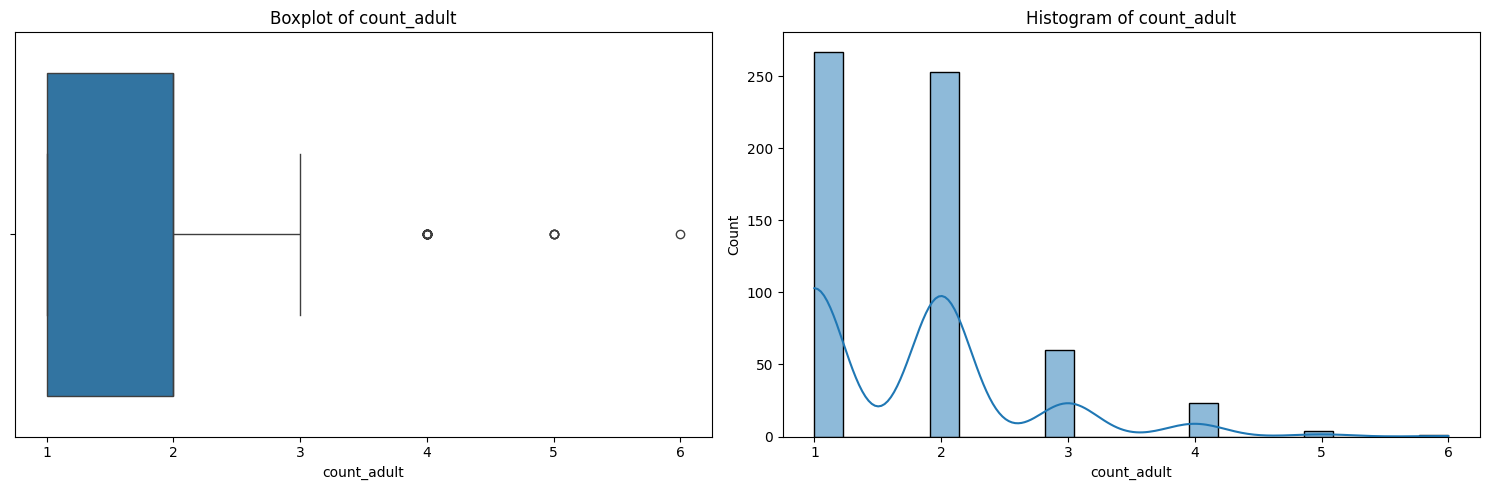


Summary statistics for count_adult:
count    608.000000
mean       1.761513
std        0.847925
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        6.000000
Name: count_adult, dtype: float64
Number of outliers: 28
Percentage of outliers: 4.61%

Count information for count_adult:
Minimum count: 1
Maximum count: 6
Mode: 1


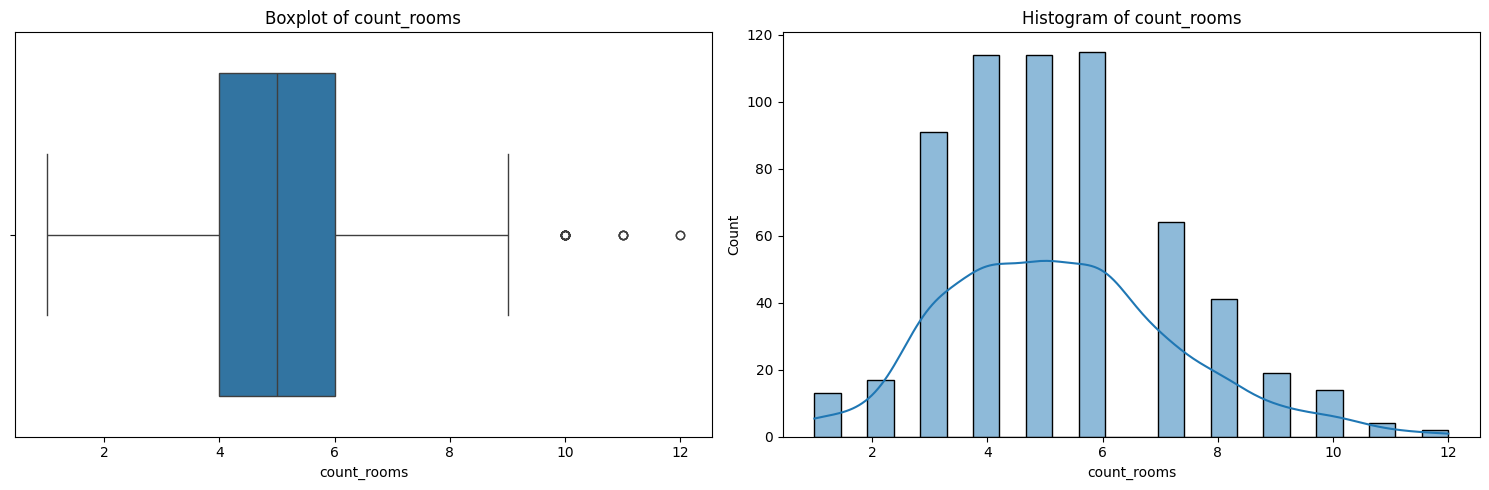


Summary statistics for count_rooms:
count    608.000000
mean       5.248355
std        2.003908
min        1.000000
25%        4.000000
50%        5.000000
75%        6.000000
max       12.000000
Name: count_rooms, dtype: float64
Number of outliers: 20
Percentage of outliers: 3.29%

Count information for count_rooms:
Minimum count: 1
Maximum count: 12
Mode: 6


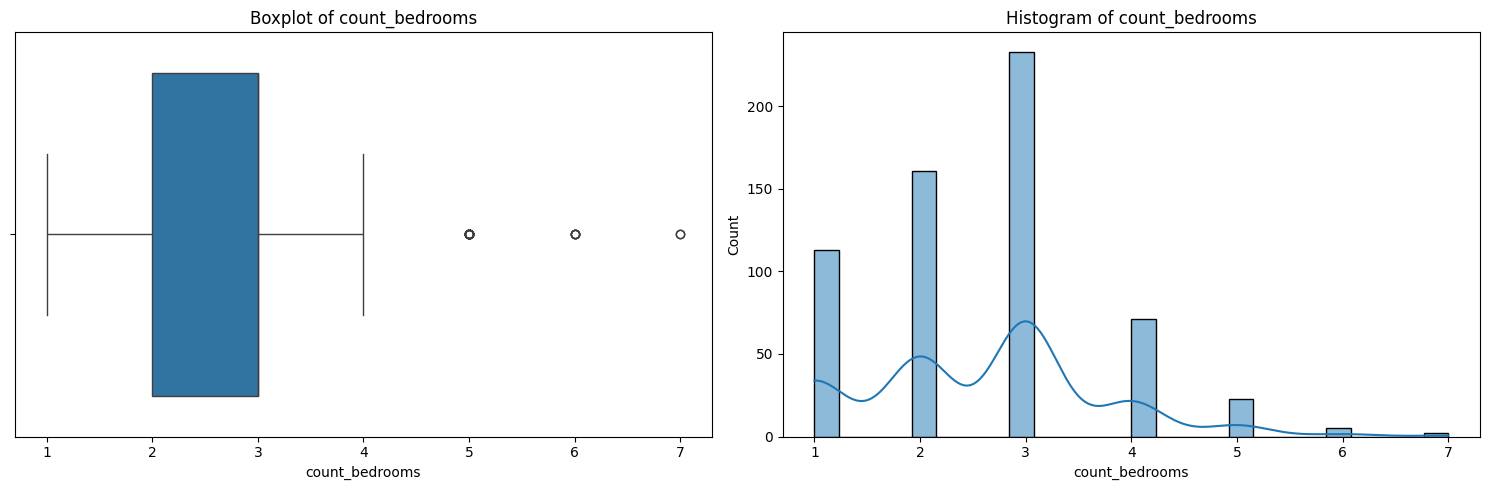


Summary statistics for count_bedrooms:
count    608.000000
mean       2.593750
std        1.113535
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        7.000000
Name: count_bedrooms, dtype: float64
Number of outliers: 30
Percentage of outliers: 4.93%

Count information for count_bedrooms:
Minimum count: 1
Maximum count: 7
Mode: 3


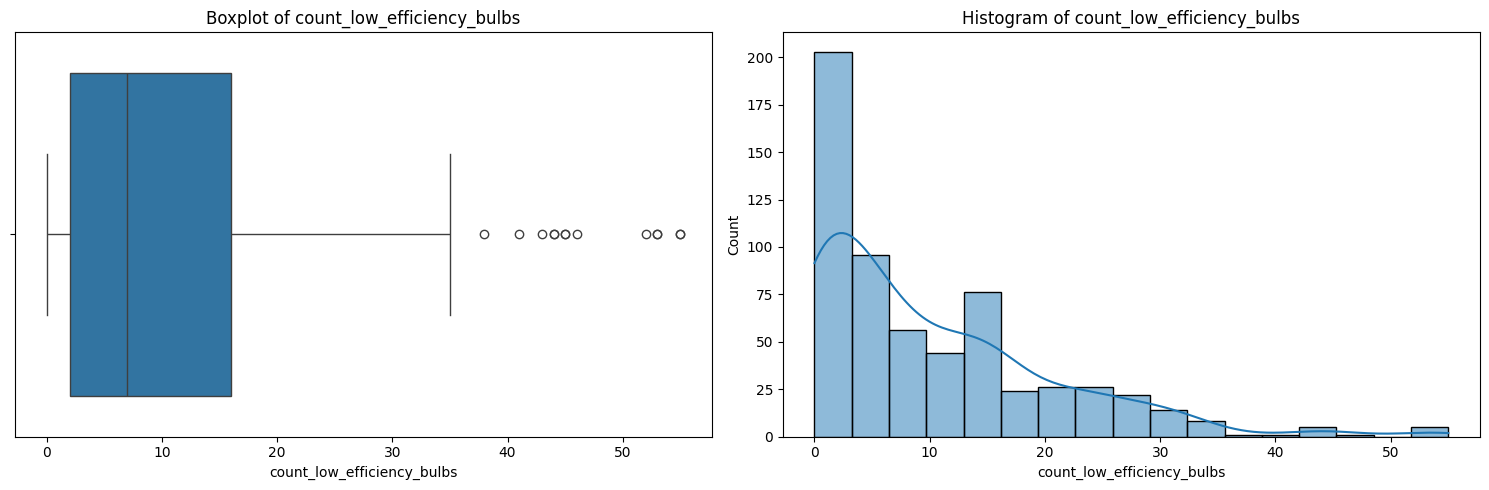


Summary statistics for count_low_efficiency_bulbs:
count    608.000000
mean      10.228618
std       10.494623
min        0.000000
25%        2.000000
50%        7.000000
75%       16.000000
max       55.000000
Name: count_low_efficiency_bulbs, dtype: float64
Number of outliers: 13
Percentage of outliers: 2.14%

Count information for count_low_efficiency_bulbs:
Minimum count: 0
Maximum count: 55
Mode: 0


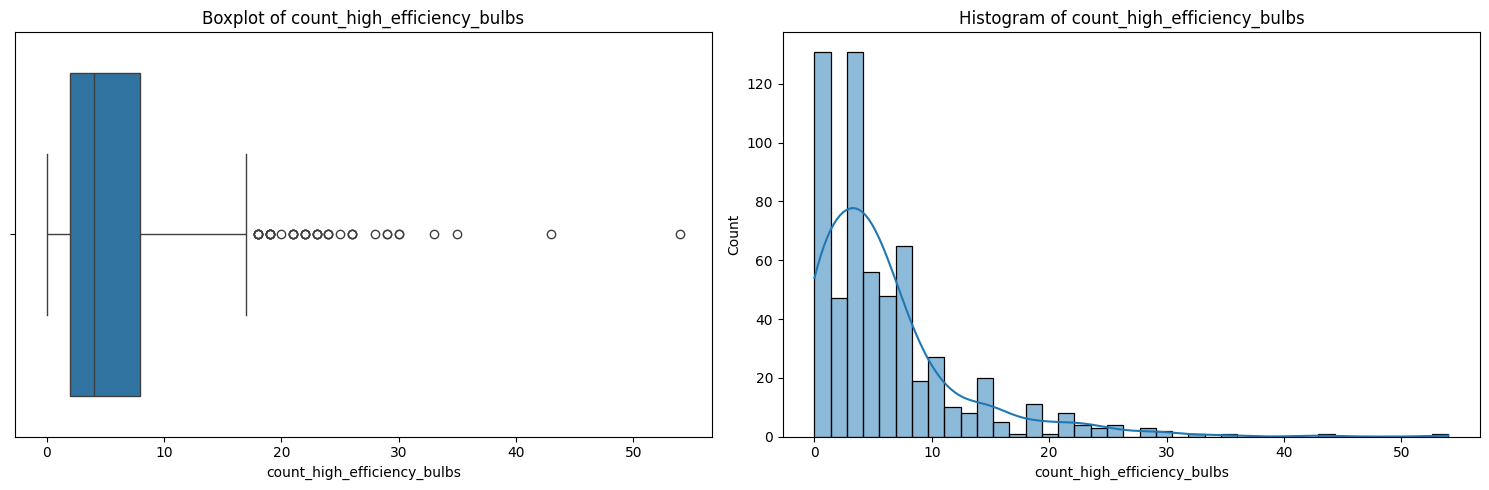


Summary statistics for count_high_efficiency_bulbs:
count    608.000000
mean       6.037829
std        6.447626
min        0.000000
25%        2.000000
50%        4.000000
75%        8.000000
max       54.000000
Name: count_high_efficiency_bulbs, dtype: float64
Number of outliers: 40
Percentage of outliers: 6.58%

Count information for count_high_efficiency_bulbs:
Minimum count: 0
Maximum count: 54
Mode: 0


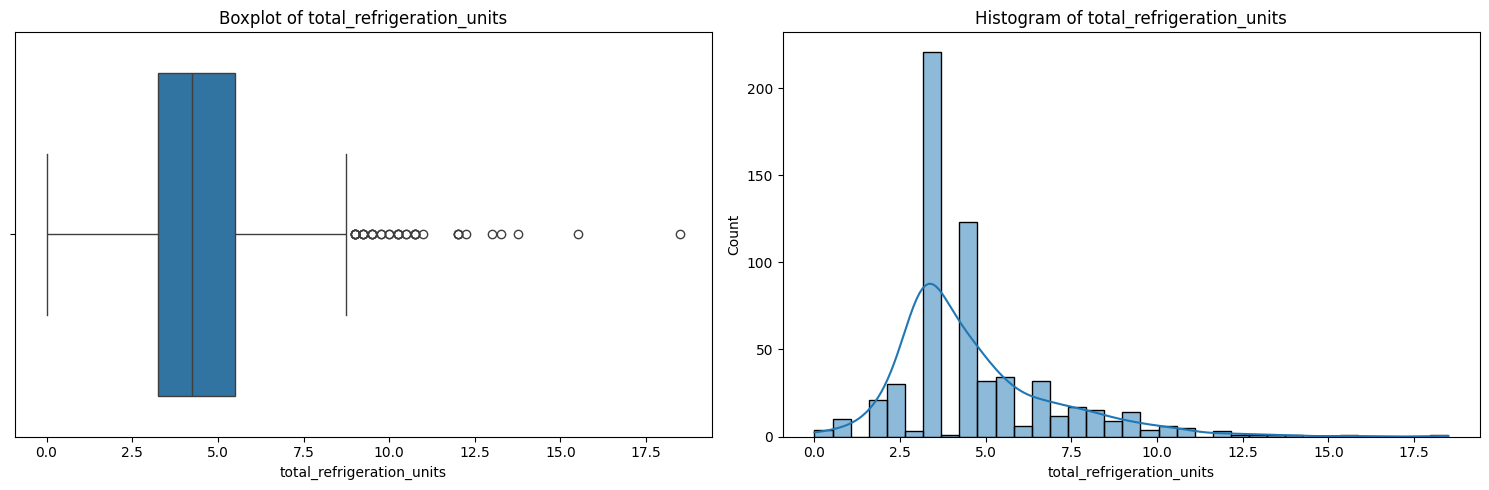


Summary statistics for total_refrigeration_units:
count    608.000000
mean       4.642681
std        2.308144
min        0.000000
25%        3.250000
50%        4.250000
75%        5.500000
max       18.500000
Name: total_refrigeration_units, dtype: float64
Number of outliers: 38
Percentage of outliers: 6.25%


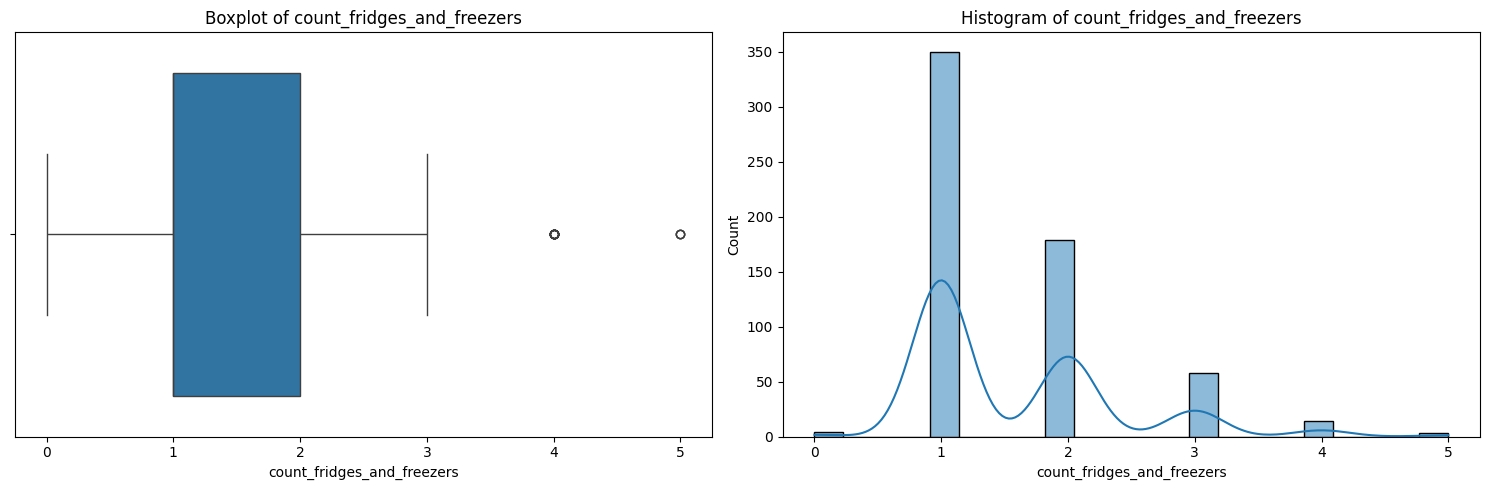


Summary statistics for count_fridges_and_freezers:
count    608.000000
mean       1.567434
std        0.804881
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        5.000000
Name: count_fridges_and_freezers, dtype: float64
Number of outliers: 17
Percentage of outliers: 2.80%

Count information for count_fridges_and_freezers:
Minimum count: 0
Maximum count: 5
Mode: 1


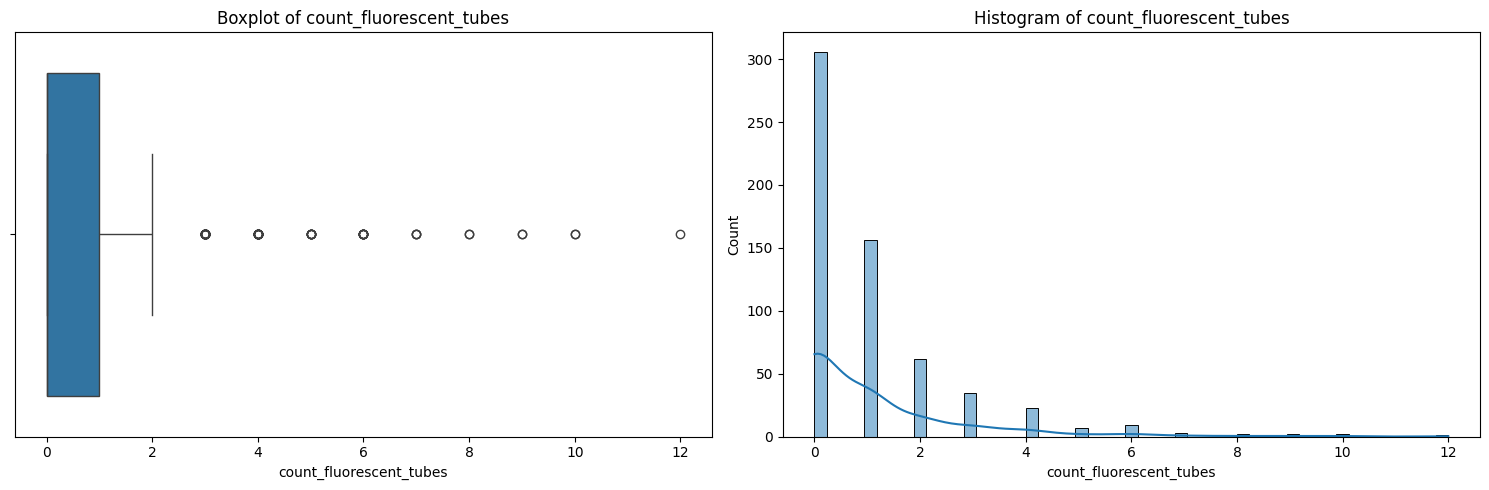


Summary statistics for count_fluorescent_tubes:
count    608.000000
mean       1.074013
std        1.656533
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       12.000000
Name: count_fluorescent_tubes, dtype: float64
Number of outliers: 84
Percentage of outliers: 13.82%

Count information for count_fluorescent_tubes:
Minimum count: 0
Maximum count: 12
Mode: 0


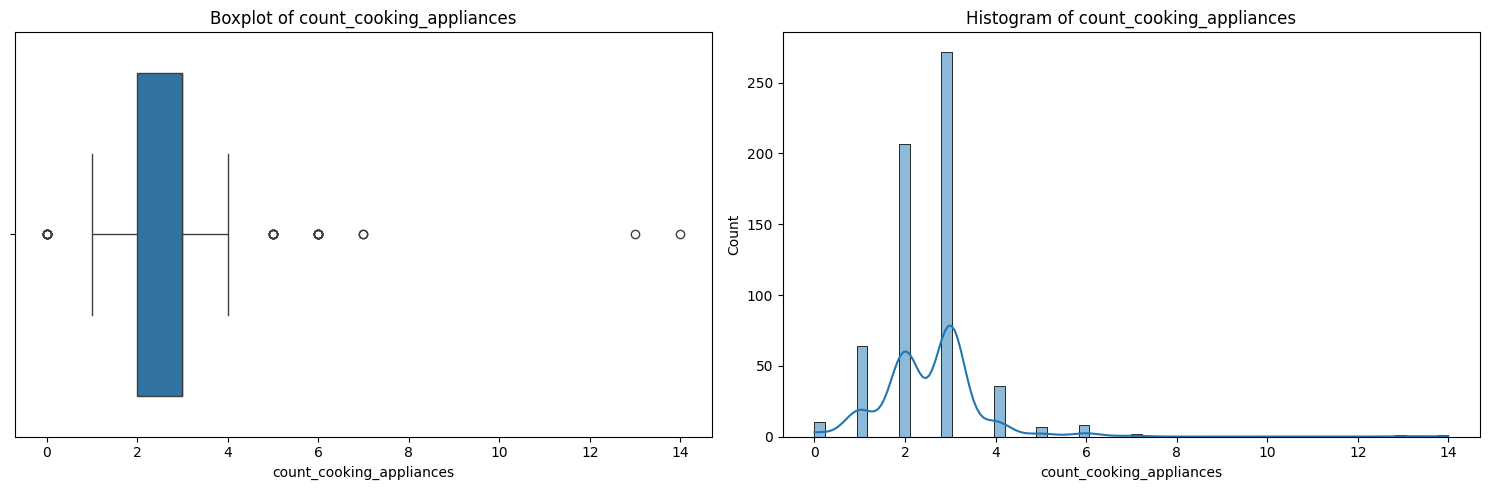


Summary statistics for count_cooking_appliances:
count    608.000000
mean       2.569079
std        1.168715
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max       14.000000
Name: count_cooking_appliances, dtype: float64
Number of outliers: 29
Percentage of outliers: 4.77%

Count information for count_cooking_appliances:
Minimum count: 0
Maximum count: 14
Mode: 3


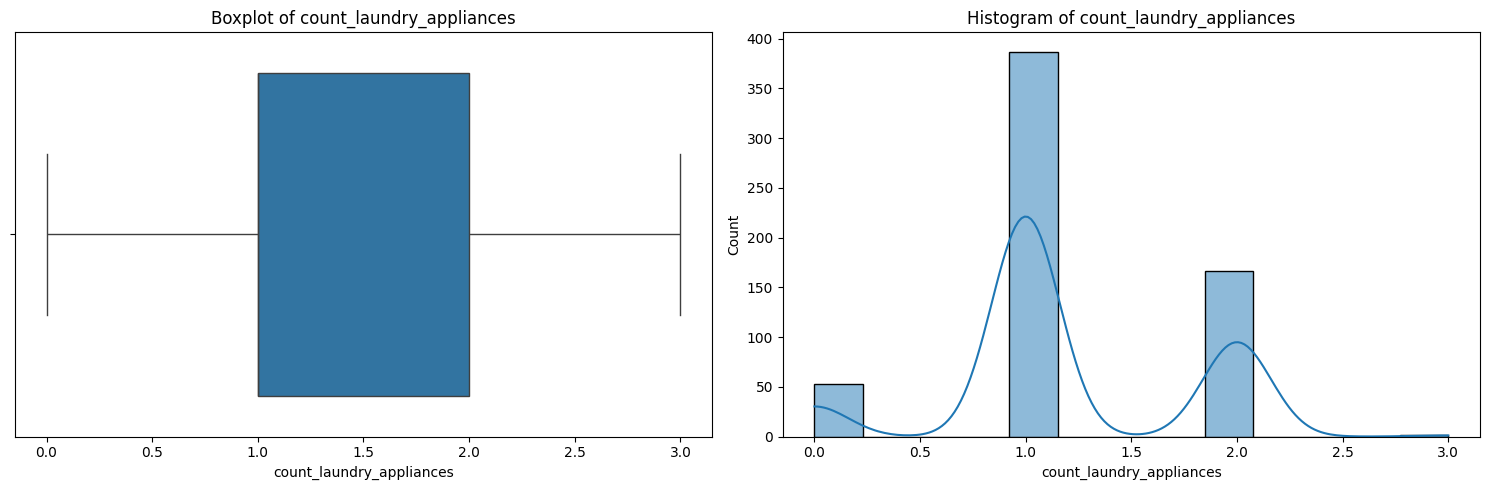


Summary statistics for count_laundry_appliances:
count    608.000000
mean       1.192434
std        0.580412
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: count_laundry_appliances, dtype: float64
Number of outliers: 0
Percentage of outliers: 0.00%

Count information for count_laundry_appliances:
Minimum count: 0
Maximum count: 3
Mode: 1


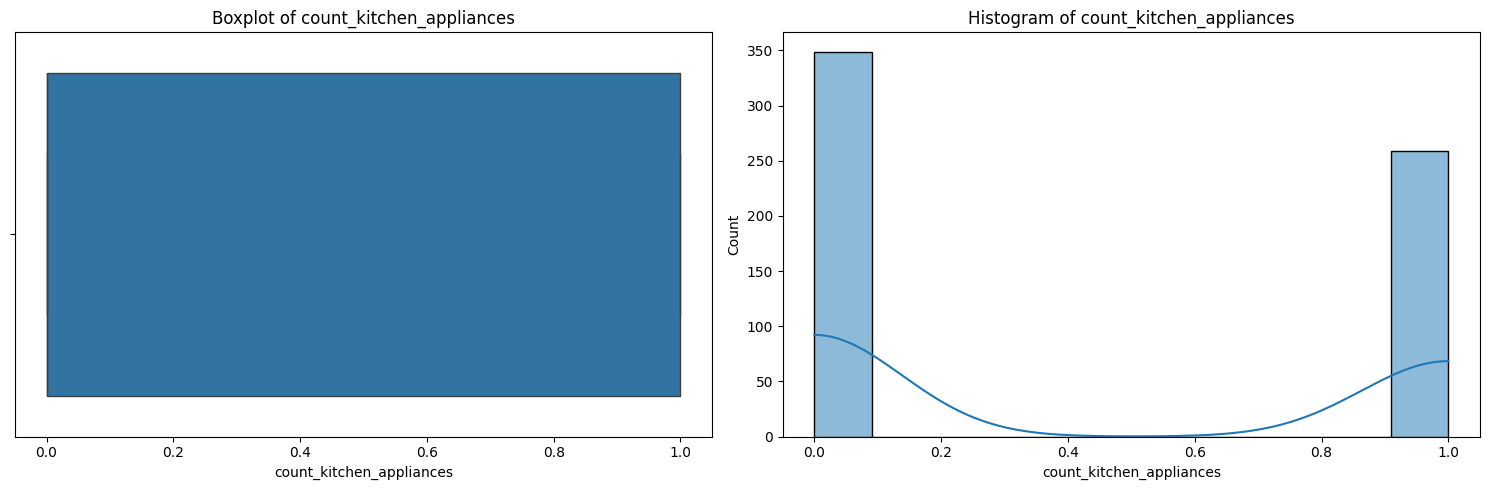


Summary statistics for count_kitchen_appliances:
count    608.000000
mean       0.425987
std        0.494899
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: count_kitchen_appliances, dtype: float64
Number of outliers: 0
Percentage of outliers: 0.00%

Count information for count_kitchen_appliances:
Minimum count: 0
Maximum count: 1
Mode: 0


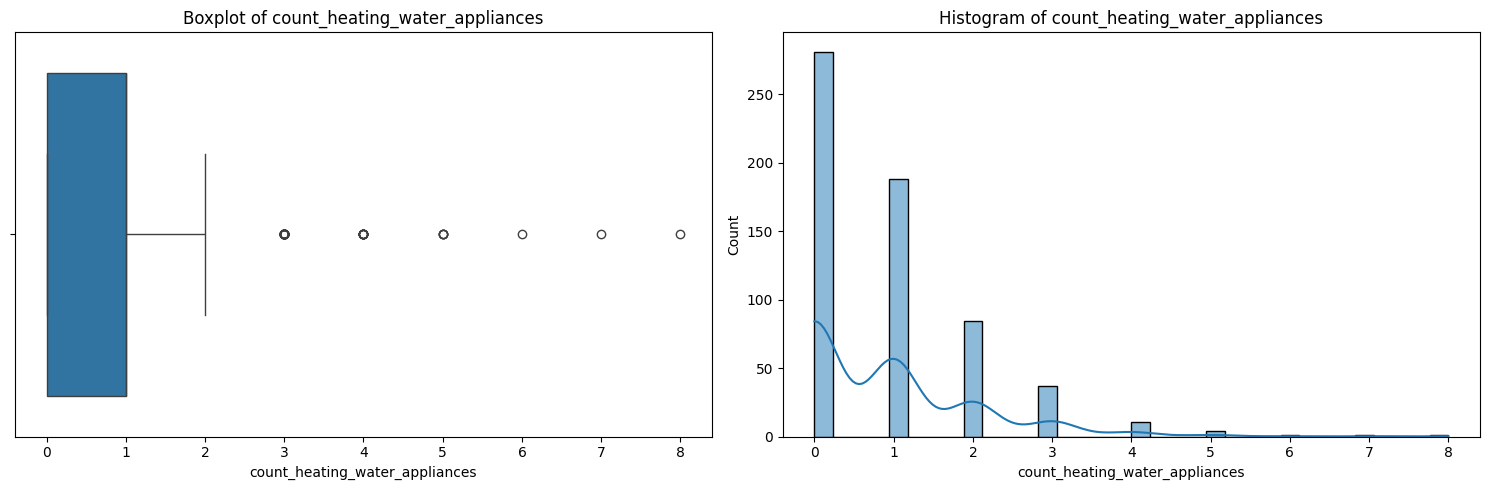


Summary statistics for count_heating_water_appliances:
count    608.000000
mean       0.907895
std        1.134194
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        8.000000
Name: count_heating_water_appliances, dtype: float64
Number of outliers: 55
Percentage of outliers: 9.05%

Count information for count_heating_water_appliances:
Minimum count: 0
Maximum count: 8
Mode: 0


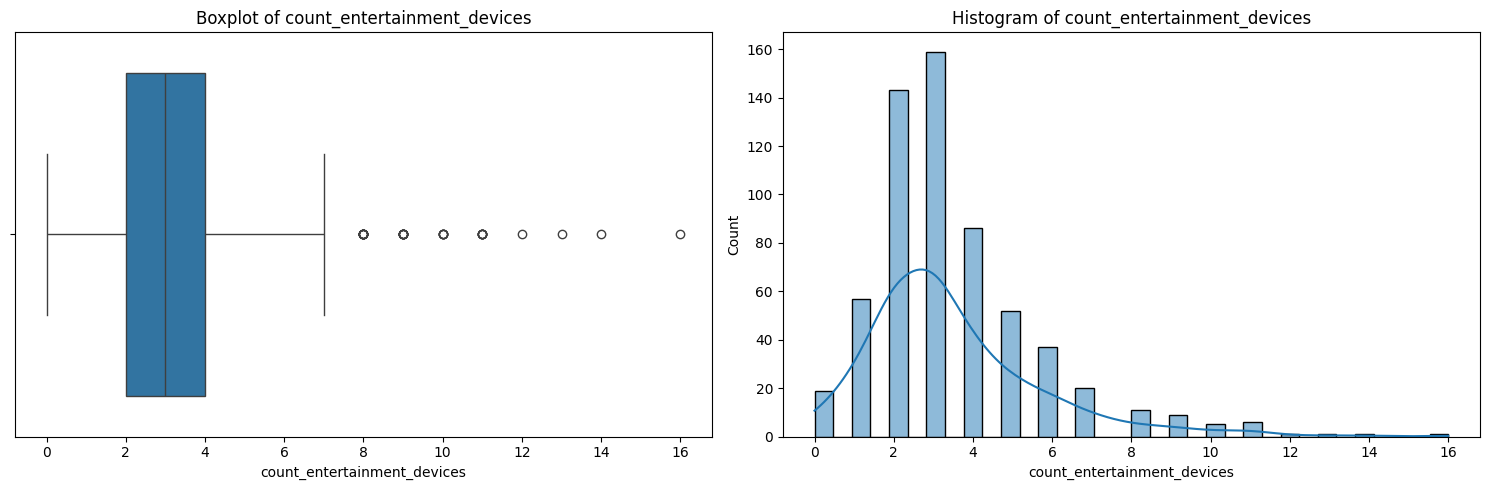


Summary statistics for count_entertainment_devices:
count    608.000000
mean       3.496711
std        2.237170
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       16.000000
Name: count_entertainment_devices, dtype: float64
Number of outliers: 35
Percentage of outliers: 5.76%

Count information for count_entertainment_devices:
Minimum count: 0
Maximum count: 16
Mode: 3


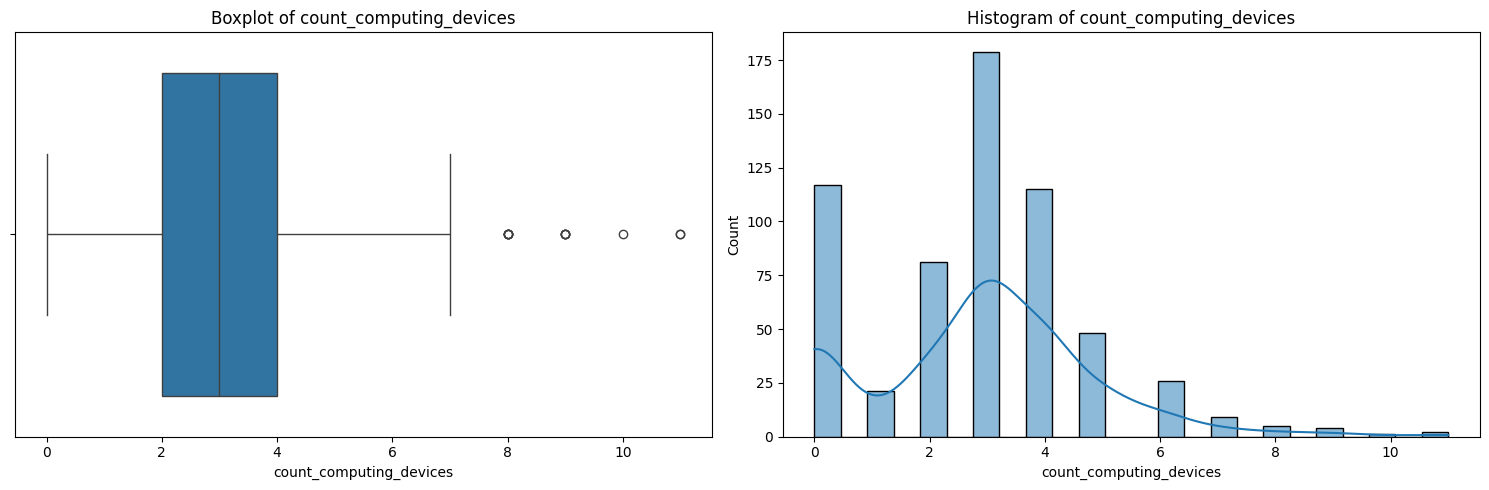


Summary statistics for count_computing_devices:
count    608.000000
mean       2.873355
std        1.963106
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       11.000000
Name: count_computing_devices, dtype: float64
Number of outliers: 12
Percentage of outliers: 1.97%

Count information for count_computing_devices:
Minimum count: 0
Maximum count: 11
Mode: 3


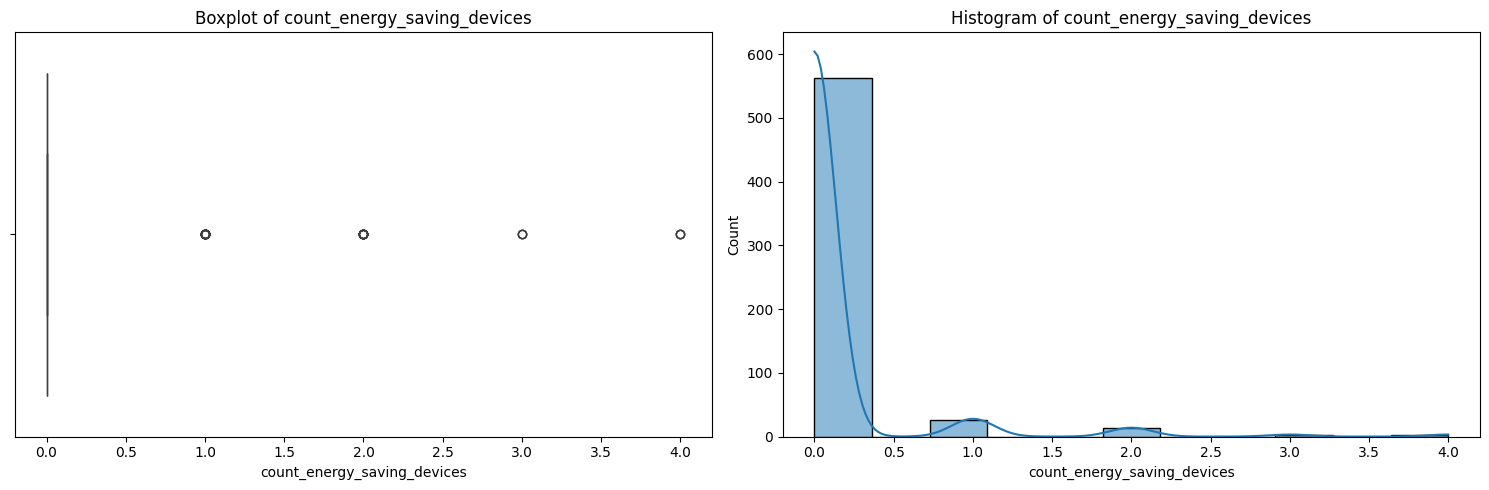


Summary statistics for count_energy_saving_devices:
count    608.000000
mean       0.120066
std        0.487463
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        4.000000
Name: count_energy_saving_devices, dtype: float64
Number of outliers: 45
Percentage of outliers: 7.40%

Count information for count_energy_saving_devices:
Minimum count: 0
Maximum count: 4
Mode: 0


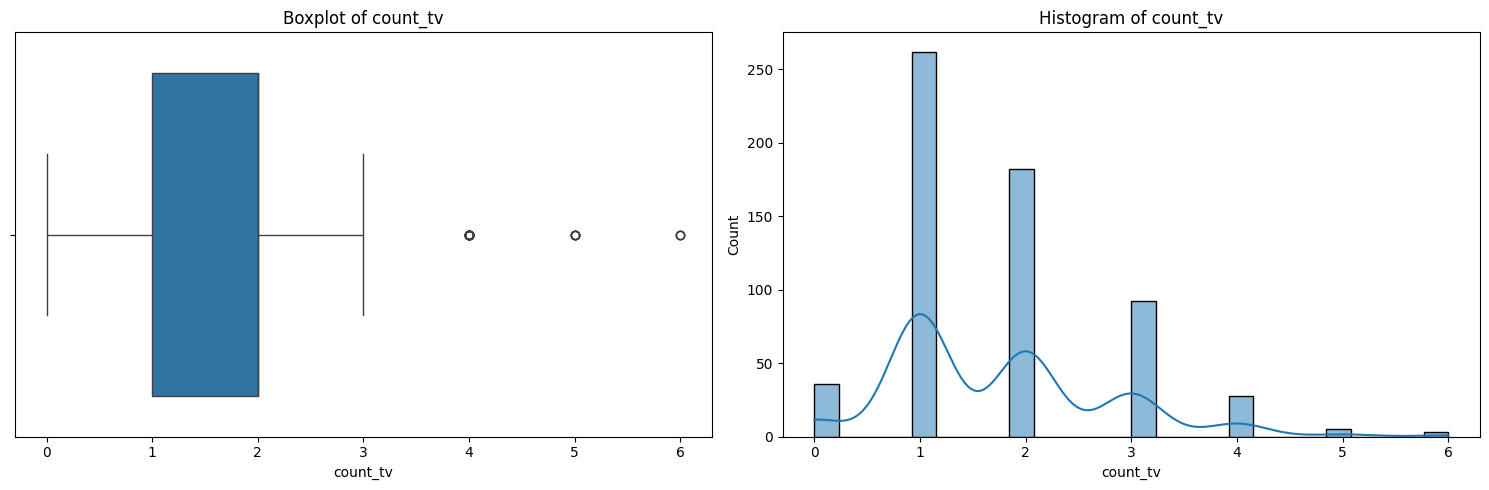


Summary statistics for count_tv:
count    608.000000
mean       1.738487
std        1.043864
min        0.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        6.000000
Name: count_tv, dtype: float64
Number of outliers: 36
Percentage of outliers: 5.92%

Count information for count_tv:
Minimum count: 0
Maximum count: 6
Mode: 1


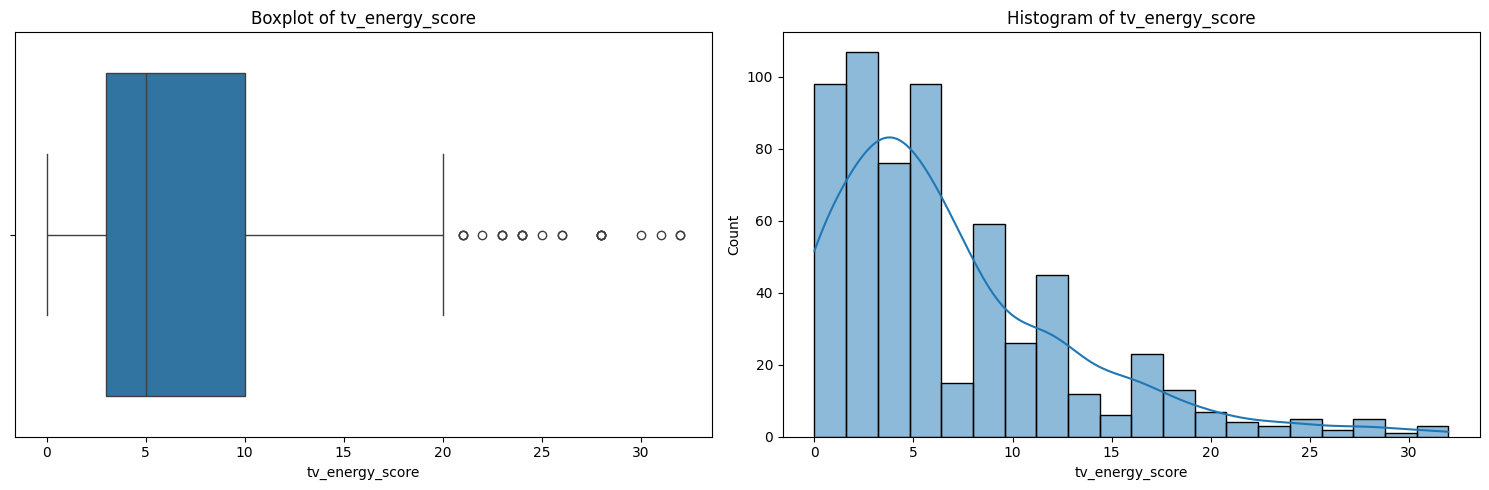


Summary statistics for tv_energy_score:
count    6.080000e+02
mean     6.806743e+00
std      6.165021e+00
min      8.881784e-16
25%      3.000000e+00
50%      5.000000e+00
75%      1.000000e+01
max      3.200000e+01
Name: tv_energy_score, dtype: float64
Number of outliers: 23
Percentage of outliers: 3.78%


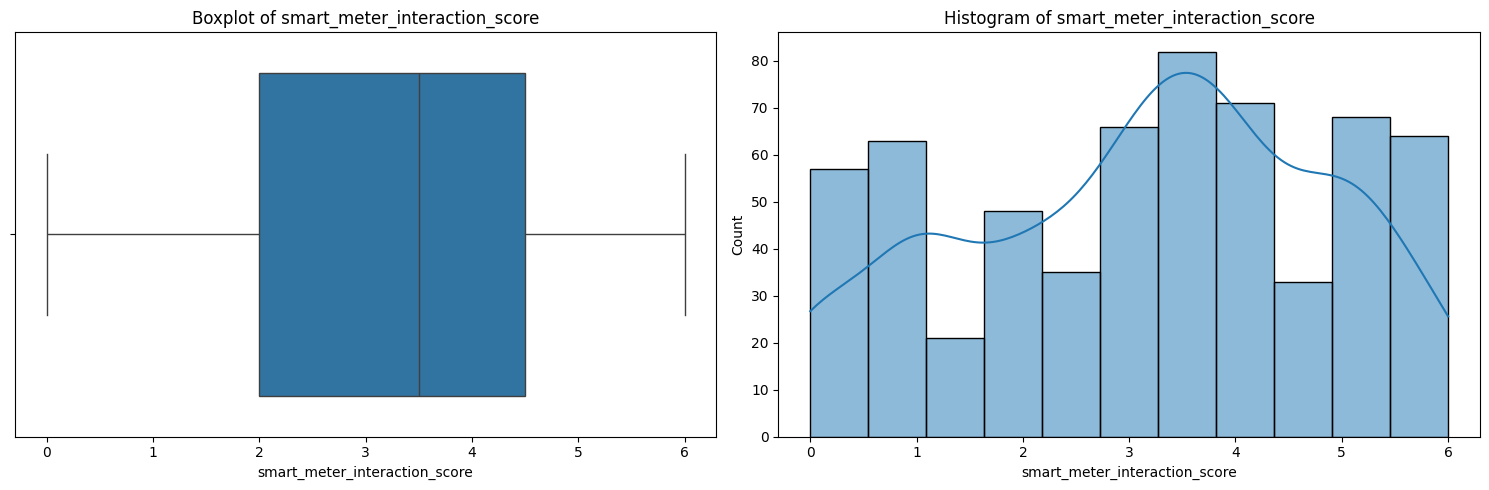


Summary statistics for smart_meter_interaction_score:
count    608.000000
mean       3.138177
std        1.688917
min        0.000000
25%        2.000000
50%        3.500000
75%        4.500000
max        6.000000
Name: smart_meter_interaction_score, dtype: float64
Number of outliers: 0
Percentage of outliers: 0.00%


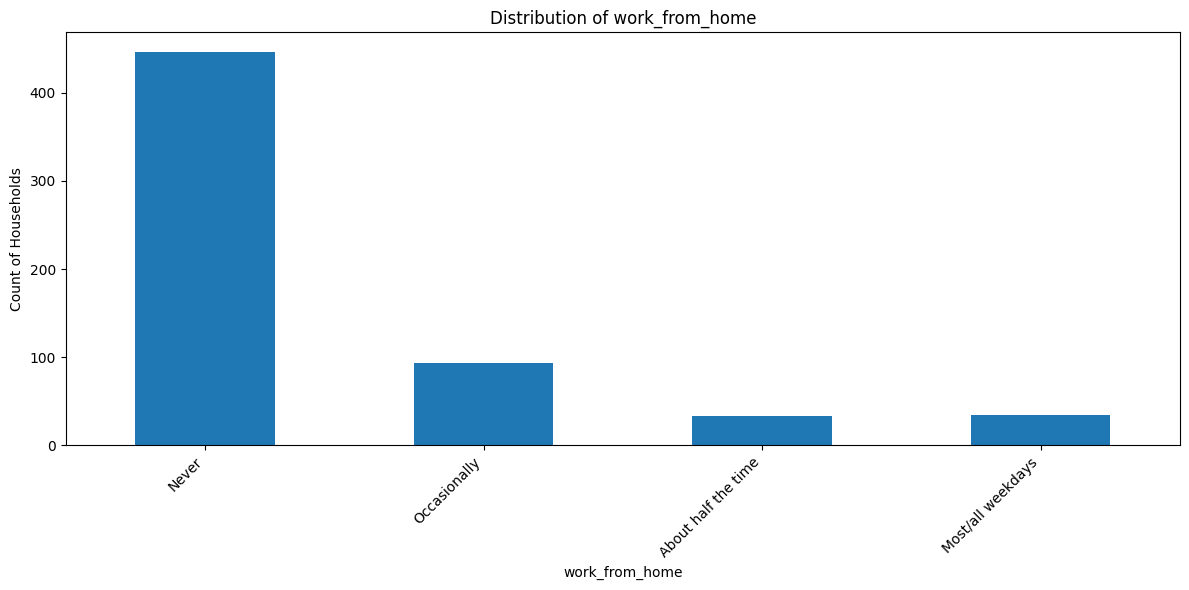


Frequency table for work_from_home:
Never                  0.733553
Occasionally           0.154605
About half the time    0.054276
Most/all weekdays      0.057566
Name: count, dtype: float64


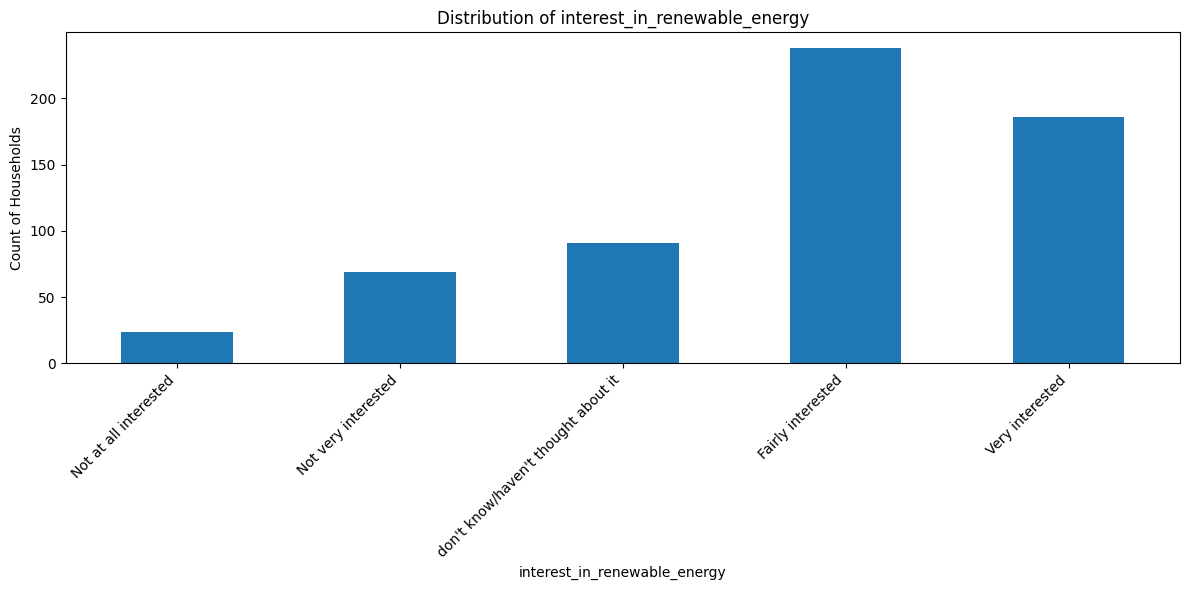


Frequency table for interest_in_renewable_energy:
Not at all interested                  0.039474
Not very interested                    0.113487
don't know/haven't thought about it    0.149671
Fairly interested                      0.391447
Very interested                        0.305921
Name: count, dtype: float64


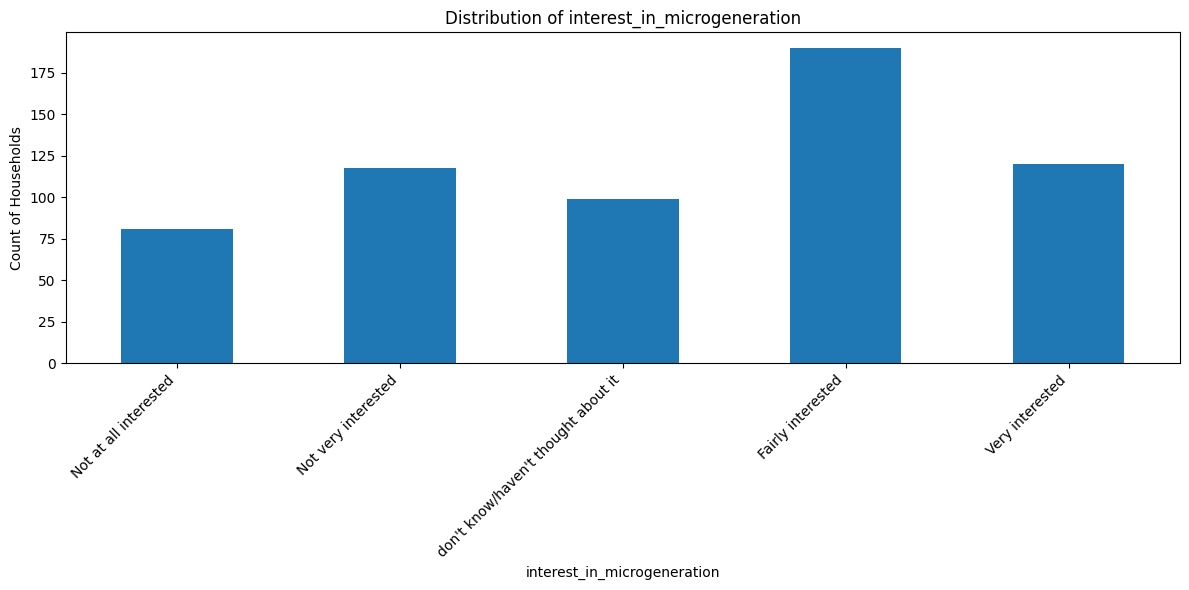


Frequency table for interest_in_microgeneration:
Not at all interested                  0.133224
Not very interested                    0.194079
don't know/haven't thought about it    0.162829
Fairly interested                      0.312500
Very interested                        0.197368
Name: count, dtype: float64


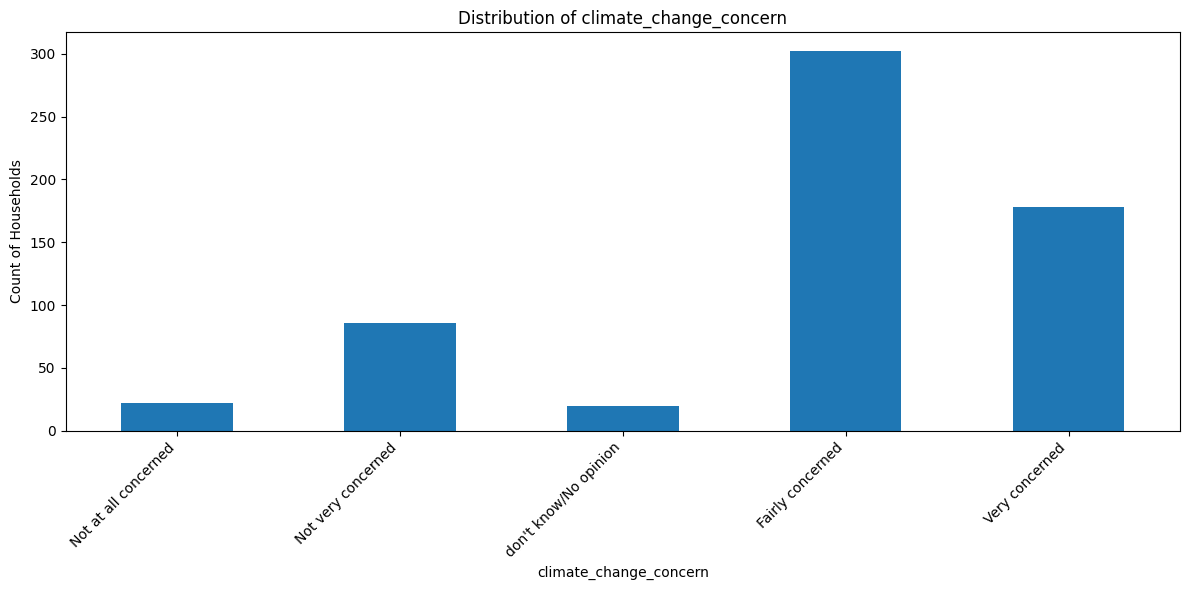


Frequency table for climate_change_concern:
Not at all concerned     0.036184
Not very concerned       0.141447
don't know/No opinion    0.032895
Fairly concerned         0.496711
Very concerned           0.292763
Name: count, dtype: float64


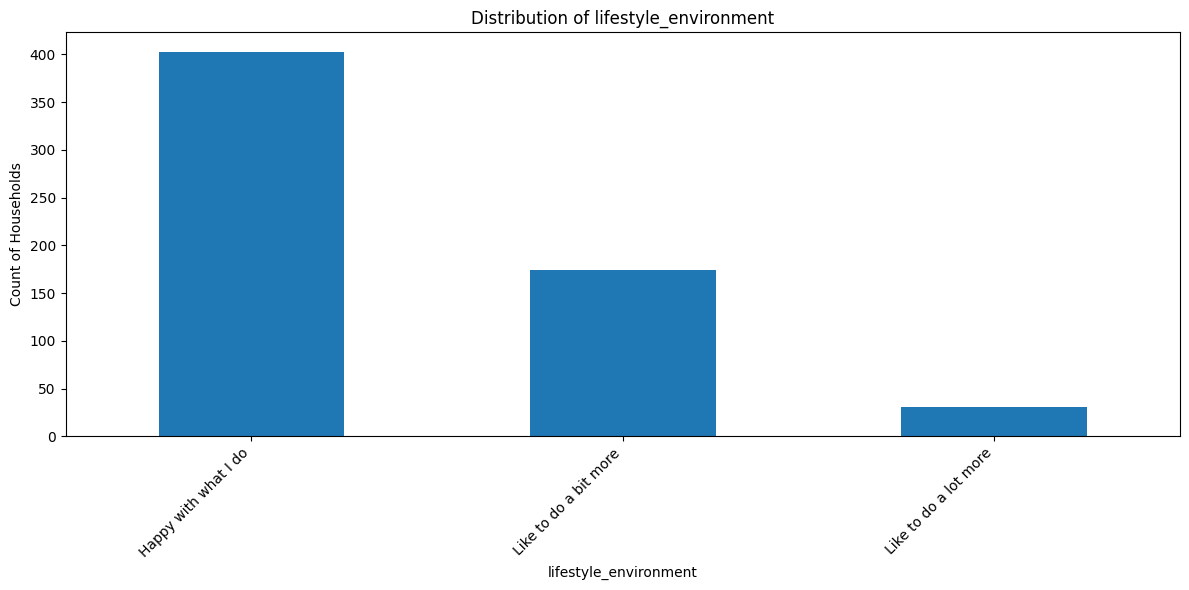


Frequency table for lifestyle_environment:
Happy with what I do     0.662829
Like to do a bit more    0.286184
Like to do a lot more    0.050987
Name: count, dtype: float64


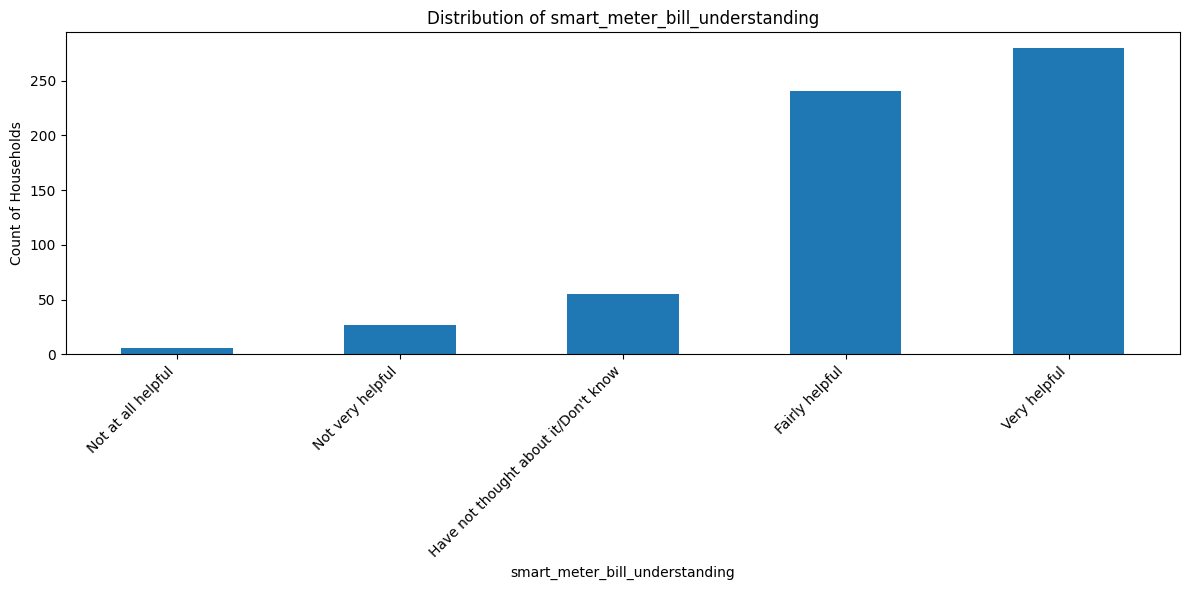


Frequency table for smart_meter_bill_understanding:
Not at all helpful                      0.009868
Not very helpful                        0.044408
Have not thought about it/Don't know    0.090461
Fairly helpful                          0.394737
Very helpful                            0.460526
Name: count, dtype: float64


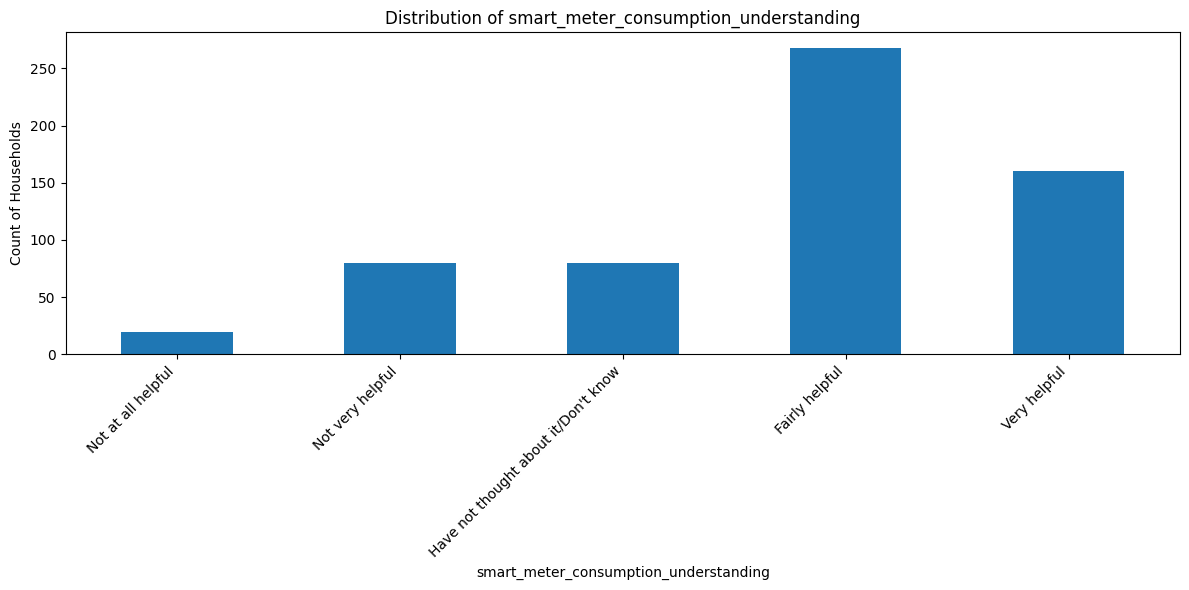


Frequency table for smart_meter_consumption_understanding:
Not at all helpful                      0.032895
Not very helpful                        0.131579
Have not thought about it/Don't know    0.131579
Fairly helpful                          0.440789
Very helpful                            0.263158
Name: count, dtype: float64


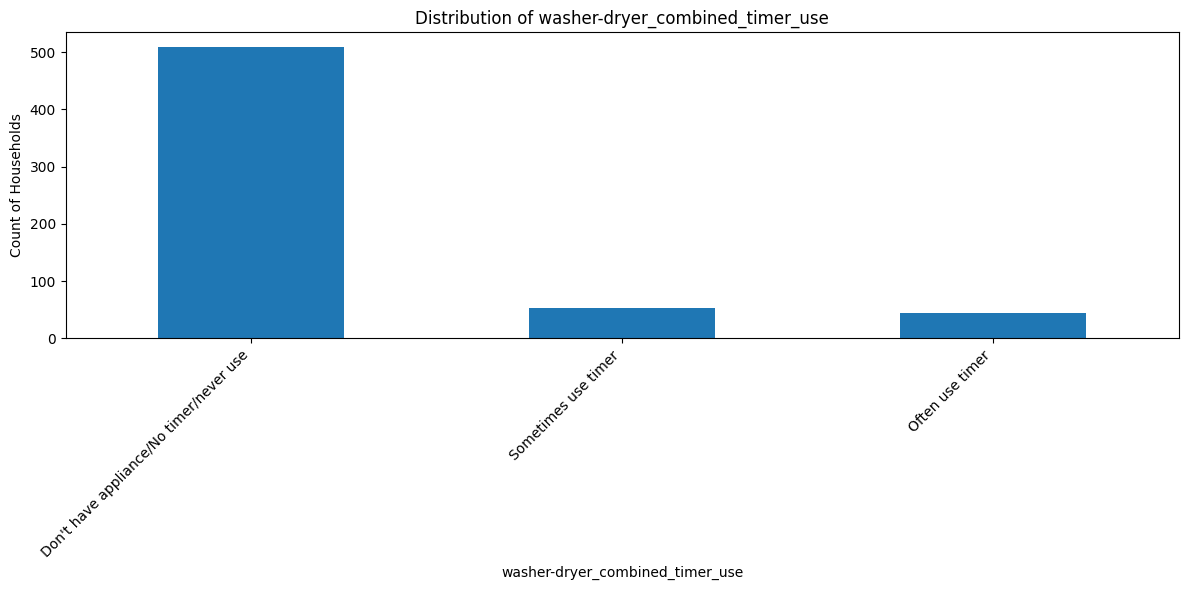


Frequency table for washer-dryer_combined_timer_use:
Don't have appliance/No timer/never use    0.837171
Sometimes use timer                        0.088816
Often use timer                            0.074013
Name: count, dtype: float64


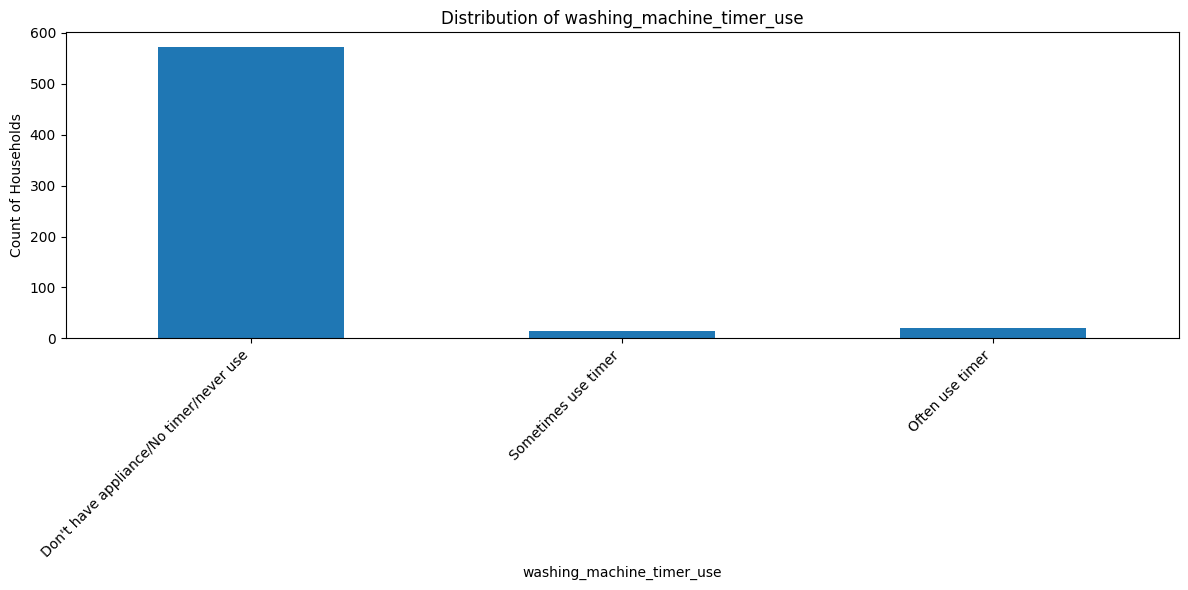


Frequency table for washing_machine_timer_use:
Don't have appliance/No timer/never use    0.940789
Sometimes use timer                        0.024671
Often use timer                            0.034539
Name: count, dtype: float64


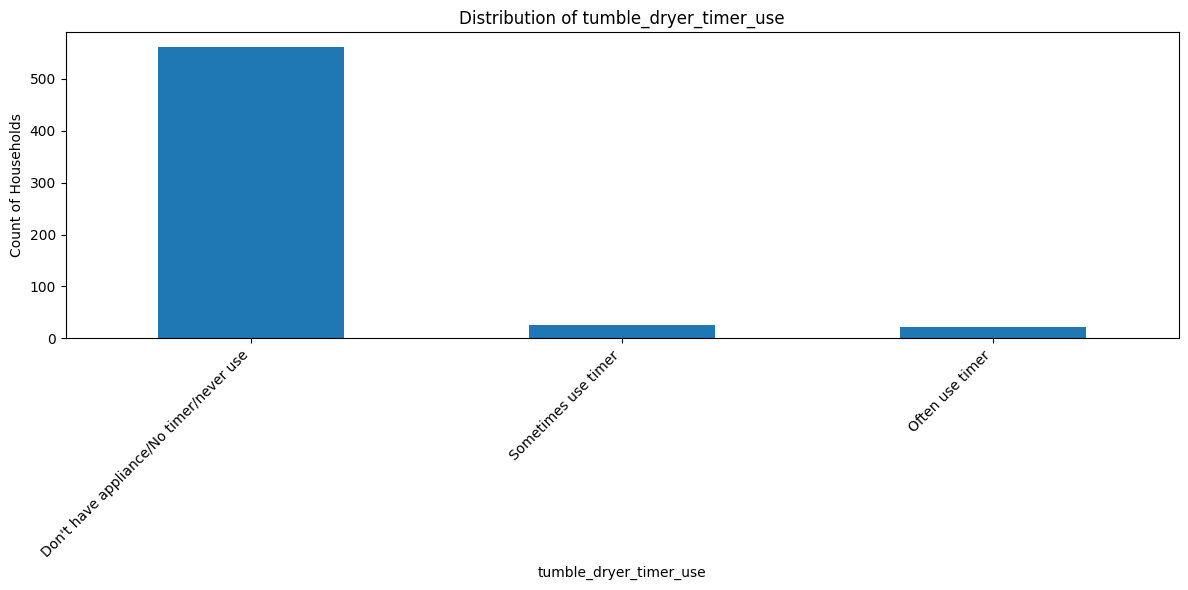


Frequency table for tumble_dryer_timer_use:
Don't have appliance/No timer/never use    0.922697
Sometimes use timer                        0.041118
Often use timer                            0.036184
Name: count, dtype: float64


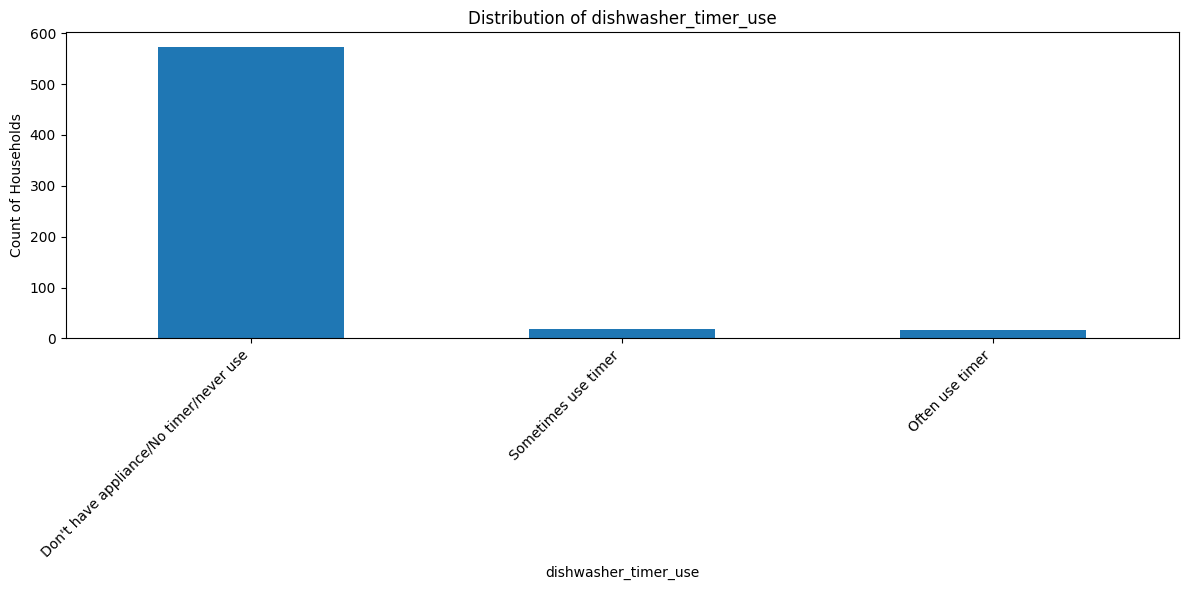


Frequency table for dishwasher_timer_use:
Don't have appliance/No timer/never use    0.942434
Sometimes use timer                        0.029605
Often use timer                            0.027961
Name: count, dtype: float64


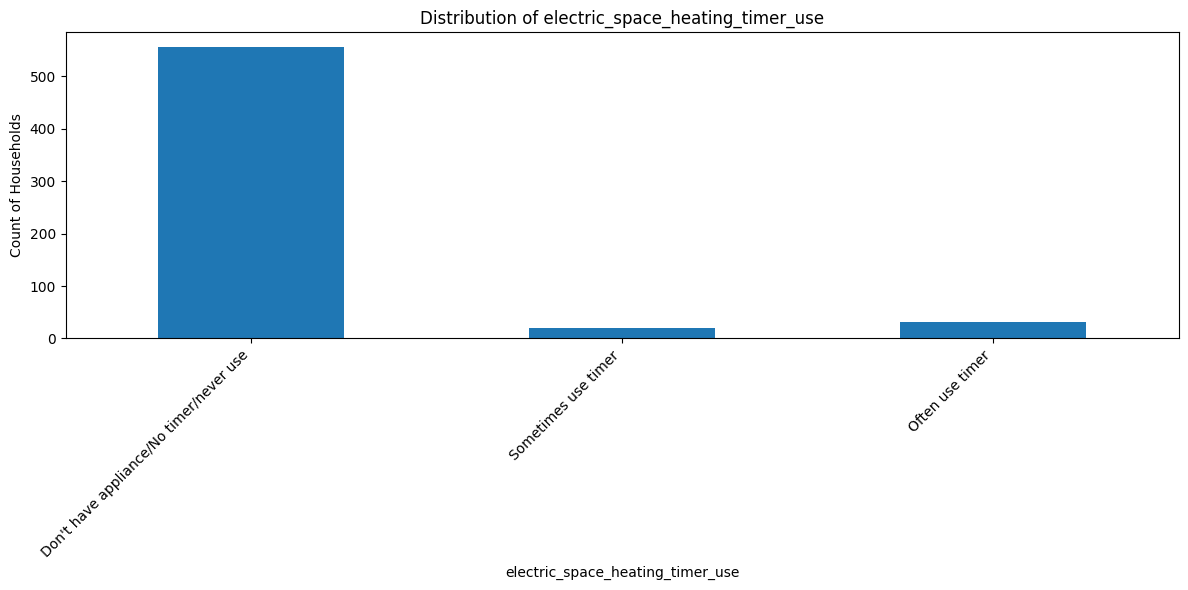


Frequency table for electric_space_heating_timer_use:
Don't have appliance/No timer/never use    0.914474
Sometimes use timer                        0.032895
Often use timer                            0.052632
Name: count, dtype: float64


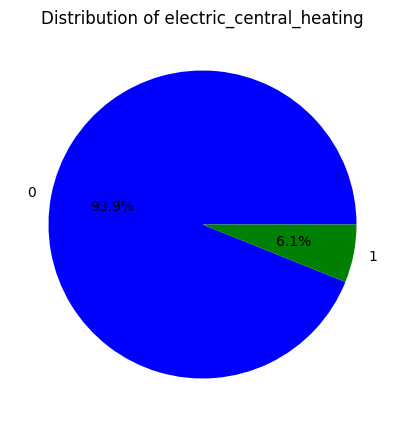


Frequency table for electric_central_heating:
electric_central_heating
0    0.939145
1    0.060855
Name: proportion, dtype: float64


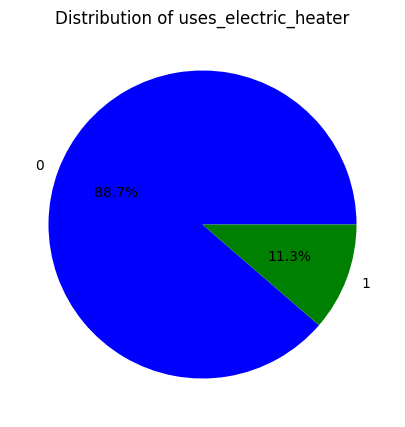


Frequency table for uses_electric_heater:
uses_electric_heater
0    0.886513
1    0.113487
Name: proportion, dtype: float64


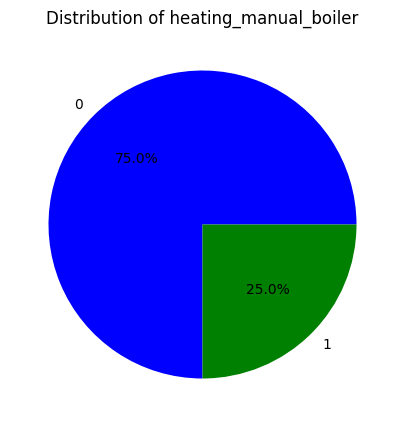


Frequency table for heating_manual_boiler:
heating_manual_boiler
0    0.75
1    0.25
Name: proportion, dtype: float64


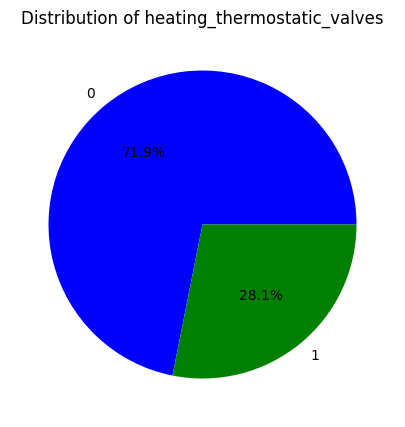


Frequency table for heating_thermostatic_valves:
heating_thermostatic_valves
0    0.71875
1    0.28125
Name: proportion, dtype: float64


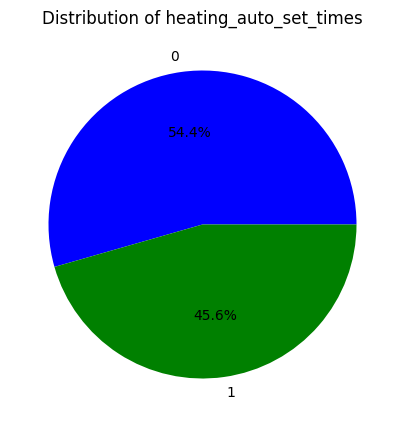


Frequency table for heating_auto_set_times:
heating_auto_set_times
0    0.544408
1    0.455592
Name: proportion, dtype: float64


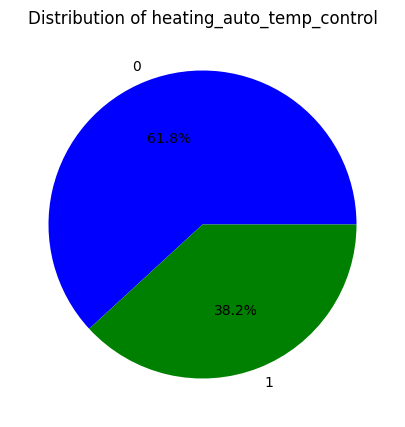


Frequency table for heating_auto_temp_control:
heating_auto_temp_control
0    0.618421
1    0.381579
Name: proportion, dtype: float64


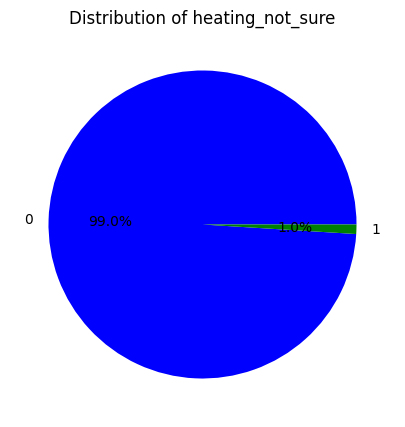


Frequency table for heating_not_sure:
heating_not_sure
0    0.990132
1    0.009868
Name: proportion, dtype: float64


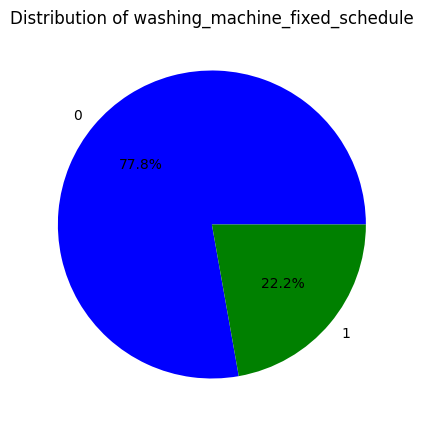


Frequency table for washing_machine_fixed_schedule:
washing_machine_fixed_schedule
0    0.777961
1    0.222039
Name: proportion, dtype: float64


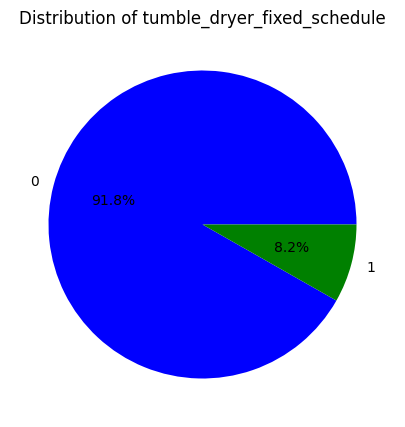


Frequency table for tumble_dryer_fixed_schedule:
tumble_dryer_fixed_schedule
0    0.917763
1    0.082237
Name: proportion, dtype: float64


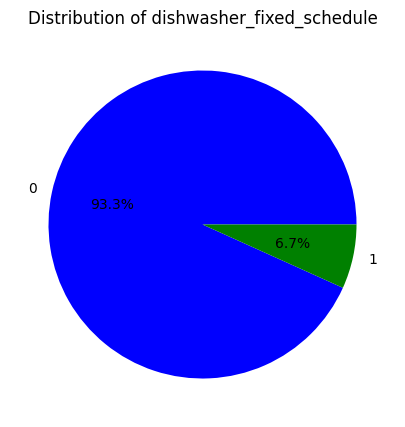


Frequency table for dishwasher_fixed_schedule:
dishwasher_fixed_schedule
0    0.932566
1    0.067434
Name: proportion, dtype: float64


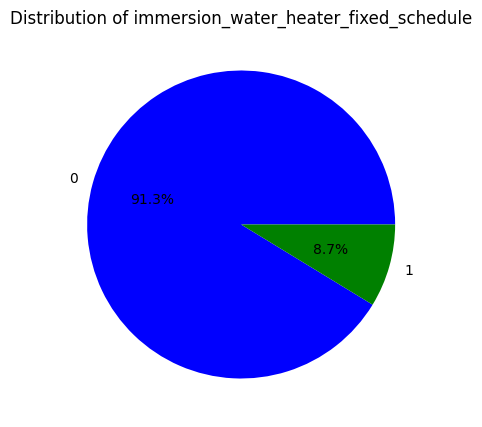


Frequency table for immersion_water_heater_fixed_schedule:
immersion_water_heater_fixed_schedule
0    0.912829
1    0.087171
Name: proportion, dtype: float64


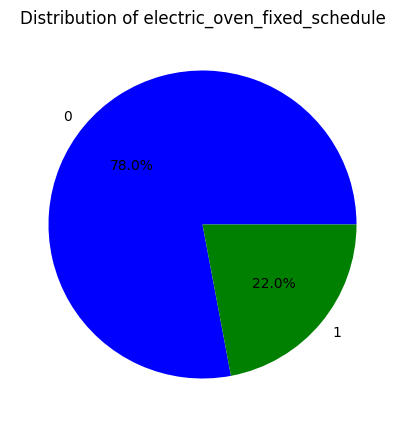


Frequency table for electric_oven_fixed_schedule:
electric_oven_fixed_schedule
0    0.779605
1    0.220395
Name: proportion, dtype: float64


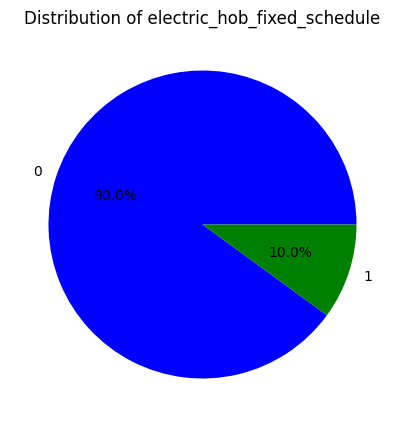


Frequency table for electric_hob_fixed_schedule:
electric_hob_fixed_schedule
0    0.899671
1    0.100329
Name: proportion, dtype: float64


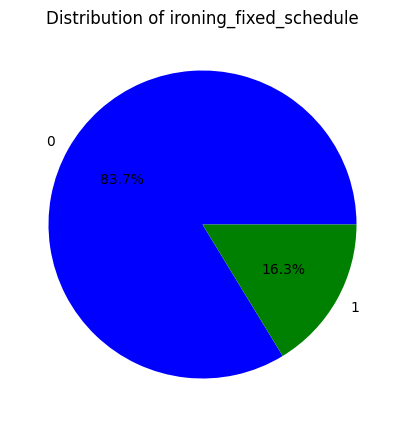


Frequency table for ironing_fixed_schedule:
ironing_fixed_schedule
0    0.837171
1    0.162829
Name: proportion, dtype: float64


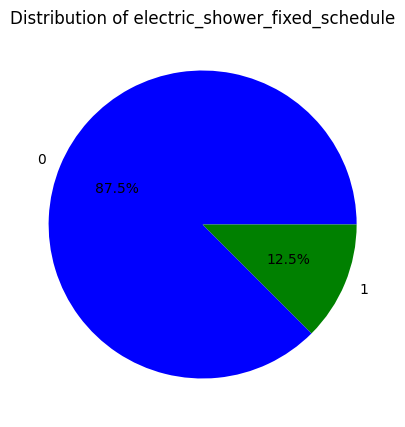


Frequency table for electric_shower_fixed_schedule:
electric_shower_fixed_schedule
0    0.875
1    0.125
Name: proportion, dtype: float64


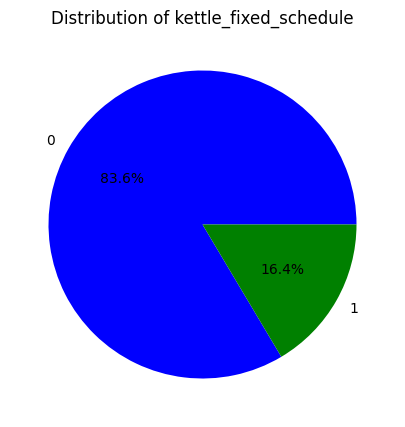


Frequency table for kettle_fixed_schedule:
kettle_fixed_schedule
0    0.835526
1    0.164474
Name: proportion, dtype: float64


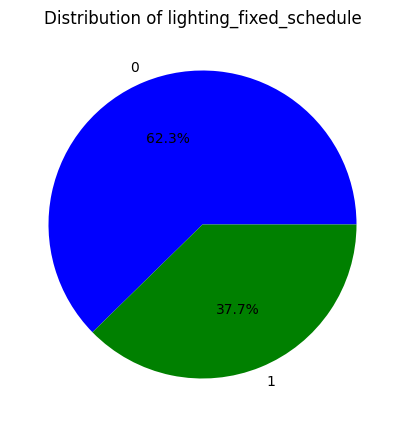


Frequency table for lighting_fixed_schedule:
lighting_fixed_schedule
0    0.623355
1    0.376645
Name: proportion, dtype: float64


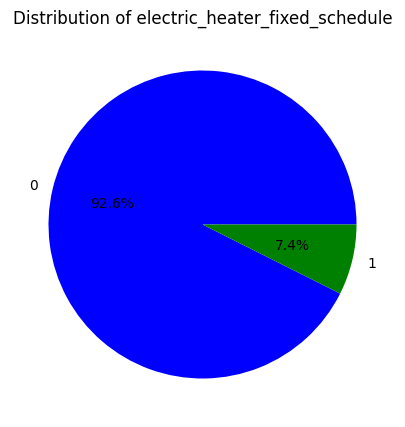


Frequency table for electric_heater_fixed_schedule:
electric_heater_fixed_schedule
0    0.925987
1    0.074013
Name: proportion, dtype: float64


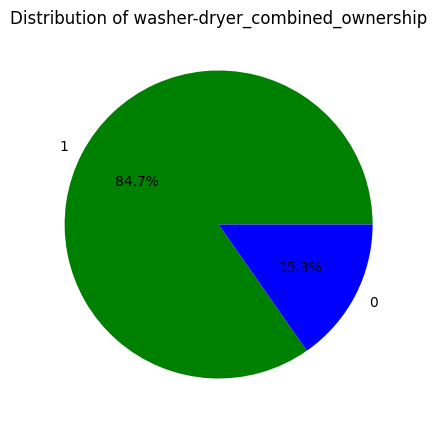


Frequency table for washer-dryer_combined_ownership:
washer-dryer_combined_ownership
1    0.847039
0    0.152961
Name: proportion, dtype: float64


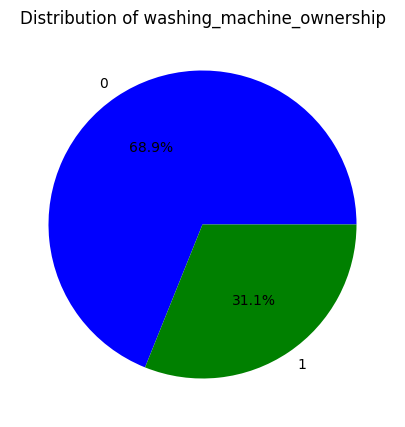


Frequency table for washing_machine_ownership:
washing_machine_ownership
0    0.689145
1    0.310855
Name: proportion, dtype: float64


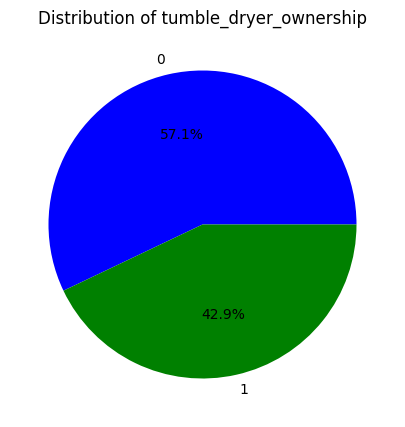


Frequency table for tumble_dryer_ownership:
tumble_dryer_ownership
0    0.570724
1    0.429276
Name: proportion, dtype: float64


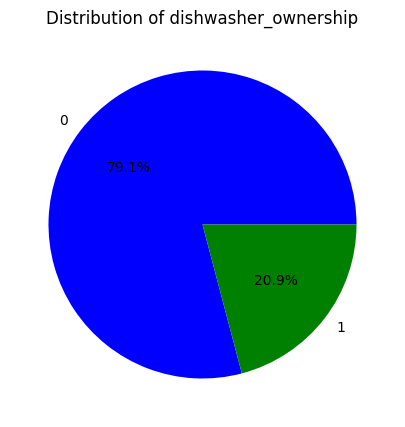


Frequency table for dishwasher_ownership:
dishwasher_ownership
0    0.791118
1    0.208882
Name: proportion, dtype: float64


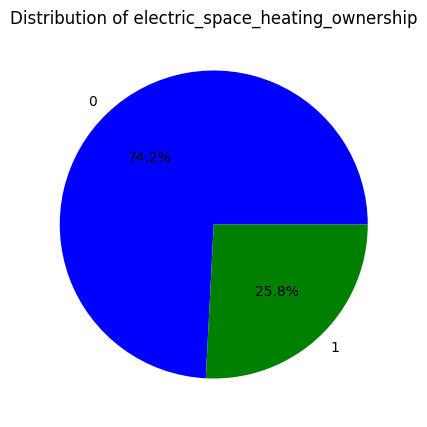


Frequency table for electric_space_heating_ownership:
electric_space_heating_ownership
0    0.741776
1    0.258224
Name: proportion, dtype: float64


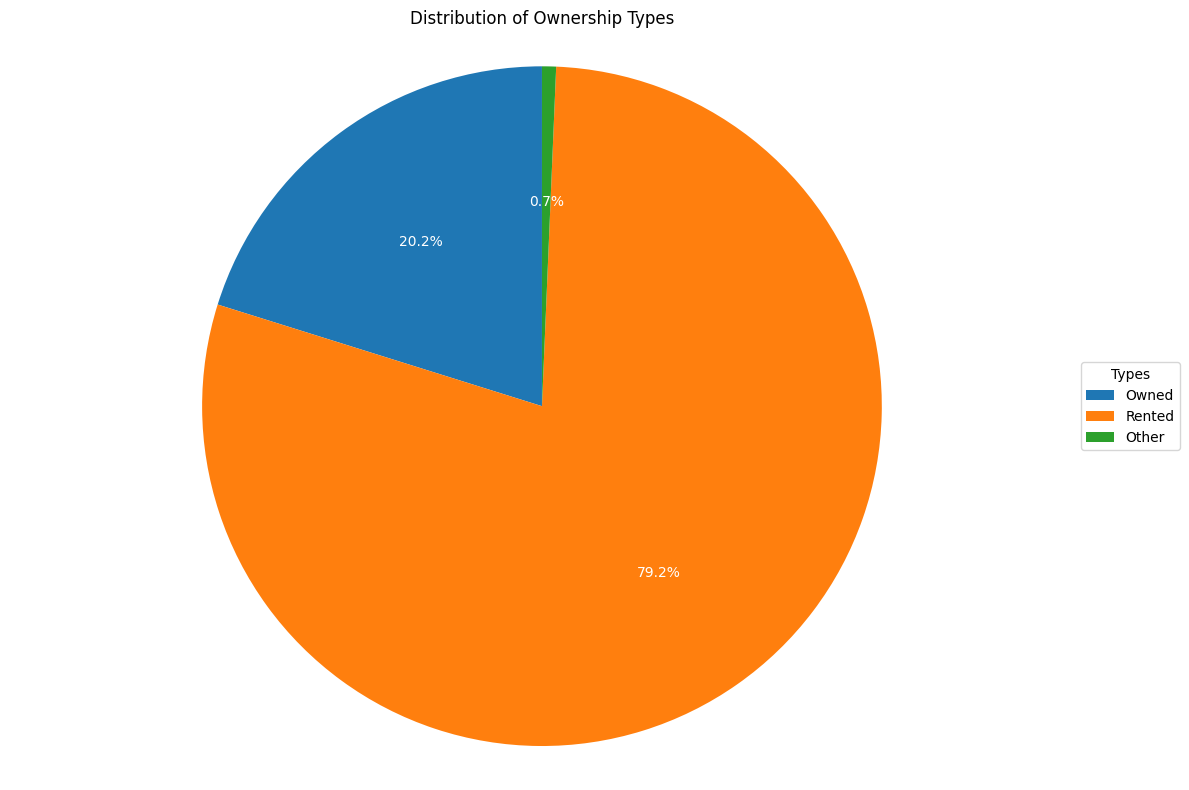


Frequency table for Distribution of Ownership Types:
ownership_owned     0.199013
ownership_rented    0.781250
ownership_other     0.006579
dtype: float64


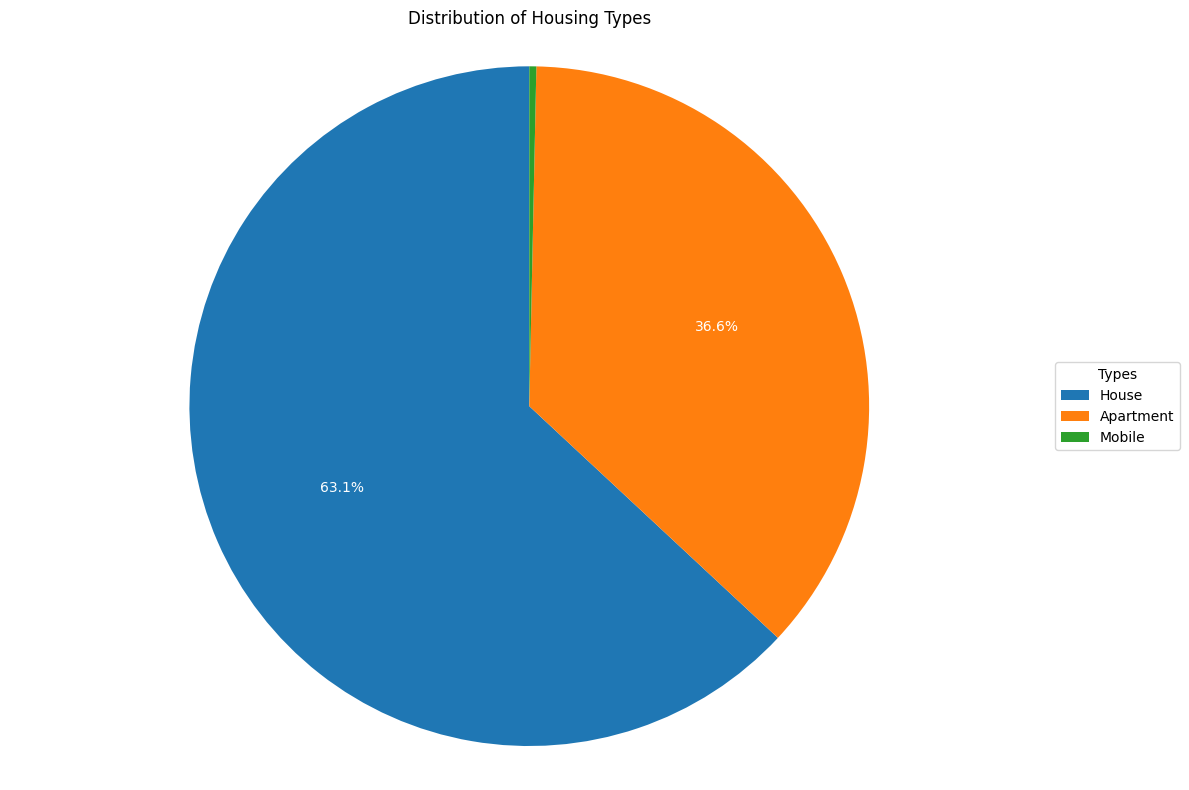


Frequency table for Distribution of Housing Types:
housing_house        0.623355
housing_apartment    0.361842
housing_mobile       0.003289
dtype: float64


In [14]:
# Plot the variables again post-imputation
print("Post Imputation")
plot_numerical_post_imputation(df_households_imputed, numerical_vars)
plot_categorical(df_households_imputed, categorical_vars)
plot_binary(df_households_imputed, binary_vars)
plot_grouped_binary(df_households_imputed, 'ownership_', 'Distribution of Ownership Types')
plot_grouped_binary(df_households_imputed, 'housing_', 'Distribution of Housing Types')

In [15]:
# Merge the imputed static characteristics back into df_merged
# Use update() to ensure df_households' values take precedence
df_merged_updated = df_merged.copy()
df_merged_updated.set_index('household_id', inplace=True)
df_households_imputed.set_index('household_id', inplace=True)
df_merged_updated.update(df_households_imputed)
df_merged_updated.reset_index(inplace=True)

# Print total number of missing values
print(f"\nTotal number of missing values: {df_merged_updated.isnull().sum().sum()}")


Total number of missing values: 0


### Let's also explore our consumption values in a bit more detail

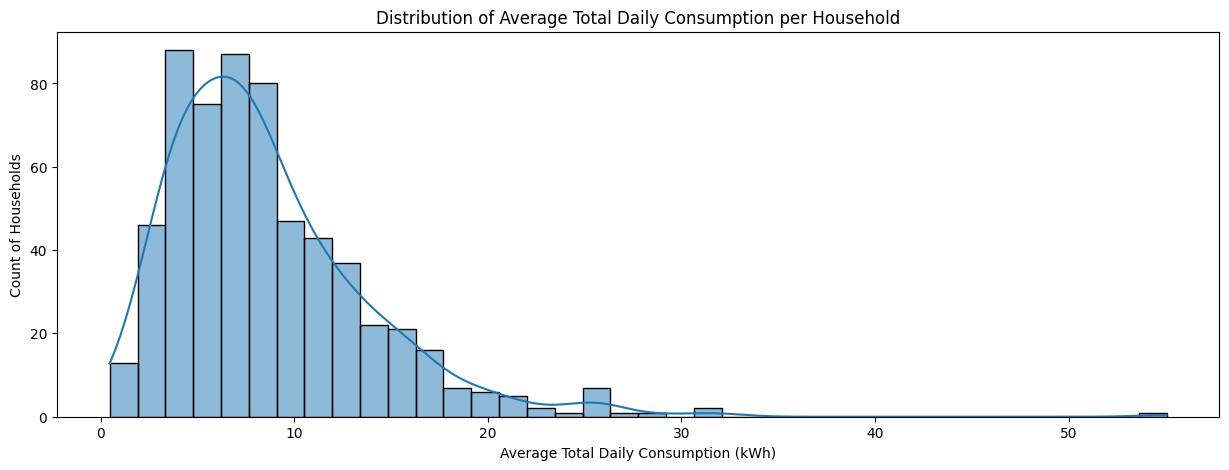

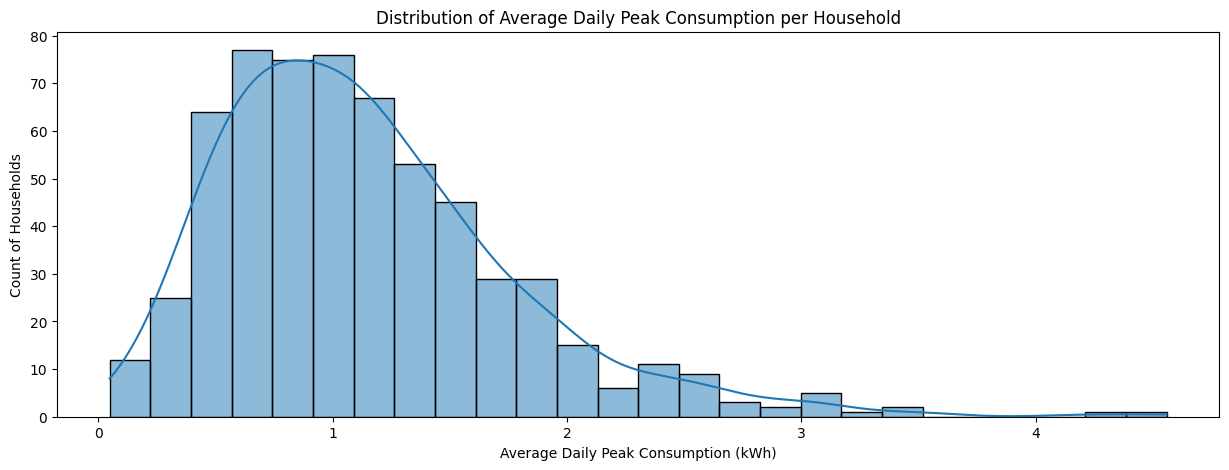

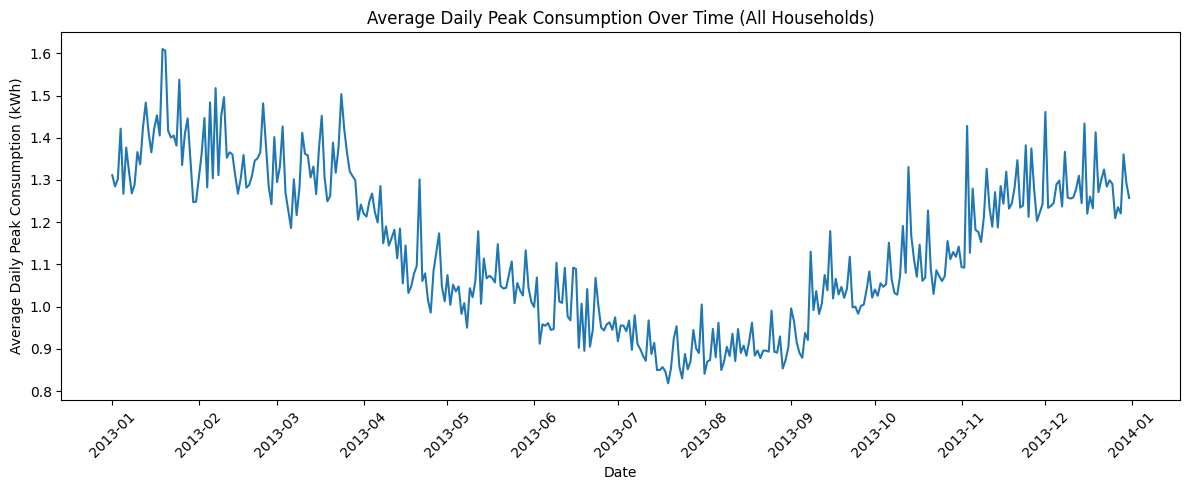

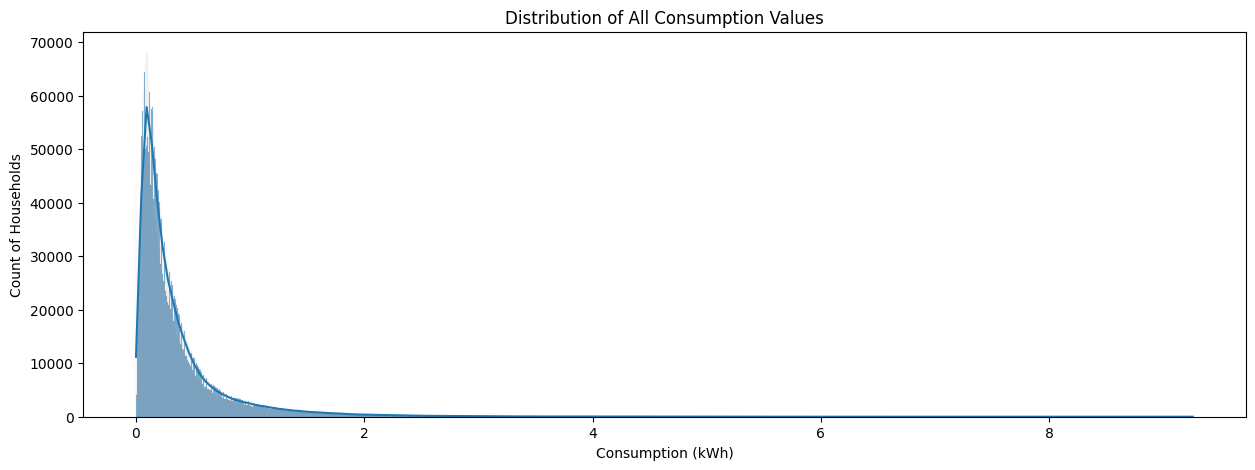

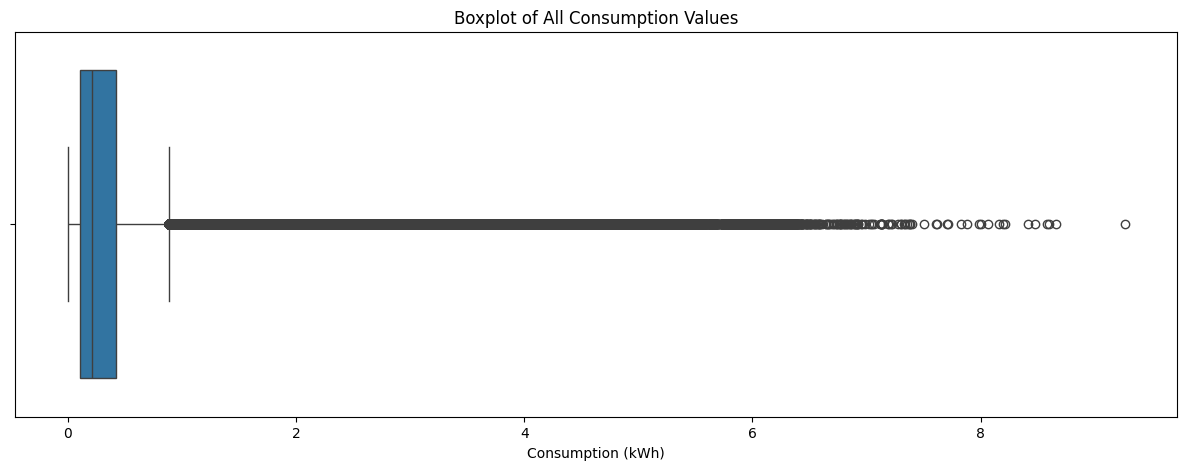


Summary statistics for all consumption values:
count    5.325472e+06
mean     3.590864e-01
std      4.472021e-01
min      0.000000e+00
25%      1.090000e-01
50%      2.130000e-01
75%      4.210000e-01
max      9.260000e+00
Name: consumption, dtype: float64
Number of outliers: 465184
Percentage of outliers: 8.74%


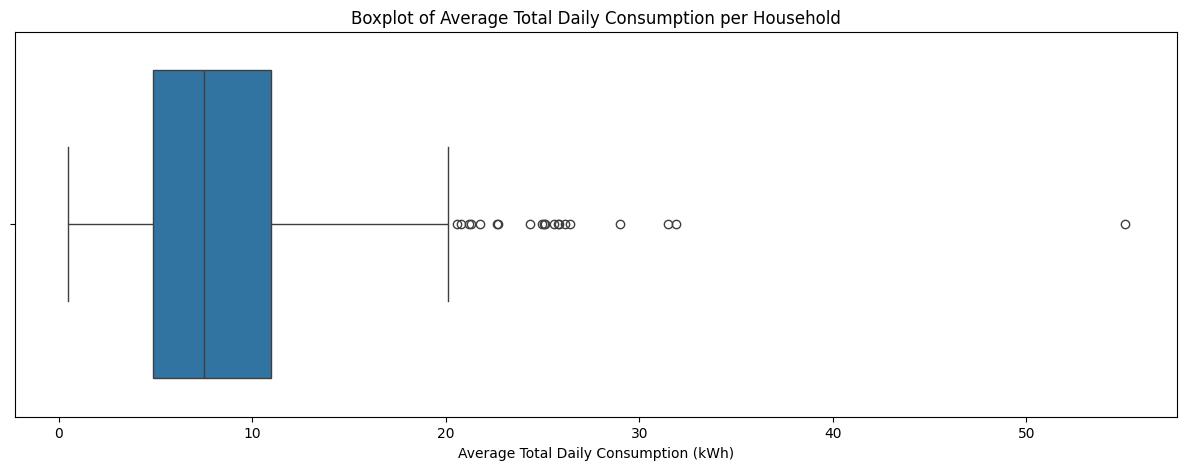


Summary statistics for average total daily consumption per household:
count    608.000000
mean       8.617090
std        5.407511
min        0.455204
25%        4.861669
50%        7.520487
75%       10.967699
max       55.065859
Name: consumption, dtype: float64
Number of outliers: 20
Percentage of outliers: 3.29%


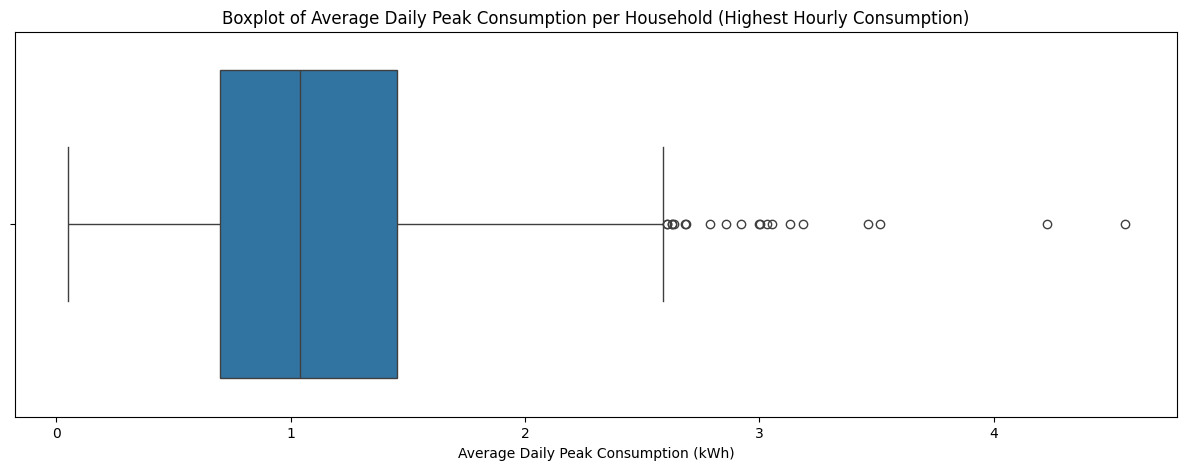


Summary statistics for average daily peak consumption per household (highest hourly consumption):
count    608.000000
mean       1.139080
std        0.625162
min        0.048288
25%        0.699504
50%        1.037593
75%        1.455383
max        4.558521
Name: consumption, dtype: float64
Number of outliers: 20
Percentage of outliers: 3.29%


In [16]:
def plot_distribution(data, title, xlabel):
    plt.figure(figsize=(15, 5))
    sns.histplot(data, kde=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count of Households')
    plt.show()

def plot_timeseries(x, y, title, ylabel):
    plt.figure(figsize=(12, 5))
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_boxplot(data, title, xlabel):
    plt.figure(figsize=(15, 5))
    sns.boxplot(x=data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

def print_summary_stats(data, title):
    print(f"\nSummary statistics for {title}:")
    print(data.describe())
    Q1, Q3 = data.quantile(0.25), data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))]
    print(f"Number of outliers: {len(outliers)}")
    print(f"Percentage of outliers: {len(outliers) / len(data) * 100:.2f}%")

# Calculate daily total and peak consumption
daily_total = df_merged.groupby(['household_id', df_merged['timestamp'].dt.date])['consumption'].sum().reset_index()
daily_peak = df_merged.groupby(['household_id', df_merged['timestamp'].dt.date])['consumption'].max().reset_index()

daily_avg_distribution = daily_total.groupby('household_id')['consumption'].mean()
daily_peak_distribution = daily_peak.groupby('household_id')['consumption'].mean()

# Plotting

# This is the mean of the daily totals of each household
plot_distribution(daily_avg_distribution, 'Distribution of Average Total Daily Consumption per Household', 'Average Total Daily Consumption (kWh)')

# This is the mean of the highest value for the day across all households
plot_distribution(daily_peak_distribution, 'Distribution of Average Daily Peak Consumption per Household', 'Average Daily Peak Consumption (kWh)')

avg_daily_peak = daily_peak.groupby('timestamp')['consumption'].mean()
plot_timeseries(avg_daily_peak.index, avg_daily_peak.values, 'Average Daily Peak Consumption Over Time (All Households)', 'Average Daily Peak Consumption (kWh)')

plot_distribution(df_merged['consumption'], 'Distribution of All Consumption Values', 'Consumption (kWh)')
plot_boxplot(df_merged['consumption'], 'Boxplot of All Consumption Values', 'Consumption (kWh)')

print_summary_stats(df_merged['consumption'], 'all consumption values')

# This is the mean of the daily totals of each household
plot_boxplot(daily_avg_distribution, 'Boxplot of Average Total Daily Consumption per Household', 'Average Total Daily Consumption (kWh)')
print_summary_stats(daily_avg_distribution, 'average total daily consumption per household')

# This is the mean of the highest value for the day across all households
plot_boxplot(daily_peak_distribution, 'Boxplot of Average Daily Peak Consumption per Household (Highest Hourly Consumption)', 'Average Daily Peak Consumption (kWh)')
print_summary_stats(daily_peak_distribution, 'average daily peak consumption per household (highest hourly consumption)')

### The consumption values seem reasonable according to the plots

In [17]:
# Save the full imputed dataframe
df_merged_updated.to_csv('5) final_merged_data_imputed.csv', index=False)
print("\nFull imputed dataframe saved as '5) final_merged_data_imputed.csv'")


Full imputed dataframe saved as '5) final_merged_data_imputed.csv'
